## baseline1版本，不参与建模的特征 [  'os', 'sid’]

In [190]:
## 这个版本主要进行了一些模型的融合


## score1=88.128   加osv
## score2=88.10 加了timestamp  

## 4. score3=88.9707 做完了特征融合跑了xgboost

In [191]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # 不会报warning错误

# 数据加载
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test1.csv')
test = test.iloc[:, 1:]
train = train.iloc[:, 1:]

##### Object类型： lan, os, osv, version, fea_hash
##### 有缺失值的字段： lan, osv

In [192]:
features = train.columns.tolist()
features.remove('label')
print(features)

['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi', 'dev_width', 'lan', 'media_id', 'ntt', 'os', 'osv', 'package', 'sid', 'timestamp', 'version', 'fea_hash', 'location', 'fea1_hash', 'cus_type']


In [193]:

#加 osv
train['fea_hash'].map(lambda x: len(str(x))).value_counts()
train['fea1_hash'].map(lambda x: len(str(x))).value_counts()
remove_list = ['os','sid']
col = features
for i in remove_list:
    col.remove(i)
features = train[col]
features['fea_hash_len'] = features['fea_hash'].map(lambda x: len(str(x)))
features['fea1_hash_len'] = features['fea1_hash'].map(lambda x: len(str(x)))
features['fea_hash'] = features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
features['fea1_hash'] = features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features = test[col]
test_features['fea_hash_len'] = test_features['fea_hash'].map(lambda x: len(str(x)))
test_features['fea1_hash_len'] = test_features['fea1_hash'].map(lambda x: len(str(x)))
test_features['fea_hash'] = test_features['fea_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))
test_features['fea1_hash'] = test_features['fea1_hash'].map(lambda x: 0 if len(str(x))>16 else int(x))


In [194]:
# 定义一个函数 
# 1.去掉'.'和' ' 和'_'
# 2.用众数填充 非数值 如果字符串中有，人能辨识的数值则用该数值填充
# 3. 如果是nan 则众数填充

# error ValueError: invalid literal for int() with base 10: '60十核20G_HD'
#ValueError: invalid literal for int() with base 10: 'Android512'

def app_osv(x):
    x=str(x).replace('Android_','').replace(' ','').replace('.','').replace('60十核20G_HD','').replace('Android','').replace('44W','')
    #
    if x=='nan' or x=='GIONEE_YNGA'or x=='f073b_changxiang_v01_b1b8_20180915' or x==''or x=='%E6%B1%9F%E7%81%B5OS+50':
        return 810
    elif x.count('-')>0:
        return  int(x.split('-')[0])
    else:
        res=int(x)
        if res<10:
            return res*100
        elif res<100:
            return res*10
    return res
            

In [195]:
features['osv']=features['osv'].apply(app_osv)
test_features['osv']=test_features['osv'].apply(app_osv)

In [196]:
# 加timestamp
from datetime import datetime
features['timestamp'] = features['timestamp'].apply(lambda x : datetime.fromtimestamp(x/1000))
# 分解时间
# features['year'] = features['timestamp'].dt.year
# features['month'] = features['timestamp'].dt.month
# features['day'] = features['timestamp'].dt.day
# features['weekday'] = features['timestamp'].dt.weekday
# features['hour'] = features['timestamp'].dt.hour
# features['minute'] = features['timestamp'].dt.minute
start_time = features['timestamp'].min()
features['timestamp_diff_start'] = features['timestamp']-start_time
features['timestamp_diff_start'] = features['timestamp_diff_start'].dt.days - features['timestamp_diff_start'].dt.seconds/3600/24

In [197]:
test_features['timestamp'] = test_features['timestamp'].apply(lambda x : datetime.fromtimestamp(x/1000))
# 分解时间
# test_features['year'] = test_features['timestamp'].dt.year
# test_features['month'] = test_features['timestamp'].dt.month
# test_features['day'] = test_features['timestamp'].dt.day
# test_features['weekday'] = test_features['timestamp'].dt.weekday
# test_features['hour'] = test_features['timestamp'].dt.hour
# test_features['minute'] = test_features['timestamp'].dt.minute
start_time = test_features['timestamp'].min()
test_features['timestamp_diff_start'] = test_features['timestamp']-start_time
test_features['timestamp_diff_start'] = test_features['timestamp_diff_start'].dt.days - test_features['timestamp_diff_start'].dt.seconds/3600/24

In [198]:
# 加version
# 转化app版本号
def trans_version(version):
    version = version.replace('V','').replace('P_Final_','').replace(' ','').replace('GA','').replace('v','')
    if version == '50':
        return int(5)
    return int(version)
features['version'] = features['version'].apply(trans_version)
test_features['version'] = test_features['version'].apply(trans_version)

In [199]:
# 加 lan 
# 转换lan
def trans_lan(lan):
    lan = str(lan)
    if 'zh' in lan.lower() or 'cn' in lan.lower():
        return int(0)
    else:
        return int(1)
features['lan'] = features['lan'].apply(trans_lan)
test_features['lan']=test_features['lan'].apply(trans_lan)

In [200]:
features


,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,lan,media_id,ntt,osv,package,timestamp,version,fea_hash,location,fea1_hash,cus_type,fea_hash_len,fea1_hash_len,timestamp_diff_start
0,316361,1199,46000.0,0.0,0.0,0.0,1,104,6.0,900,18,2019-06-07 15:32:08.241721,8,2135019403,0,2329670524,601,10,10,3.352697
1,135939,893,0.0,0.0,0.0,0.0,1,19,6.0,810,0,2019-06-08 19:40:20.922229,4,2782306428,1,2864801071,1000,10,10,4.180336
2,399254,821,0.0,760.0,0.0,360.0,1,559,0.0,810,0,2019-06-06 23:58:17.549109,0,1392806005,2,628911675,696,10,9,2.001204
3,68983,1004,46000.0,2214.0,0.0,1080.0,1,129,2.0,810,0,2019-06-09 08:59:37.719685,0,3562553457,3,1283809327,753,10,10,5.625278
4,288999,1076,46000.0,2280.0,0.0,1080.0,0,64,2.0,800,0,2019-06-07 08:28:21.478553,5,2364522023,4,1510695983,582,10,10,3.646991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,392477,1028,46000.0,1920.0,3.0,1080.0,0,144,6.0,712,25,2019-06-06 23:14:18.267242,7,861755946,79,140647032,373,9,9,2.031748
499996,346134,1001,0.0,1424.0,0.0,720.0,1,29,2.0,810,0,2019-06-06 17:40:54.045280,3,1714444511,23,2745131047,525,10,10,2.263287
499997,499635,761,46000.0,1280.0,0.0,720.0,1,54,6.0,601,9,2019-06-05 03:14:57.290064,0,3843262581,25,1326115882,810,10,10,1.864630
499998,239786,917,46001.0,960.0,0.0,540.0,0,109,2.0,511,0,2019-06-07 00:59:27.651521,0,1984296118,225,1446741112,772,10,10,3.958727


In [201]:
#特征融合 

#1.版本号处理
features['osv1'] = features['osv'] - features['version'] 
# 2.height*weight
features['dev_area'] = features['dev_height']*features['dev_width']
# # 构造特征比
# temp=pd.DataFrame(columns=[0,1])
# temp0=train[train['label']==0]
# temp[0]=temp0['osv'].value_counts()/len(temp0)*100 #版本占百分比 
# temp1=train[train['label']==1]
# temp[1]=temp1['osv'].value_counts()/len(temp1)*100 #版本占百分比 
# temp[2]=temp[1]/temp[0]
# # 选出大于11倍的特征
# result=temp[temp[2]>11].sort_values(2,ascending=False).index
# key_feature={}
# key_feature['osv']=result
# key_feature

In [202]:
# def f(x):
#     if x in key_feature['osv']:
#         return 1
#     else:
#         return 0
#     features['osv_']=features['osv'].apply(f)

In [203]:
#特征融合 

#1.版本号处理
test_features['osv1'] = test_features['osv'] - test_features['version'] 
# 2.height*weight
test_features['dev_area'] =test_features['dev_height']*test_features['dev_width']
# # 构造特征比  无法知道label
# temp=pd.DataFrame(columns=[0,1])
# temp0=test[test['label']==0]
# temp[0]=temp0['osv'].value_counts()/len(temp0)*100 #版本占百分比 
# temp1=test[test['label']==1]
# temp[1]=temp1['osv'].value_counts()/len(temp1)*100 #版本占百分比 
# temp[2]=temp[1]/temp[0]
# # 选出大于11倍的特征
# result=temp[temp[2]>11].sort_values(2,ascending=False).index
# key_feature={}
# key_feature['osv']=result
# key_feature    
# test_features['osv_']=test_features['osv'].apply(f)

features

In [204]:
features=features.drop(['timestamp'], axis=1)
test_features=test_features.drop(['timestamp'], axis=1)

In [205]:
features.columns

Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package', 'version',
       'fea_hash', 'location', 'fea1_hash', 'cus_type', 'fea_hash_len',
       'fea1_hash_len', 'timestamp_diff_start', 'osv1', 'dev_area'],
      dtype='object')

In [206]:
test_features.columns


Index(['android_id', 'apptype', 'carrier', 'dev_height', 'dev_ppi',
       'dev_width', 'lan', 'media_id', 'ntt', 'osv', 'package', 'version',
       'fea_hash', 'location', 'fea1_hash', 'cus_type', 'fea_hash_len',
       'fea1_hash_len', 'timestamp_diff_start', 'osv1', 'dev_area'],
      dtype='object')

In [207]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   android_id            500000 non-null  int64  
 1   apptype               500000 non-null  int64  
 2   carrier               500000 non-null  float64
 3   dev_height            500000 non-null  float64
 4   dev_ppi               500000 non-null  float64
 5   dev_width             500000 non-null  float64
 6   lan                   500000 non-null  int64  
 7   media_id              500000 non-null  int64  
 8   ntt                   500000 non-null  float64
 9   osv                   500000 non-null  int64  
 10  package               500000 non-null  int64  
 11  version               500000 non-null  int64  
 12  fea_hash              500000 non-null  int64  
 13  location              500000 non-null  int64  
 14  fea1_hash             500000 non-null  int64  
 15  

In [208]:
# catboost over  fuge 
# from sklearn.model_selection import GridSearchCV
# # gs=GridSearchCV(xgb,param_grid,cv=7,n_jobs=-1)
# %%time
# gs.fit(features,train['label'])
#  xgb = xgb.XGBClassifier(max_length=13,n_estimators=7000,subsample=0.8,
#              learning_rate=0.03, 
#             objective='binary:logistic', tree_method='gpu_hist',colsample_bytree=0.8, 
#               eval_metric='auc', reg_lambda=0.5 )
# xgb.fit(features,train['label'])
# res=xgb.predict(test_features)
# result_ = pd.DataFrame(test['sid'])
# result_['label'] = res
# result_.to_csv('./baseline_xgboost2.csv', index=False)
# result_

In [209]:
# xgboost
import xgboost as xgb
import numpy as np

In [210]:
 xgb = xgb.XGBClassifier(n_estimators=7000,subsample=0.8,
             learning_rate=0.03, 
            objective='binary:logistic', tree_method='gpu_hist',colsample_bytree=0.8, 
              eval_metric='auc', reg_lambda=0.5 )
# xgb.fit(features,train['label'])
# res=xgb.predict(test_features)
# result_ = pd.DataFrame(test['sid'])
# result_['label'] = res
# result_.to_csv('./baseline_xgboost2.csv', index=False)
# result_

In [214]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=2022)
prob = []
mean_acc = 0
for k,(train_index, test_index) in enumerate(skf.split(features, train['label'])):
    X_train, X_val = features.iloc[train_index], features.iloc[test_index]
    y_train, y_val = train['label'].iloc[train_index], train['label'].iloc[test_index]
    xgb = xgb.fit(X_train,y_train,eval_set=[(X_val, y_val)],verbose = True)
    # 正式预测
    test_y_pred = xgb.predict(test_features)
    prob.append(test_y_pred)

[0]	validation_0-auc:0.90533
[1]	validation_0-auc:0.90672
[2]	validation_0-auc:0.91261
[3]	validation_0-auc:0.91405
[4]	validation_0-auc:0.91535
[5]	validation_0-auc:0.91488
[6]	validation_0-auc:0.91770
[7]	validation_0-auc:0.91747
[8]	validation_0-auc:0.91725
[9]	validation_0-auc:0.91775
[10]	validation_0-auc:0.91787
[11]	validation_0-auc:0.91809
[12]	validation_0-auc:0.91834
[13]	validation_0-auc:0.91871
[14]	validation_0-auc:0.91858
[15]	validation_0-auc:0.91882
[16]	validation_0-auc:0.91886
[17]	validation_0-auc:0.91894
[18]	validation_0-auc:0.91884
[19]	validation_0-auc:0.91889
[20]	validation_0-auc:0.91893
[21]	validation_0-auc:0.91898
[22]	validation_0-auc:0.91910
[23]	validation_0-auc:0.91962
[24]	validation_0-auc:0.92028
[25]	validation_0-auc:0.92027
[26]	validation_0-auc:0.92065
[27]	validation_0-auc:0.92059
[28]	validation_0-auc:0.92064
[29]	validation_0-auc:0.92068
[30]	validation_0-auc:0.92127
[31]	validation_0-auc:0.92129
[32]	validation_0-auc:0.92126
[33]	validation_0-au

[267]	validation_0-auc:0.93895
[268]	validation_0-auc:0.93897
[269]	validation_0-auc:0.93901
[270]	validation_0-auc:0.93907
[271]	validation_0-auc:0.93911
[272]	validation_0-auc:0.93912
[273]	validation_0-auc:0.93913
[274]	validation_0-auc:0.93915
[275]	validation_0-auc:0.93916
[276]	validation_0-auc:0.93917
[277]	validation_0-auc:0.93918
[278]	validation_0-auc:0.93919
[279]	validation_0-auc:0.93922
[280]	validation_0-auc:0.93927
[281]	validation_0-auc:0.93927
[282]	validation_0-auc:0.93930
[283]	validation_0-auc:0.93932
[284]	validation_0-auc:0.93934
[285]	validation_0-auc:0.93934
[286]	validation_0-auc:0.93938
[287]	validation_0-auc:0.93939
[288]	validation_0-auc:0.93940
[289]	validation_0-auc:0.93943
[290]	validation_0-auc:0.93945
[291]	validation_0-auc:0.93947
[292]	validation_0-auc:0.93948
[293]	validation_0-auc:0.93951
[294]	validation_0-auc:0.93953
[295]	validation_0-auc:0.93956
[296]	validation_0-auc:0.93957
[297]	validation_0-auc:0.93957
[298]	validation_0-auc:0.93963
[299]	va

[531]	validation_0-auc:0.94215
[532]	validation_0-auc:0.94216
[533]	validation_0-auc:0.94217
[534]	validation_0-auc:0.94218
[535]	validation_0-auc:0.94219
[536]	validation_0-auc:0.94220
[537]	validation_0-auc:0.94221
[538]	validation_0-auc:0.94223
[539]	validation_0-auc:0.94224
[540]	validation_0-auc:0.94224
[541]	validation_0-auc:0.94225
[542]	validation_0-auc:0.94225
[543]	validation_0-auc:0.94226
[544]	validation_0-auc:0.94226
[545]	validation_0-auc:0.94226
[546]	validation_0-auc:0.94226
[547]	validation_0-auc:0.94226
[548]	validation_0-auc:0.94226
[549]	validation_0-auc:0.94226
[550]	validation_0-auc:0.94227
[551]	validation_0-auc:0.94226
[552]	validation_0-auc:0.94227
[553]	validation_0-auc:0.94226
[554]	validation_0-auc:0.94227
[555]	validation_0-auc:0.94226
[556]	validation_0-auc:0.94227
[557]	validation_0-auc:0.94227
[558]	validation_0-auc:0.94228
[559]	validation_0-auc:0.94228
[560]	validation_0-auc:0.94229
[561]	validation_0-auc:0.94229
[562]	validation_0-auc:0.94232
[563]	va

[796]	validation_0-auc:0.94337
[797]	validation_0-auc:0.94338
[798]	validation_0-auc:0.94338
[799]	validation_0-auc:0.94338
[800]	validation_0-auc:0.94338
[801]	validation_0-auc:0.94339
[802]	validation_0-auc:0.94339
[803]	validation_0-auc:0.94339
[804]	validation_0-auc:0.94339
[805]	validation_0-auc:0.94339
[806]	validation_0-auc:0.94339
[807]	validation_0-auc:0.94340
[808]	validation_0-auc:0.94340
[809]	validation_0-auc:0.94340
[810]	validation_0-auc:0.94340
[811]	validation_0-auc:0.94341
[812]	validation_0-auc:0.94342
[813]	validation_0-auc:0.94342
[814]	validation_0-auc:0.94343
[815]	validation_0-auc:0.94343
[816]	validation_0-auc:0.94343
[817]	validation_0-auc:0.94342
[818]	validation_0-auc:0.94343
[819]	validation_0-auc:0.94343
[820]	validation_0-auc:0.94343
[821]	validation_0-auc:0.94343
[822]	validation_0-auc:0.94343
[823]	validation_0-auc:0.94343
[824]	validation_0-auc:0.94344
[825]	validation_0-auc:0.94344
[826]	validation_0-auc:0.94344
[827]	validation_0-auc:0.94344
[828]	va

[1058]	validation_0-auc:0.94391
[1059]	validation_0-auc:0.94391
[1060]	validation_0-auc:0.94392
[1061]	validation_0-auc:0.94392
[1062]	validation_0-auc:0.94392
[1063]	validation_0-auc:0.94392
[1064]	validation_0-auc:0.94392
[1065]	validation_0-auc:0.94392
[1066]	validation_0-auc:0.94392
[1067]	validation_0-auc:0.94392
[1068]	validation_0-auc:0.94393
[1069]	validation_0-auc:0.94393
[1070]	validation_0-auc:0.94393
[1071]	validation_0-auc:0.94393
[1072]	validation_0-auc:0.94393
[1073]	validation_0-auc:0.94393
[1074]	validation_0-auc:0.94393
[1075]	validation_0-auc:0.94393
[1076]	validation_0-auc:0.94393
[1077]	validation_0-auc:0.94393
[1078]	validation_0-auc:0.94393
[1079]	validation_0-auc:0.94393
[1080]	validation_0-auc:0.94393
[1081]	validation_0-auc:0.94393
[1082]	validation_0-auc:0.94394
[1083]	validation_0-auc:0.94394
[1084]	validation_0-auc:0.94394
[1085]	validation_0-auc:0.94394
[1086]	validation_0-auc:0.94394
[1087]	validation_0-auc:0.94394
[1088]	validation_0-auc:0.94394
[1089]	v

[1314]	validation_0-auc:0.94422
[1315]	validation_0-auc:0.94422
[1316]	validation_0-auc:0.94422
[1317]	validation_0-auc:0.94422
[1318]	validation_0-auc:0.94422
[1319]	validation_0-auc:0.94422
[1320]	validation_0-auc:0.94422
[1321]	validation_0-auc:0.94422
[1322]	validation_0-auc:0.94422
[1323]	validation_0-auc:0.94423
[1324]	validation_0-auc:0.94423
[1325]	validation_0-auc:0.94423
[1326]	validation_0-auc:0.94423
[1327]	validation_0-auc:0.94423
[1328]	validation_0-auc:0.94423
[1329]	validation_0-auc:0.94422
[1330]	validation_0-auc:0.94423
[1331]	validation_0-auc:0.94423
[1332]	validation_0-auc:0.94423
[1333]	validation_0-auc:0.94423
[1334]	validation_0-auc:0.94423
[1335]	validation_0-auc:0.94423
[1336]	validation_0-auc:0.94424
[1337]	validation_0-auc:0.94424
[1338]	validation_0-auc:0.94424
[1339]	validation_0-auc:0.94424
[1340]	validation_0-auc:0.94424
[1341]	validation_0-auc:0.94424
[1342]	validation_0-auc:0.94424
[1343]	validation_0-auc:0.94424
[1344]	validation_0-auc:0.94424
[1345]	v

[1571]	validation_0-auc:0.94436
[1572]	validation_0-auc:0.94436
[1573]	validation_0-auc:0.94436
[1574]	validation_0-auc:0.94436
[1575]	validation_0-auc:0.94437
[1576]	validation_0-auc:0.94437
[1577]	validation_0-auc:0.94437
[1578]	validation_0-auc:0.94437
[1579]	validation_0-auc:0.94437
[1580]	validation_0-auc:0.94437
[1581]	validation_0-auc:0.94437
[1582]	validation_0-auc:0.94437
[1583]	validation_0-auc:0.94436
[1584]	validation_0-auc:0.94436
[1585]	validation_0-auc:0.94437
[1586]	validation_0-auc:0.94437
[1587]	validation_0-auc:0.94437
[1588]	validation_0-auc:0.94437
[1589]	validation_0-auc:0.94437
[1590]	validation_0-auc:0.94437
[1591]	validation_0-auc:0.94437
[1592]	validation_0-auc:0.94437
[1593]	validation_0-auc:0.94437
[1594]	validation_0-auc:0.94437
[1595]	validation_0-auc:0.94437
[1596]	validation_0-auc:0.94437
[1597]	validation_0-auc:0.94437
[1598]	validation_0-auc:0.94437
[1599]	validation_0-auc:0.94437
[1600]	validation_0-auc:0.94437
[1601]	validation_0-auc:0.94437
[1602]	v

[1827]	validation_0-auc:0.94448
[1828]	validation_0-auc:0.94448
[1829]	validation_0-auc:0.94448
[1830]	validation_0-auc:0.94448
[1831]	validation_0-auc:0.94448
[1832]	validation_0-auc:0.94448
[1833]	validation_0-auc:0.94448
[1834]	validation_0-auc:0.94448
[1835]	validation_0-auc:0.94448
[1836]	validation_0-auc:0.94448
[1837]	validation_0-auc:0.94448
[1838]	validation_0-auc:0.94448
[1839]	validation_0-auc:0.94448
[1840]	validation_0-auc:0.94448
[1841]	validation_0-auc:0.94448
[1842]	validation_0-auc:0.94448
[1843]	validation_0-auc:0.94448
[1844]	validation_0-auc:0.94448
[1845]	validation_0-auc:0.94448
[1846]	validation_0-auc:0.94448
[1847]	validation_0-auc:0.94449
[1848]	validation_0-auc:0.94448
[1849]	validation_0-auc:0.94449
[1850]	validation_0-auc:0.94449
[1851]	validation_0-auc:0.94449
[1852]	validation_0-auc:0.94449
[1853]	validation_0-auc:0.94449
[1854]	validation_0-auc:0.94450
[1855]	validation_0-auc:0.94450
[1856]	validation_0-auc:0.94450
[1857]	validation_0-auc:0.94449
[1858]	v

[2084]	validation_0-auc:0.94458
[2085]	validation_0-auc:0.94458
[2086]	validation_0-auc:0.94458
[2087]	validation_0-auc:0.94458
[2088]	validation_0-auc:0.94458
[2089]	validation_0-auc:0.94458
[2090]	validation_0-auc:0.94458
[2091]	validation_0-auc:0.94458
[2092]	validation_0-auc:0.94458
[2093]	validation_0-auc:0.94459
[2094]	validation_0-auc:0.94458
[2095]	validation_0-auc:0.94459
[2096]	validation_0-auc:0.94458
[2097]	validation_0-auc:0.94459
[2098]	validation_0-auc:0.94459
[2099]	validation_0-auc:0.94459
[2100]	validation_0-auc:0.94459
[2101]	validation_0-auc:0.94459
[2102]	validation_0-auc:0.94459
[2103]	validation_0-auc:0.94459
[2104]	validation_0-auc:0.94459
[2105]	validation_0-auc:0.94459
[2106]	validation_0-auc:0.94459
[2107]	validation_0-auc:0.94459
[2108]	validation_0-auc:0.94459
[2109]	validation_0-auc:0.94459
[2110]	validation_0-auc:0.94459
[2111]	validation_0-auc:0.94459
[2112]	validation_0-auc:0.94459
[2113]	validation_0-auc:0.94459
[2114]	validation_0-auc:0.94459
[2115]	v

[2340]	validation_0-auc:0.94458
[2341]	validation_0-auc:0.94458
[2342]	validation_0-auc:0.94458
[2343]	validation_0-auc:0.94458
[2344]	validation_0-auc:0.94458
[2345]	validation_0-auc:0.94458
[2346]	validation_0-auc:0.94458
[2347]	validation_0-auc:0.94458
[2348]	validation_0-auc:0.94458
[2349]	validation_0-auc:0.94458
[2350]	validation_0-auc:0.94458
[2351]	validation_0-auc:0.94458
[2352]	validation_0-auc:0.94457
[2353]	validation_0-auc:0.94457
[2354]	validation_0-auc:0.94457
[2355]	validation_0-auc:0.94457
[2356]	validation_0-auc:0.94457
[2357]	validation_0-auc:0.94457
[2358]	validation_0-auc:0.94457
[2359]	validation_0-auc:0.94457
[2360]	validation_0-auc:0.94457
[2361]	validation_0-auc:0.94457
[2362]	validation_0-auc:0.94457
[2363]	validation_0-auc:0.94457
[2364]	validation_0-auc:0.94457
[2365]	validation_0-auc:0.94457
[2366]	validation_0-auc:0.94457
[2367]	validation_0-auc:0.94457
[2368]	validation_0-auc:0.94458
[2369]	validation_0-auc:0.94458
[2370]	validation_0-auc:0.94457
[2371]	v

[2596]	validation_0-auc:0.94457
[2597]	validation_0-auc:0.94457
[2598]	validation_0-auc:0.94457
[2599]	validation_0-auc:0.94457
[2600]	validation_0-auc:0.94457
[2601]	validation_0-auc:0.94457
[2602]	validation_0-auc:0.94457
[2603]	validation_0-auc:0.94457
[2604]	validation_0-auc:0.94457
[2605]	validation_0-auc:0.94457
[2606]	validation_0-auc:0.94457
[2607]	validation_0-auc:0.94457
[2608]	validation_0-auc:0.94457
[2609]	validation_0-auc:0.94457
[2610]	validation_0-auc:0.94457
[2611]	validation_0-auc:0.94457
[2612]	validation_0-auc:0.94457
[2613]	validation_0-auc:0.94457
[2614]	validation_0-auc:0.94457
[2615]	validation_0-auc:0.94457
[2616]	validation_0-auc:0.94458
[2617]	validation_0-auc:0.94458
[2618]	validation_0-auc:0.94458
[2619]	validation_0-auc:0.94458
[2620]	validation_0-auc:0.94458
[2621]	validation_0-auc:0.94458
[2622]	validation_0-auc:0.94458
[2623]	validation_0-auc:0.94458
[2624]	validation_0-auc:0.94458
[2625]	validation_0-auc:0.94458
[2626]	validation_0-auc:0.94459
[2627]	v

[2853]	validation_0-auc:0.94463
[2854]	validation_0-auc:0.94463
[2855]	validation_0-auc:0.94463
[2856]	validation_0-auc:0.94463
[2857]	validation_0-auc:0.94463
[2858]	validation_0-auc:0.94463
[2859]	validation_0-auc:0.94463
[2860]	validation_0-auc:0.94463
[2861]	validation_0-auc:0.94463
[2862]	validation_0-auc:0.94463
[2863]	validation_0-auc:0.94463
[2864]	validation_0-auc:0.94463
[2865]	validation_0-auc:0.94463
[2866]	validation_0-auc:0.94463
[2867]	validation_0-auc:0.94463
[2868]	validation_0-auc:0.94463
[2869]	validation_0-auc:0.94463
[2870]	validation_0-auc:0.94463
[2871]	validation_0-auc:0.94463
[2872]	validation_0-auc:0.94463
[2873]	validation_0-auc:0.94464
[2874]	validation_0-auc:0.94464
[2875]	validation_0-auc:0.94464
[2876]	validation_0-auc:0.94464
[2877]	validation_0-auc:0.94464
[2878]	validation_0-auc:0.94464
[2879]	validation_0-auc:0.94464
[2880]	validation_0-auc:0.94464
[2881]	validation_0-auc:0.94464
[2882]	validation_0-auc:0.94464
[2883]	validation_0-auc:0.94464
[2884]	v

[3109]	validation_0-auc:0.94464
[3110]	validation_0-auc:0.94464
[3111]	validation_0-auc:0.94464
[3112]	validation_0-auc:0.94464
[3113]	validation_0-auc:0.94463
[3114]	validation_0-auc:0.94463
[3115]	validation_0-auc:0.94464
[3116]	validation_0-auc:0.94464
[3117]	validation_0-auc:0.94464
[3118]	validation_0-auc:0.94464
[3119]	validation_0-auc:0.94464
[3120]	validation_0-auc:0.94464
[3121]	validation_0-auc:0.94464
[3122]	validation_0-auc:0.94464
[3123]	validation_0-auc:0.94464
[3124]	validation_0-auc:0.94464
[3125]	validation_0-auc:0.94464
[3126]	validation_0-auc:0.94464
[3127]	validation_0-auc:0.94464
[3128]	validation_0-auc:0.94464
[3129]	validation_0-auc:0.94464
[3130]	validation_0-auc:0.94464
[3131]	validation_0-auc:0.94464
[3132]	validation_0-auc:0.94464
[3133]	validation_0-auc:0.94464
[3134]	validation_0-auc:0.94464
[3135]	validation_0-auc:0.94464
[3136]	validation_0-auc:0.94464
[3137]	validation_0-auc:0.94464
[3138]	validation_0-auc:0.94464
[3139]	validation_0-auc:0.94464
[3140]	v

[3365]	validation_0-auc:0.94460
[3366]	validation_0-auc:0.94460
[3367]	validation_0-auc:0.94460
[3368]	validation_0-auc:0.94460
[3369]	validation_0-auc:0.94460
[3370]	validation_0-auc:0.94460
[3371]	validation_0-auc:0.94461
[3372]	validation_0-auc:0.94461
[3373]	validation_0-auc:0.94461
[3374]	validation_0-auc:0.94461
[3375]	validation_0-auc:0.94461
[3376]	validation_0-auc:0.94460
[3377]	validation_0-auc:0.94460
[3378]	validation_0-auc:0.94460
[3379]	validation_0-auc:0.94461
[3380]	validation_0-auc:0.94460
[3381]	validation_0-auc:0.94461
[3382]	validation_0-auc:0.94461
[3383]	validation_0-auc:0.94460
[3384]	validation_0-auc:0.94460
[3385]	validation_0-auc:0.94460
[3386]	validation_0-auc:0.94460
[3387]	validation_0-auc:0.94460
[3388]	validation_0-auc:0.94460
[3389]	validation_0-auc:0.94460
[3390]	validation_0-auc:0.94460
[3391]	validation_0-auc:0.94460
[3392]	validation_0-auc:0.94460
[3393]	validation_0-auc:0.94460
[3394]	validation_0-auc:0.94460
[3395]	validation_0-auc:0.94460
[3396]	v

[3621]	validation_0-auc:0.94455
[3622]	validation_0-auc:0.94455
[3623]	validation_0-auc:0.94455
[3624]	validation_0-auc:0.94455
[3625]	validation_0-auc:0.94455
[3626]	validation_0-auc:0.94455
[3627]	validation_0-auc:0.94455
[3628]	validation_0-auc:0.94455
[3629]	validation_0-auc:0.94455
[3630]	validation_0-auc:0.94455
[3631]	validation_0-auc:0.94455
[3632]	validation_0-auc:0.94455
[3633]	validation_0-auc:0.94455
[3634]	validation_0-auc:0.94455
[3635]	validation_0-auc:0.94455
[3636]	validation_0-auc:0.94455
[3637]	validation_0-auc:0.94455
[3638]	validation_0-auc:0.94455
[3639]	validation_0-auc:0.94455
[3640]	validation_0-auc:0.94455
[3641]	validation_0-auc:0.94455
[3642]	validation_0-auc:0.94455
[3643]	validation_0-auc:0.94454
[3644]	validation_0-auc:0.94454
[3645]	validation_0-auc:0.94454
[3646]	validation_0-auc:0.94455
[3647]	validation_0-auc:0.94455
[3648]	validation_0-auc:0.94455
[3649]	validation_0-auc:0.94455
[3650]	validation_0-auc:0.94454
[3651]	validation_0-auc:0.94454
[3652]	v

[3877]	validation_0-auc:0.94452
[3878]	validation_0-auc:0.94452
[3879]	validation_0-auc:0.94452
[3880]	validation_0-auc:0.94451
[3881]	validation_0-auc:0.94451
[3882]	validation_0-auc:0.94451
[3883]	validation_0-auc:0.94452
[3884]	validation_0-auc:0.94452
[3885]	validation_0-auc:0.94452
[3886]	validation_0-auc:0.94451
[3887]	validation_0-auc:0.94451
[3888]	validation_0-auc:0.94451
[3889]	validation_0-auc:0.94451
[3890]	validation_0-auc:0.94452
[3891]	validation_0-auc:0.94451
[3892]	validation_0-auc:0.94451
[3893]	validation_0-auc:0.94451
[3894]	validation_0-auc:0.94451
[3895]	validation_0-auc:0.94451
[3896]	validation_0-auc:0.94451
[3897]	validation_0-auc:0.94451
[3898]	validation_0-auc:0.94451
[3899]	validation_0-auc:0.94451
[3900]	validation_0-auc:0.94451
[3901]	validation_0-auc:0.94451
[3902]	validation_0-auc:0.94451
[3903]	validation_0-auc:0.94451
[3904]	validation_0-auc:0.94450
[3905]	validation_0-auc:0.94450
[3906]	validation_0-auc:0.94451
[3907]	validation_0-auc:0.94451
[3908]	v

[4133]	validation_0-auc:0.94448
[4134]	validation_0-auc:0.94448
[4135]	validation_0-auc:0.94448
[4136]	validation_0-auc:0.94448
[4137]	validation_0-auc:0.94448
[4138]	validation_0-auc:0.94448
[4139]	validation_0-auc:0.94449
[4140]	validation_0-auc:0.94449
[4141]	validation_0-auc:0.94449
[4142]	validation_0-auc:0.94449
[4143]	validation_0-auc:0.94448
[4144]	validation_0-auc:0.94448
[4145]	validation_0-auc:0.94448
[4146]	validation_0-auc:0.94448
[4147]	validation_0-auc:0.94448
[4148]	validation_0-auc:0.94448
[4149]	validation_0-auc:0.94448
[4150]	validation_0-auc:0.94448
[4151]	validation_0-auc:0.94448
[4152]	validation_0-auc:0.94448
[4153]	validation_0-auc:0.94447
[4154]	validation_0-auc:0.94448
[4155]	validation_0-auc:0.94448
[4156]	validation_0-auc:0.94448
[4157]	validation_0-auc:0.94447
[4158]	validation_0-auc:0.94447
[4159]	validation_0-auc:0.94447
[4160]	validation_0-auc:0.94447
[4161]	validation_0-auc:0.94447
[4162]	validation_0-auc:0.94447
[4163]	validation_0-auc:0.94447
[4164]	v

[4389]	validation_0-auc:0.94443
[4390]	validation_0-auc:0.94443
[4391]	validation_0-auc:0.94443
[4392]	validation_0-auc:0.94443
[4393]	validation_0-auc:0.94442
[4394]	validation_0-auc:0.94442
[4395]	validation_0-auc:0.94442
[4396]	validation_0-auc:0.94442
[4397]	validation_0-auc:0.94442
[4398]	validation_0-auc:0.94442
[4399]	validation_0-auc:0.94442
[4400]	validation_0-auc:0.94442
[4401]	validation_0-auc:0.94442
[4402]	validation_0-auc:0.94442
[4403]	validation_0-auc:0.94442
[4404]	validation_0-auc:0.94442
[4405]	validation_0-auc:0.94442
[4406]	validation_0-auc:0.94442
[4407]	validation_0-auc:0.94442
[4408]	validation_0-auc:0.94443
[4409]	validation_0-auc:0.94443
[4410]	validation_0-auc:0.94443
[4411]	validation_0-auc:0.94443
[4412]	validation_0-auc:0.94443
[4413]	validation_0-auc:0.94443
[4414]	validation_0-auc:0.94443
[4415]	validation_0-auc:0.94443
[4416]	validation_0-auc:0.94443
[4417]	validation_0-auc:0.94443
[4418]	validation_0-auc:0.94442
[4419]	validation_0-auc:0.94442
[4420]	v

[4645]	validation_0-auc:0.94435
[4646]	validation_0-auc:0.94435
[4647]	validation_0-auc:0.94435
[4648]	validation_0-auc:0.94435
[4649]	validation_0-auc:0.94435
[4650]	validation_0-auc:0.94435
[4651]	validation_0-auc:0.94435
[4652]	validation_0-auc:0.94435
[4653]	validation_0-auc:0.94435
[4654]	validation_0-auc:0.94435
[4655]	validation_0-auc:0.94435
[4656]	validation_0-auc:0.94435
[4657]	validation_0-auc:0.94435
[4658]	validation_0-auc:0.94435
[4659]	validation_0-auc:0.94435
[4660]	validation_0-auc:0.94435
[4661]	validation_0-auc:0.94435
[4662]	validation_0-auc:0.94435
[4663]	validation_0-auc:0.94435
[4664]	validation_0-auc:0.94435
[4665]	validation_0-auc:0.94435
[4666]	validation_0-auc:0.94435
[4667]	validation_0-auc:0.94435
[4668]	validation_0-auc:0.94435
[4669]	validation_0-auc:0.94435
[4670]	validation_0-auc:0.94435
[4671]	validation_0-auc:0.94435
[4672]	validation_0-auc:0.94435
[4673]	validation_0-auc:0.94435
[4674]	validation_0-auc:0.94435
[4675]	validation_0-auc:0.94435
[4676]	v

[4901]	validation_0-auc:0.94430
[4902]	validation_0-auc:0.94430
[4903]	validation_0-auc:0.94430
[4904]	validation_0-auc:0.94430
[4905]	validation_0-auc:0.94430
[4906]	validation_0-auc:0.94430
[4907]	validation_0-auc:0.94429
[4908]	validation_0-auc:0.94429
[4909]	validation_0-auc:0.94429
[4910]	validation_0-auc:0.94429
[4911]	validation_0-auc:0.94429
[4912]	validation_0-auc:0.94429
[4913]	validation_0-auc:0.94429
[4914]	validation_0-auc:0.94429
[4915]	validation_0-auc:0.94429
[4916]	validation_0-auc:0.94429
[4917]	validation_0-auc:0.94429
[4918]	validation_0-auc:0.94429
[4919]	validation_0-auc:0.94429
[4920]	validation_0-auc:0.94429
[4921]	validation_0-auc:0.94429
[4922]	validation_0-auc:0.94429
[4923]	validation_0-auc:0.94429
[4924]	validation_0-auc:0.94429
[4925]	validation_0-auc:0.94429
[4926]	validation_0-auc:0.94429
[4927]	validation_0-auc:0.94429
[4928]	validation_0-auc:0.94429
[4929]	validation_0-auc:0.94429
[4930]	validation_0-auc:0.94429
[4931]	validation_0-auc:0.94429
[4932]	v

[5158]	validation_0-auc:0.94424
[5159]	validation_0-auc:0.94423
[5160]	validation_0-auc:0.94423
[5161]	validation_0-auc:0.94423
[5162]	validation_0-auc:0.94423
[5163]	validation_0-auc:0.94423
[5164]	validation_0-auc:0.94423
[5165]	validation_0-auc:0.94423
[5166]	validation_0-auc:0.94423
[5167]	validation_0-auc:0.94423
[5168]	validation_0-auc:0.94423
[5169]	validation_0-auc:0.94423
[5170]	validation_0-auc:0.94423
[5171]	validation_0-auc:0.94423
[5172]	validation_0-auc:0.94423
[5173]	validation_0-auc:0.94423
[5174]	validation_0-auc:0.94423
[5175]	validation_0-auc:0.94423
[5176]	validation_0-auc:0.94423
[5177]	validation_0-auc:0.94423
[5178]	validation_0-auc:0.94423
[5179]	validation_0-auc:0.94423
[5180]	validation_0-auc:0.94423
[5181]	validation_0-auc:0.94423
[5182]	validation_0-auc:0.94423
[5183]	validation_0-auc:0.94423
[5184]	validation_0-auc:0.94423
[5185]	validation_0-auc:0.94423
[5186]	validation_0-auc:0.94423
[5187]	validation_0-auc:0.94423
[5188]	validation_0-auc:0.94423
[5189]	v

[5415]	validation_0-auc:0.94417
[5416]	validation_0-auc:0.94417
[5417]	validation_0-auc:0.94417
[5418]	validation_0-auc:0.94417
[5419]	validation_0-auc:0.94417
[5420]	validation_0-auc:0.94417
[5421]	validation_0-auc:0.94417
[5422]	validation_0-auc:0.94418
[5423]	validation_0-auc:0.94417
[5424]	validation_0-auc:0.94417
[5425]	validation_0-auc:0.94417
[5426]	validation_0-auc:0.94417
[5427]	validation_0-auc:0.94417
[5428]	validation_0-auc:0.94417
[5429]	validation_0-auc:0.94417
[5430]	validation_0-auc:0.94417
[5431]	validation_0-auc:0.94417
[5432]	validation_0-auc:0.94417
[5433]	validation_0-auc:0.94417
[5434]	validation_0-auc:0.94417
[5435]	validation_0-auc:0.94416
[5436]	validation_0-auc:0.94417
[5437]	validation_0-auc:0.94416
[5438]	validation_0-auc:0.94416
[5439]	validation_0-auc:0.94416
[5440]	validation_0-auc:0.94416
[5441]	validation_0-auc:0.94416
[5442]	validation_0-auc:0.94416
[5443]	validation_0-auc:0.94416
[5444]	validation_0-auc:0.94416
[5445]	validation_0-auc:0.94416
[5446]	v

[5672]	validation_0-auc:0.94410
[5673]	validation_0-auc:0.94410
[5674]	validation_0-auc:0.94410
[5675]	validation_0-auc:0.94410
[5676]	validation_0-auc:0.94410
[5677]	validation_0-auc:0.94410
[5678]	validation_0-auc:0.94410
[5679]	validation_0-auc:0.94410
[5680]	validation_0-auc:0.94410
[5681]	validation_0-auc:0.94410
[5682]	validation_0-auc:0.94410
[5683]	validation_0-auc:0.94410
[5684]	validation_0-auc:0.94410
[5685]	validation_0-auc:0.94410
[5686]	validation_0-auc:0.94410
[5687]	validation_0-auc:0.94410
[5688]	validation_0-auc:0.94410
[5689]	validation_0-auc:0.94410
[5690]	validation_0-auc:0.94410
[5691]	validation_0-auc:0.94410
[5692]	validation_0-auc:0.94410
[5693]	validation_0-auc:0.94410
[5694]	validation_0-auc:0.94410
[5695]	validation_0-auc:0.94410
[5696]	validation_0-auc:0.94410
[5697]	validation_0-auc:0.94409
[5698]	validation_0-auc:0.94409
[5699]	validation_0-auc:0.94409
[5700]	validation_0-auc:0.94409
[5701]	validation_0-auc:0.94409
[5702]	validation_0-auc:0.94409
[5703]	v

[5929]	validation_0-auc:0.94403
[5930]	validation_0-auc:0.94403
[5931]	validation_0-auc:0.94403
[5932]	validation_0-auc:0.94403
[5933]	validation_0-auc:0.94403
[5934]	validation_0-auc:0.94403
[5935]	validation_0-auc:0.94403
[5936]	validation_0-auc:0.94403
[5937]	validation_0-auc:0.94402
[5938]	validation_0-auc:0.94402
[5939]	validation_0-auc:0.94403
[5940]	validation_0-auc:0.94402
[5941]	validation_0-auc:0.94403
[5942]	validation_0-auc:0.94403
[5943]	validation_0-auc:0.94403
[5944]	validation_0-auc:0.94402
[5945]	validation_0-auc:0.94403
[5946]	validation_0-auc:0.94403
[5947]	validation_0-auc:0.94403
[5948]	validation_0-auc:0.94403
[5949]	validation_0-auc:0.94403
[5950]	validation_0-auc:0.94403
[5951]	validation_0-auc:0.94403
[5952]	validation_0-auc:0.94403
[5953]	validation_0-auc:0.94403
[5954]	validation_0-auc:0.94403
[5955]	validation_0-auc:0.94402
[5956]	validation_0-auc:0.94402
[5957]	validation_0-auc:0.94402
[5958]	validation_0-auc:0.94402
[5959]	validation_0-auc:0.94402
[5960]	v

[6185]	validation_0-auc:0.94392
[6186]	validation_0-auc:0.94392
[6187]	validation_0-auc:0.94392
[6188]	validation_0-auc:0.94392
[6189]	validation_0-auc:0.94392
[6190]	validation_0-auc:0.94392
[6191]	validation_0-auc:0.94391
[6192]	validation_0-auc:0.94391
[6193]	validation_0-auc:0.94391
[6194]	validation_0-auc:0.94391
[6195]	validation_0-auc:0.94391
[6196]	validation_0-auc:0.94391
[6197]	validation_0-auc:0.94391
[6198]	validation_0-auc:0.94391
[6199]	validation_0-auc:0.94391
[6200]	validation_0-auc:0.94391
[6201]	validation_0-auc:0.94391
[6202]	validation_0-auc:0.94391
[6203]	validation_0-auc:0.94391
[6204]	validation_0-auc:0.94391
[6205]	validation_0-auc:0.94390
[6206]	validation_0-auc:0.94390
[6207]	validation_0-auc:0.94390
[6208]	validation_0-auc:0.94390
[6209]	validation_0-auc:0.94390
[6210]	validation_0-auc:0.94390
[6211]	validation_0-auc:0.94390
[6212]	validation_0-auc:0.94390
[6213]	validation_0-auc:0.94390
[6214]	validation_0-auc:0.94390
[6215]	validation_0-auc:0.94390
[6216]	v

[6441]	validation_0-auc:0.94382
[6442]	validation_0-auc:0.94382
[6443]	validation_0-auc:0.94382
[6444]	validation_0-auc:0.94382
[6445]	validation_0-auc:0.94382
[6446]	validation_0-auc:0.94382
[6447]	validation_0-auc:0.94382
[6448]	validation_0-auc:0.94382
[6449]	validation_0-auc:0.94382
[6450]	validation_0-auc:0.94382
[6451]	validation_0-auc:0.94382
[6452]	validation_0-auc:0.94382
[6453]	validation_0-auc:0.94382
[6454]	validation_0-auc:0.94382
[6455]	validation_0-auc:0.94382
[6456]	validation_0-auc:0.94382
[6457]	validation_0-auc:0.94382
[6458]	validation_0-auc:0.94382
[6459]	validation_0-auc:0.94382
[6460]	validation_0-auc:0.94382
[6461]	validation_0-auc:0.94382
[6462]	validation_0-auc:0.94382
[6463]	validation_0-auc:0.94382
[6464]	validation_0-auc:0.94382
[6465]	validation_0-auc:0.94382
[6466]	validation_0-auc:0.94382
[6467]	validation_0-auc:0.94382
[6468]	validation_0-auc:0.94382
[6469]	validation_0-auc:0.94382
[6470]	validation_0-auc:0.94382
[6471]	validation_0-auc:0.94382
[6472]	v

[6697]	validation_0-auc:0.94378
[6698]	validation_0-auc:0.94378
[6699]	validation_0-auc:0.94377
[6700]	validation_0-auc:0.94378
[6701]	validation_0-auc:0.94377
[6702]	validation_0-auc:0.94377
[6703]	validation_0-auc:0.94377
[6704]	validation_0-auc:0.94377
[6705]	validation_0-auc:0.94377
[6706]	validation_0-auc:0.94377
[6707]	validation_0-auc:0.94377
[6708]	validation_0-auc:0.94377
[6709]	validation_0-auc:0.94377
[6710]	validation_0-auc:0.94377
[6711]	validation_0-auc:0.94377
[6712]	validation_0-auc:0.94377
[6713]	validation_0-auc:0.94377
[6714]	validation_0-auc:0.94377
[6715]	validation_0-auc:0.94377
[6716]	validation_0-auc:0.94377
[6717]	validation_0-auc:0.94377
[6718]	validation_0-auc:0.94377
[6719]	validation_0-auc:0.94377
[6720]	validation_0-auc:0.94376
[6721]	validation_0-auc:0.94376
[6722]	validation_0-auc:0.94377
[6723]	validation_0-auc:0.94376
[6724]	validation_0-auc:0.94376
[6725]	validation_0-auc:0.94376
[6726]	validation_0-auc:0.94376
[6727]	validation_0-auc:0.94376
[6728]	v

[6953]	validation_0-auc:0.94368
[6954]	validation_0-auc:0.94368
[6955]	validation_0-auc:0.94368
[6956]	validation_0-auc:0.94368
[6957]	validation_0-auc:0.94368
[6958]	validation_0-auc:0.94368
[6959]	validation_0-auc:0.94367
[6960]	validation_0-auc:0.94367
[6961]	validation_0-auc:0.94368
[6962]	validation_0-auc:0.94367
[6963]	validation_0-auc:0.94367
[6964]	validation_0-auc:0.94367
[6965]	validation_0-auc:0.94367
[6966]	validation_0-auc:0.94367
[6967]	validation_0-auc:0.94367
[6968]	validation_0-auc:0.94367
[6969]	validation_0-auc:0.94367
[6970]	validation_0-auc:0.94367
[6971]	validation_0-auc:0.94367
[6972]	validation_0-auc:0.94367
[6973]	validation_0-auc:0.94367
[6974]	validation_0-auc:0.94367
[6975]	validation_0-auc:0.94367
[6976]	validation_0-auc:0.94367
[6977]	validation_0-auc:0.94367
[6978]	validation_0-auc:0.94367
[6979]	validation_0-auc:0.94367
[6980]	validation_0-auc:0.94367
[6981]	validation_0-auc:0.94367
[6982]	validation_0-auc:0.94367
[6983]	validation_0-auc:0.94367
[6984]	v

[220]	validation_0-auc:0.93649
[221]	validation_0-auc:0.93652
[222]	validation_0-auc:0.93655
[223]	validation_0-auc:0.93657
[224]	validation_0-auc:0.93659
[225]	validation_0-auc:0.93662
[226]	validation_0-auc:0.93666
[227]	validation_0-auc:0.93675
[228]	validation_0-auc:0.93678
[229]	validation_0-auc:0.93681
[230]	validation_0-auc:0.93683
[231]	validation_0-auc:0.93687
[232]	validation_0-auc:0.93690
[233]	validation_0-auc:0.93694
[234]	validation_0-auc:0.93695
[235]	validation_0-auc:0.93698
[236]	validation_0-auc:0.93699
[237]	validation_0-auc:0.93701
[238]	validation_0-auc:0.93704
[239]	validation_0-auc:0.93708
[240]	validation_0-auc:0.93711
[241]	validation_0-auc:0.93713
[242]	validation_0-auc:0.93715
[243]	validation_0-auc:0.93719
[244]	validation_0-auc:0.93721
[245]	validation_0-auc:0.93724
[246]	validation_0-auc:0.93726
[247]	validation_0-auc:0.93729
[248]	validation_0-auc:0.93732
[249]	validation_0-auc:0.93735
[250]	validation_0-auc:0.93737
[251]	validation_0-auc:0.93738
[252]	va

[485]	validation_0-auc:0.94098
[486]	validation_0-auc:0.94099
[487]	validation_0-auc:0.94099
[488]	validation_0-auc:0.94100
[489]	validation_0-auc:0.94102
[490]	validation_0-auc:0.94104
[491]	validation_0-auc:0.94104
[492]	validation_0-auc:0.94105
[493]	validation_0-auc:0.94106
[494]	validation_0-auc:0.94106
[495]	validation_0-auc:0.94106
[496]	validation_0-auc:0.94106
[497]	validation_0-auc:0.94107
[498]	validation_0-auc:0.94108
[499]	validation_0-auc:0.94108
[500]	validation_0-auc:0.94108
[501]	validation_0-auc:0.94109
[502]	validation_0-auc:0.94110
[503]	validation_0-auc:0.94110
[504]	validation_0-auc:0.94110
[505]	validation_0-auc:0.94111
[506]	validation_0-auc:0.94111
[507]	validation_0-auc:0.94111
[508]	validation_0-auc:0.94113
[509]	validation_0-auc:0.94114
[510]	validation_0-auc:0.94115
[511]	validation_0-auc:0.94116
[512]	validation_0-auc:0.94118
[513]	validation_0-auc:0.94119
[514]	validation_0-auc:0.94120
[515]	validation_0-auc:0.94122
[516]	validation_0-auc:0.94122
[517]	va

[750]	validation_0-auc:0.94242
[751]	validation_0-auc:0.94242
[752]	validation_0-auc:0.94242
[753]	validation_0-auc:0.94243
[754]	validation_0-auc:0.94243
[755]	validation_0-auc:0.94244
[756]	validation_0-auc:0.94244
[757]	validation_0-auc:0.94244
[758]	validation_0-auc:0.94245
[759]	validation_0-auc:0.94246
[760]	validation_0-auc:0.94246
[761]	validation_0-auc:0.94246
[762]	validation_0-auc:0.94247
[763]	validation_0-auc:0.94248
[764]	validation_0-auc:0.94249
[765]	validation_0-auc:0.94251
[766]	validation_0-auc:0.94251
[767]	validation_0-auc:0.94251
[768]	validation_0-auc:0.94251
[769]	validation_0-auc:0.94251
[770]	validation_0-auc:0.94251
[771]	validation_0-auc:0.94252
[772]	validation_0-auc:0.94252
[773]	validation_0-auc:0.94252
[774]	validation_0-auc:0.94252
[775]	validation_0-auc:0.94253
[776]	validation_0-auc:0.94253
[777]	validation_0-auc:0.94253
[778]	validation_0-auc:0.94253
[779]	validation_0-auc:0.94253
[780]	validation_0-auc:0.94254
[781]	validation_0-auc:0.94255
[782]	va

[1014]	validation_0-auc:0.94318
[1015]	validation_0-auc:0.94318
[1016]	validation_0-auc:0.94318
[1017]	validation_0-auc:0.94318
[1018]	validation_0-auc:0.94318
[1019]	validation_0-auc:0.94318
[1020]	validation_0-auc:0.94319
[1021]	validation_0-auc:0.94320
[1022]	validation_0-auc:0.94320
[1023]	validation_0-auc:0.94319
[1024]	validation_0-auc:0.94319
[1025]	validation_0-auc:0.94319
[1026]	validation_0-auc:0.94319
[1027]	validation_0-auc:0.94320
[1028]	validation_0-auc:0.94320
[1029]	validation_0-auc:0.94320
[1030]	validation_0-auc:0.94320
[1031]	validation_0-auc:0.94319
[1032]	validation_0-auc:0.94319
[1033]	validation_0-auc:0.94319
[1034]	validation_0-auc:0.94320
[1035]	validation_0-auc:0.94320
[1036]	validation_0-auc:0.94320
[1037]	validation_0-auc:0.94320
[1038]	validation_0-auc:0.94320
[1039]	validation_0-auc:0.94321
[1040]	validation_0-auc:0.94320
[1041]	validation_0-auc:0.94321
[1042]	validation_0-auc:0.94321
[1043]	validation_0-auc:0.94321
[1044]	validation_0-auc:0.94321
[1045]	v

[1270]	validation_0-auc:0.94342
[1271]	validation_0-auc:0.94342
[1272]	validation_0-auc:0.94343
[1273]	validation_0-auc:0.94343
[1274]	validation_0-auc:0.94342
[1275]	validation_0-auc:0.94343
[1276]	validation_0-auc:0.94343
[1277]	validation_0-auc:0.94343
[1278]	validation_0-auc:0.94343
[1279]	validation_0-auc:0.94344
[1280]	validation_0-auc:0.94344
[1281]	validation_0-auc:0.94344
[1282]	validation_0-auc:0.94344
[1283]	validation_0-auc:0.94344
[1284]	validation_0-auc:0.94344
[1285]	validation_0-auc:0.94344
[1286]	validation_0-auc:0.94344
[1287]	validation_0-auc:0.94344
[1288]	validation_0-auc:0.94344
[1289]	validation_0-auc:0.94344
[1290]	validation_0-auc:0.94344
[1291]	validation_0-auc:0.94345
[1292]	validation_0-auc:0.94345
[1293]	validation_0-auc:0.94345
[1294]	validation_0-auc:0.94345
[1295]	validation_0-auc:0.94345
[1296]	validation_0-auc:0.94345
[1297]	validation_0-auc:0.94346
[1298]	validation_0-auc:0.94346
[1299]	validation_0-auc:0.94346
[1300]	validation_0-auc:0.94345
[1301]	v

[1526]	validation_0-auc:0.94365
[1527]	validation_0-auc:0.94365
[1528]	validation_0-auc:0.94365
[1529]	validation_0-auc:0.94365
[1530]	validation_0-auc:0.94365
[1531]	validation_0-auc:0.94366
[1532]	validation_0-auc:0.94366
[1533]	validation_0-auc:0.94367
[1534]	validation_0-auc:0.94367
[1535]	validation_0-auc:0.94367
[1536]	validation_0-auc:0.94367
[1537]	validation_0-auc:0.94367
[1538]	validation_0-auc:0.94367
[1539]	validation_0-auc:0.94367
[1540]	validation_0-auc:0.94368
[1541]	validation_0-auc:0.94368
[1542]	validation_0-auc:0.94368
[1543]	validation_0-auc:0.94368
[1544]	validation_0-auc:0.94368
[1545]	validation_0-auc:0.94368
[1546]	validation_0-auc:0.94368
[1547]	validation_0-auc:0.94368
[1548]	validation_0-auc:0.94369
[1549]	validation_0-auc:0.94369
[1550]	validation_0-auc:0.94369
[1551]	validation_0-auc:0.94369
[1552]	validation_0-auc:0.94369
[1553]	validation_0-auc:0.94369
[1554]	validation_0-auc:0.94369
[1555]	validation_0-auc:0.94369
[1556]	validation_0-auc:0.94369
[1557]	v

[1783]	validation_0-auc:0.94381
[1784]	validation_0-auc:0.94381
[1785]	validation_0-auc:0.94381
[1786]	validation_0-auc:0.94381
[1787]	validation_0-auc:0.94381
[1788]	validation_0-auc:0.94381
[1789]	validation_0-auc:0.94381
[1790]	validation_0-auc:0.94381
[1791]	validation_0-auc:0.94381
[1792]	validation_0-auc:0.94381
[1793]	validation_0-auc:0.94381
[1794]	validation_0-auc:0.94381
[1795]	validation_0-auc:0.94381
[1796]	validation_0-auc:0.94381
[1797]	validation_0-auc:0.94381
[1798]	validation_0-auc:0.94381
[1799]	validation_0-auc:0.94381
[1800]	validation_0-auc:0.94381
[1801]	validation_0-auc:0.94381
[1802]	validation_0-auc:0.94381
[1803]	validation_0-auc:0.94381
[1804]	validation_0-auc:0.94381
[1805]	validation_0-auc:0.94382
[1806]	validation_0-auc:0.94382
[1807]	validation_0-auc:0.94382
[1808]	validation_0-auc:0.94382
[1809]	validation_0-auc:0.94382
[1810]	validation_0-auc:0.94382
[1811]	validation_0-auc:0.94382
[1812]	validation_0-auc:0.94382
[1813]	validation_0-auc:0.94382
[1814]	v

[2039]	validation_0-auc:0.94388
[2040]	validation_0-auc:0.94388
[2041]	validation_0-auc:0.94388
[2042]	validation_0-auc:0.94388
[2043]	validation_0-auc:0.94388
[2044]	validation_0-auc:0.94388
[2045]	validation_0-auc:0.94388
[2046]	validation_0-auc:0.94388
[2047]	validation_0-auc:0.94388
[2048]	validation_0-auc:0.94388
[2049]	validation_0-auc:0.94388
[2050]	validation_0-auc:0.94388
[2051]	validation_0-auc:0.94388
[2052]	validation_0-auc:0.94388
[2053]	validation_0-auc:0.94388
[2054]	validation_0-auc:0.94388
[2055]	validation_0-auc:0.94388
[2056]	validation_0-auc:0.94389
[2057]	validation_0-auc:0.94389
[2058]	validation_0-auc:0.94389
[2059]	validation_0-auc:0.94389
[2060]	validation_0-auc:0.94389
[2061]	validation_0-auc:0.94389
[2062]	validation_0-auc:0.94389
[2063]	validation_0-auc:0.94389
[2064]	validation_0-auc:0.94389
[2065]	validation_0-auc:0.94389
[2066]	validation_0-auc:0.94389
[2067]	validation_0-auc:0.94389
[2068]	validation_0-auc:0.94389
[2069]	validation_0-auc:0.94389
[2070]	v

[2295]	validation_0-auc:0.94389
[2296]	validation_0-auc:0.94389
[2297]	validation_0-auc:0.94389
[2298]	validation_0-auc:0.94390
[2299]	validation_0-auc:0.94390
[2300]	validation_0-auc:0.94390
[2301]	validation_0-auc:0.94390
[2302]	validation_0-auc:0.94390
[2303]	validation_0-auc:0.94390
[2304]	validation_0-auc:0.94390
[2305]	validation_0-auc:0.94390
[2306]	validation_0-auc:0.94390
[2307]	validation_0-auc:0.94390
[2308]	validation_0-auc:0.94390
[2309]	validation_0-auc:0.94390
[2310]	validation_0-auc:0.94389
[2311]	validation_0-auc:0.94389
[2312]	validation_0-auc:0.94389
[2313]	validation_0-auc:0.94390
[2314]	validation_0-auc:0.94390
[2315]	validation_0-auc:0.94390
[2316]	validation_0-auc:0.94390
[2317]	validation_0-auc:0.94390
[2318]	validation_0-auc:0.94390
[2319]	validation_0-auc:0.94390
[2320]	validation_0-auc:0.94390
[2321]	validation_0-auc:0.94390
[2322]	validation_0-auc:0.94390
[2323]	validation_0-auc:0.94390
[2324]	validation_0-auc:0.94390
[2325]	validation_0-auc:0.94390
[2326]	v

[2552]	validation_0-auc:0.94389
[2553]	validation_0-auc:0.94389
[2554]	validation_0-auc:0.94389
[2555]	validation_0-auc:0.94389
[2556]	validation_0-auc:0.94389
[2557]	validation_0-auc:0.94389
[2558]	validation_0-auc:0.94389
[2559]	validation_0-auc:0.94389
[2560]	validation_0-auc:0.94389
[2561]	validation_0-auc:0.94389
[2562]	validation_0-auc:0.94389
[2563]	validation_0-auc:0.94389
[2564]	validation_0-auc:0.94389
[2565]	validation_0-auc:0.94388
[2566]	validation_0-auc:0.94388
[2567]	validation_0-auc:0.94388
[2568]	validation_0-auc:0.94388
[2569]	validation_0-auc:0.94388
[2570]	validation_0-auc:0.94388
[2571]	validation_0-auc:0.94388
[2572]	validation_0-auc:0.94388
[2573]	validation_0-auc:0.94388
[2574]	validation_0-auc:0.94388
[2575]	validation_0-auc:0.94388
[2576]	validation_0-auc:0.94389
[2577]	validation_0-auc:0.94389
[2578]	validation_0-auc:0.94389
[2579]	validation_0-auc:0.94389
[2580]	validation_0-auc:0.94389
[2581]	validation_0-auc:0.94389
[2582]	validation_0-auc:0.94389
[2583]	v

[2808]	validation_0-auc:0.94386
[2809]	validation_0-auc:0.94386
[2810]	validation_0-auc:0.94386
[2811]	validation_0-auc:0.94386
[2812]	validation_0-auc:0.94386
[2813]	validation_0-auc:0.94386
[2814]	validation_0-auc:0.94386
[2815]	validation_0-auc:0.94386
[2816]	validation_0-auc:0.94386
[2817]	validation_0-auc:0.94385
[2818]	validation_0-auc:0.94385
[2819]	validation_0-auc:0.94385
[2820]	validation_0-auc:0.94385
[2821]	validation_0-auc:0.94385
[2822]	validation_0-auc:0.94385
[2823]	validation_0-auc:0.94385
[2824]	validation_0-auc:0.94385
[2825]	validation_0-auc:0.94385
[2826]	validation_0-auc:0.94385
[2827]	validation_0-auc:0.94385
[2828]	validation_0-auc:0.94385
[2829]	validation_0-auc:0.94385
[2830]	validation_0-auc:0.94385
[2831]	validation_0-auc:0.94386
[2832]	validation_0-auc:0.94385
[2833]	validation_0-auc:0.94385
[2834]	validation_0-auc:0.94386
[2835]	validation_0-auc:0.94386
[2836]	validation_0-auc:0.94386
[2837]	validation_0-auc:0.94386
[2838]	validation_0-auc:0.94386
[2839]	v

[3064]	validation_0-auc:0.94384
[3065]	validation_0-auc:0.94385
[3066]	validation_0-auc:0.94385
[3067]	validation_0-auc:0.94384
[3068]	validation_0-auc:0.94385
[3069]	validation_0-auc:0.94385
[3070]	validation_0-auc:0.94385
[3071]	validation_0-auc:0.94385
[3072]	validation_0-auc:0.94385
[3073]	validation_0-auc:0.94385
[3074]	validation_0-auc:0.94384
[3075]	validation_0-auc:0.94384
[3076]	validation_0-auc:0.94384
[3077]	validation_0-auc:0.94385
[3078]	validation_0-auc:0.94385
[3079]	validation_0-auc:0.94385
[3080]	validation_0-auc:0.94385
[3081]	validation_0-auc:0.94385
[3082]	validation_0-auc:0.94385
[3083]	validation_0-auc:0.94385
[3084]	validation_0-auc:0.94385
[3085]	validation_0-auc:0.94385
[3086]	validation_0-auc:0.94385
[3087]	validation_0-auc:0.94385
[3088]	validation_0-auc:0.94385
[3089]	validation_0-auc:0.94385
[3090]	validation_0-auc:0.94385
[3091]	validation_0-auc:0.94385
[3092]	validation_0-auc:0.94385
[3093]	validation_0-auc:0.94385
[3094]	validation_0-auc:0.94385
[3095]	v

[3320]	validation_0-auc:0.94382
[3321]	validation_0-auc:0.94382
[3322]	validation_0-auc:0.94382
[3323]	validation_0-auc:0.94383
[3324]	validation_0-auc:0.94383
[3325]	validation_0-auc:0.94383
[3326]	validation_0-auc:0.94383
[3327]	validation_0-auc:0.94383
[3328]	validation_0-auc:0.94383
[3329]	validation_0-auc:0.94383
[3330]	validation_0-auc:0.94383
[3331]	validation_0-auc:0.94383
[3332]	validation_0-auc:0.94383
[3333]	validation_0-auc:0.94383
[3334]	validation_0-auc:0.94383
[3335]	validation_0-auc:0.94383
[3336]	validation_0-auc:0.94383
[3337]	validation_0-auc:0.94383
[3338]	validation_0-auc:0.94383
[3339]	validation_0-auc:0.94383
[3340]	validation_0-auc:0.94383
[3341]	validation_0-auc:0.94383
[3342]	validation_0-auc:0.94383
[3343]	validation_0-auc:0.94383
[3344]	validation_0-auc:0.94383
[3345]	validation_0-auc:0.94383
[3346]	validation_0-auc:0.94383
[3347]	validation_0-auc:0.94382
[3348]	validation_0-auc:0.94382
[3349]	validation_0-auc:0.94382
[3350]	validation_0-auc:0.94382
[3351]	v

[3577]	validation_0-auc:0.94377
[3578]	validation_0-auc:0.94377
[3579]	validation_0-auc:0.94377
[3580]	validation_0-auc:0.94377
[3581]	validation_0-auc:0.94376
[3582]	validation_0-auc:0.94377
[3583]	validation_0-auc:0.94377
[3584]	validation_0-auc:0.94377
[3585]	validation_0-auc:0.94377
[3586]	validation_0-auc:0.94377
[3587]	validation_0-auc:0.94377
[3588]	validation_0-auc:0.94377
[3589]	validation_0-auc:0.94377
[3590]	validation_0-auc:0.94377
[3591]	validation_0-auc:0.94377
[3592]	validation_0-auc:0.94376
[3593]	validation_0-auc:0.94377
[3594]	validation_0-auc:0.94377
[3595]	validation_0-auc:0.94377
[3596]	validation_0-auc:0.94377
[3597]	validation_0-auc:0.94377
[3598]	validation_0-auc:0.94377
[3599]	validation_0-auc:0.94377
[3600]	validation_0-auc:0.94377
[3601]	validation_0-auc:0.94377
[3602]	validation_0-auc:0.94377
[3603]	validation_0-auc:0.94377
[3604]	validation_0-auc:0.94377
[3605]	validation_0-auc:0.94377
[3606]	validation_0-auc:0.94377
[3607]	validation_0-auc:0.94377
[3608]	v

[3833]	validation_0-auc:0.94369
[3834]	validation_0-auc:0.94369
[3835]	validation_0-auc:0.94369
[3836]	validation_0-auc:0.94369
[3837]	validation_0-auc:0.94369
[3838]	validation_0-auc:0.94369
[3839]	validation_0-auc:0.94369
[3840]	validation_0-auc:0.94369
[3841]	validation_0-auc:0.94369
[3842]	validation_0-auc:0.94369
[3843]	validation_0-auc:0.94369
[3844]	validation_0-auc:0.94369
[3845]	validation_0-auc:0.94369
[3846]	validation_0-auc:0.94369
[3847]	validation_0-auc:0.94369
[3848]	validation_0-auc:0.94369
[3849]	validation_0-auc:0.94369
[3850]	validation_0-auc:0.94369
[3851]	validation_0-auc:0.94369
[3852]	validation_0-auc:0.94369
[3853]	validation_0-auc:0.94369
[3854]	validation_0-auc:0.94369
[3855]	validation_0-auc:0.94369
[3856]	validation_0-auc:0.94369
[3857]	validation_0-auc:0.94369
[3858]	validation_0-auc:0.94369
[3859]	validation_0-auc:0.94368
[3860]	validation_0-auc:0.94368
[3861]	validation_0-auc:0.94368
[3862]	validation_0-auc:0.94368
[3863]	validation_0-auc:0.94368
[3864]	v

[4089]	validation_0-auc:0.94360
[4090]	validation_0-auc:0.94360
[4091]	validation_0-auc:0.94360
[4092]	validation_0-auc:0.94360
[4093]	validation_0-auc:0.94360
[4094]	validation_0-auc:0.94361
[4095]	validation_0-auc:0.94361
[4096]	validation_0-auc:0.94361
[4097]	validation_0-auc:0.94361
[4098]	validation_0-auc:0.94361
[4099]	validation_0-auc:0.94361
[4100]	validation_0-auc:0.94361
[4101]	validation_0-auc:0.94360
[4102]	validation_0-auc:0.94360
[4103]	validation_0-auc:0.94360
[4104]	validation_0-auc:0.94360
[4105]	validation_0-auc:0.94360
[4106]	validation_0-auc:0.94360
[4107]	validation_0-auc:0.94360
[4108]	validation_0-auc:0.94360
[4109]	validation_0-auc:0.94360
[4110]	validation_0-auc:0.94360
[4111]	validation_0-auc:0.94360
[4112]	validation_0-auc:0.94360
[4113]	validation_0-auc:0.94360
[4114]	validation_0-auc:0.94360
[4115]	validation_0-auc:0.94360
[4116]	validation_0-auc:0.94360
[4117]	validation_0-auc:0.94360
[4118]	validation_0-auc:0.94360
[4119]	validation_0-auc:0.94360
[4120]	v

[4346]	validation_0-auc:0.94355
[4347]	validation_0-auc:0.94355
[4348]	validation_0-auc:0.94355
[4349]	validation_0-auc:0.94355
[4350]	validation_0-auc:0.94355
[4351]	validation_0-auc:0.94355
[4352]	validation_0-auc:0.94355
[4353]	validation_0-auc:0.94355
[4354]	validation_0-auc:0.94354
[4355]	validation_0-auc:0.94354
[4356]	validation_0-auc:0.94355
[4357]	validation_0-auc:0.94355
[4358]	validation_0-auc:0.94355
[4359]	validation_0-auc:0.94355
[4360]	validation_0-auc:0.94355
[4361]	validation_0-auc:0.94354
[4362]	validation_0-auc:0.94354
[4363]	validation_0-auc:0.94355
[4364]	validation_0-auc:0.94355
[4365]	validation_0-auc:0.94355
[4366]	validation_0-auc:0.94354
[4367]	validation_0-auc:0.94354
[4368]	validation_0-auc:0.94355
[4369]	validation_0-auc:0.94354
[4370]	validation_0-auc:0.94354
[4371]	validation_0-auc:0.94354
[4372]	validation_0-auc:0.94354
[4373]	validation_0-auc:0.94354
[4374]	validation_0-auc:0.94354
[4375]	validation_0-auc:0.94354
[4376]	validation_0-auc:0.94354
[4377]	v

[4603]	validation_0-auc:0.94349
[4604]	validation_0-auc:0.94348
[4605]	validation_0-auc:0.94348
[4606]	validation_0-auc:0.94348
[4607]	validation_0-auc:0.94348
[4608]	validation_0-auc:0.94348
[4609]	validation_0-auc:0.94348
[4610]	validation_0-auc:0.94348
[4611]	validation_0-auc:0.94348
[4612]	validation_0-auc:0.94348
[4613]	validation_0-auc:0.94348
[4614]	validation_0-auc:0.94348
[4615]	validation_0-auc:0.94348
[4616]	validation_0-auc:0.94348
[4617]	validation_0-auc:0.94348
[4618]	validation_0-auc:0.94348
[4619]	validation_0-auc:0.94348
[4620]	validation_0-auc:0.94348
[4621]	validation_0-auc:0.94348
[4622]	validation_0-auc:0.94348
[4623]	validation_0-auc:0.94348
[4624]	validation_0-auc:0.94348
[4625]	validation_0-auc:0.94348
[4626]	validation_0-auc:0.94348
[4627]	validation_0-auc:0.94348
[4628]	validation_0-auc:0.94348
[4629]	validation_0-auc:0.94348
[4630]	validation_0-auc:0.94348
[4631]	validation_0-auc:0.94348
[4632]	validation_0-auc:0.94348
[4633]	validation_0-auc:0.94348
[4634]	v

[4859]	validation_0-auc:0.94343
[4860]	validation_0-auc:0.94343
[4861]	validation_0-auc:0.94342
[4862]	validation_0-auc:0.94342
[4863]	validation_0-auc:0.94342
[4864]	validation_0-auc:0.94342
[4865]	validation_0-auc:0.94342
[4866]	validation_0-auc:0.94342
[4867]	validation_0-auc:0.94342
[4868]	validation_0-auc:0.94342
[4869]	validation_0-auc:0.94342
[4870]	validation_0-auc:0.94342
[4871]	validation_0-auc:0.94342
[4872]	validation_0-auc:0.94342
[4873]	validation_0-auc:0.94342
[4874]	validation_0-auc:0.94342
[4875]	validation_0-auc:0.94342
[4876]	validation_0-auc:0.94342
[4877]	validation_0-auc:0.94342
[4878]	validation_0-auc:0.94342
[4879]	validation_0-auc:0.94342
[4880]	validation_0-auc:0.94342
[4881]	validation_0-auc:0.94342
[4882]	validation_0-auc:0.94342
[4883]	validation_0-auc:0.94342
[4884]	validation_0-auc:0.94342
[4885]	validation_0-auc:0.94342
[4886]	validation_0-auc:0.94342
[4887]	validation_0-auc:0.94342
[4888]	validation_0-auc:0.94342
[4889]	validation_0-auc:0.94342
[4890]	v

[5115]	validation_0-auc:0.94335
[5116]	validation_0-auc:0.94336
[5117]	validation_0-auc:0.94335
[5118]	validation_0-auc:0.94335
[5119]	validation_0-auc:0.94335
[5120]	validation_0-auc:0.94335
[5121]	validation_0-auc:0.94335
[5122]	validation_0-auc:0.94336
[5123]	validation_0-auc:0.94336
[5124]	validation_0-auc:0.94335
[5125]	validation_0-auc:0.94335
[5126]	validation_0-auc:0.94335
[5127]	validation_0-auc:0.94335
[5128]	validation_0-auc:0.94335
[5129]	validation_0-auc:0.94335
[5130]	validation_0-auc:0.94335
[5131]	validation_0-auc:0.94335
[5132]	validation_0-auc:0.94335
[5133]	validation_0-auc:0.94335
[5134]	validation_0-auc:0.94335
[5135]	validation_0-auc:0.94335
[5136]	validation_0-auc:0.94335
[5137]	validation_0-auc:0.94335
[5138]	validation_0-auc:0.94335
[5139]	validation_0-auc:0.94335
[5140]	validation_0-auc:0.94335
[5141]	validation_0-auc:0.94335
[5142]	validation_0-auc:0.94335
[5143]	validation_0-auc:0.94335
[5144]	validation_0-auc:0.94335
[5145]	validation_0-auc:0.94335
[5146]	v

[5371]	validation_0-auc:0.94326
[5372]	validation_0-auc:0.94326
[5373]	validation_0-auc:0.94326
[5374]	validation_0-auc:0.94326
[5375]	validation_0-auc:0.94326
[5376]	validation_0-auc:0.94326
[5377]	validation_0-auc:0.94326
[5378]	validation_0-auc:0.94326
[5379]	validation_0-auc:0.94326
[5380]	validation_0-auc:0.94326
[5381]	validation_0-auc:0.94326
[5382]	validation_0-auc:0.94326
[5383]	validation_0-auc:0.94326
[5384]	validation_0-auc:0.94327
[5385]	validation_0-auc:0.94327
[5386]	validation_0-auc:0.94327
[5387]	validation_0-auc:0.94327
[5388]	validation_0-auc:0.94327
[5389]	validation_0-auc:0.94327
[5390]	validation_0-auc:0.94327
[5391]	validation_0-auc:0.94327
[5392]	validation_0-auc:0.94327
[5393]	validation_0-auc:0.94327
[5394]	validation_0-auc:0.94327
[5395]	validation_0-auc:0.94327
[5396]	validation_0-auc:0.94327
[5397]	validation_0-auc:0.94327
[5398]	validation_0-auc:0.94327
[5399]	validation_0-auc:0.94327
[5400]	validation_0-auc:0.94327
[5401]	validation_0-auc:0.94327
[5402]	v

[5628]	validation_0-auc:0.94323
[5629]	validation_0-auc:0.94323
[5630]	validation_0-auc:0.94323
[5631]	validation_0-auc:0.94323
[5632]	validation_0-auc:0.94323
[5633]	validation_0-auc:0.94323
[5634]	validation_0-auc:0.94323
[5635]	validation_0-auc:0.94323
[5636]	validation_0-auc:0.94323
[5637]	validation_0-auc:0.94323
[5638]	validation_0-auc:0.94323
[5639]	validation_0-auc:0.94323
[5640]	validation_0-auc:0.94323
[5641]	validation_0-auc:0.94323
[5642]	validation_0-auc:0.94323
[5643]	validation_0-auc:0.94323
[5644]	validation_0-auc:0.94322
[5645]	validation_0-auc:0.94322
[5646]	validation_0-auc:0.94322
[5647]	validation_0-auc:0.94322
[5648]	validation_0-auc:0.94322
[5649]	validation_0-auc:0.94322
[5650]	validation_0-auc:0.94322
[5651]	validation_0-auc:0.94322
[5652]	validation_0-auc:0.94322
[5653]	validation_0-auc:0.94322
[5654]	validation_0-auc:0.94322
[5655]	validation_0-auc:0.94322
[5656]	validation_0-auc:0.94322
[5657]	validation_0-auc:0.94322
[5658]	validation_0-auc:0.94322
[5659]	v

[5885]	validation_0-auc:0.94312
[5886]	validation_0-auc:0.94312
[5887]	validation_0-auc:0.94312
[5888]	validation_0-auc:0.94312
[5889]	validation_0-auc:0.94312
[5890]	validation_0-auc:0.94312
[5891]	validation_0-auc:0.94312
[5892]	validation_0-auc:0.94312
[5893]	validation_0-auc:0.94312
[5894]	validation_0-auc:0.94312
[5895]	validation_0-auc:0.94312
[5896]	validation_0-auc:0.94312
[5897]	validation_0-auc:0.94312
[5898]	validation_0-auc:0.94312
[5899]	validation_0-auc:0.94312
[5900]	validation_0-auc:0.94312
[5901]	validation_0-auc:0.94312
[5902]	validation_0-auc:0.94312
[5903]	validation_0-auc:0.94312
[5904]	validation_0-auc:0.94312
[5905]	validation_0-auc:0.94312
[5906]	validation_0-auc:0.94312
[5907]	validation_0-auc:0.94311
[5908]	validation_0-auc:0.94312
[5909]	validation_0-auc:0.94311
[5910]	validation_0-auc:0.94311
[5911]	validation_0-auc:0.94311
[5912]	validation_0-auc:0.94311
[5913]	validation_0-auc:0.94311
[5914]	validation_0-auc:0.94311
[5915]	validation_0-auc:0.94312
[5916]	v

[6141]	validation_0-auc:0.94303
[6142]	validation_0-auc:0.94303
[6143]	validation_0-auc:0.94303
[6144]	validation_0-auc:0.94303
[6145]	validation_0-auc:0.94303
[6146]	validation_0-auc:0.94303
[6147]	validation_0-auc:0.94303
[6148]	validation_0-auc:0.94303
[6149]	validation_0-auc:0.94303
[6150]	validation_0-auc:0.94303
[6151]	validation_0-auc:0.94303
[6152]	validation_0-auc:0.94303
[6153]	validation_0-auc:0.94303
[6154]	validation_0-auc:0.94303
[6155]	validation_0-auc:0.94303
[6156]	validation_0-auc:0.94303
[6157]	validation_0-auc:0.94302
[6158]	validation_0-auc:0.94302
[6159]	validation_0-auc:0.94303
[6160]	validation_0-auc:0.94303
[6161]	validation_0-auc:0.94302
[6162]	validation_0-auc:0.94302
[6163]	validation_0-auc:0.94302
[6164]	validation_0-auc:0.94302
[6165]	validation_0-auc:0.94302
[6166]	validation_0-auc:0.94302
[6167]	validation_0-auc:0.94302
[6168]	validation_0-auc:0.94302
[6169]	validation_0-auc:0.94302
[6170]	validation_0-auc:0.94302
[6171]	validation_0-auc:0.94302
[6172]	v

[6397]	validation_0-auc:0.94293
[6398]	validation_0-auc:0.94293
[6399]	validation_0-auc:0.94293
[6400]	validation_0-auc:0.94293
[6401]	validation_0-auc:0.94293
[6402]	validation_0-auc:0.94292
[6403]	validation_0-auc:0.94293
[6404]	validation_0-auc:0.94293
[6405]	validation_0-auc:0.94293
[6406]	validation_0-auc:0.94292
[6407]	validation_0-auc:0.94292
[6408]	validation_0-auc:0.94292
[6409]	validation_0-auc:0.94293
[6410]	validation_0-auc:0.94292
[6411]	validation_0-auc:0.94292
[6412]	validation_0-auc:0.94292
[6413]	validation_0-auc:0.94292
[6414]	validation_0-auc:0.94292
[6415]	validation_0-auc:0.94292
[6416]	validation_0-auc:0.94292
[6417]	validation_0-auc:0.94292
[6418]	validation_0-auc:0.94292
[6419]	validation_0-auc:0.94292
[6420]	validation_0-auc:0.94292
[6421]	validation_0-auc:0.94292
[6422]	validation_0-auc:0.94292
[6423]	validation_0-auc:0.94292
[6424]	validation_0-auc:0.94292
[6425]	validation_0-auc:0.94292
[6426]	validation_0-auc:0.94292
[6427]	validation_0-auc:0.94292
[6428]	v

[6653]	validation_0-auc:0.94285
[6654]	validation_0-auc:0.94284
[6655]	validation_0-auc:0.94285
[6656]	validation_0-auc:0.94285
[6657]	validation_0-auc:0.94285
[6658]	validation_0-auc:0.94285
[6659]	validation_0-auc:0.94284
[6660]	validation_0-auc:0.94284
[6661]	validation_0-auc:0.94284
[6662]	validation_0-auc:0.94284
[6663]	validation_0-auc:0.94284
[6664]	validation_0-auc:0.94284
[6665]	validation_0-auc:0.94284
[6666]	validation_0-auc:0.94284
[6667]	validation_0-auc:0.94284
[6668]	validation_0-auc:0.94284
[6669]	validation_0-auc:0.94284
[6670]	validation_0-auc:0.94284
[6671]	validation_0-auc:0.94284
[6672]	validation_0-auc:0.94284
[6673]	validation_0-auc:0.94284
[6674]	validation_0-auc:0.94284
[6675]	validation_0-auc:0.94284
[6676]	validation_0-auc:0.94284
[6677]	validation_0-auc:0.94284
[6678]	validation_0-auc:0.94284
[6679]	validation_0-auc:0.94284
[6680]	validation_0-auc:0.94284
[6681]	validation_0-auc:0.94284
[6682]	validation_0-auc:0.94284
[6683]	validation_0-auc:0.94284
[6684]	v

[6910]	validation_0-auc:0.94275
[6911]	validation_0-auc:0.94275
[6912]	validation_0-auc:0.94275
[6913]	validation_0-auc:0.94275
[6914]	validation_0-auc:0.94275
[6915]	validation_0-auc:0.94275
[6916]	validation_0-auc:0.94275
[6917]	validation_0-auc:0.94275
[6918]	validation_0-auc:0.94275
[6919]	validation_0-auc:0.94275
[6920]	validation_0-auc:0.94275
[6921]	validation_0-auc:0.94275
[6922]	validation_0-auc:0.94275
[6923]	validation_0-auc:0.94275
[6924]	validation_0-auc:0.94274
[6925]	validation_0-auc:0.94275
[6926]	validation_0-auc:0.94275
[6927]	validation_0-auc:0.94274
[6928]	validation_0-auc:0.94274
[6929]	validation_0-auc:0.94274
[6930]	validation_0-auc:0.94274
[6931]	validation_0-auc:0.94274
[6932]	validation_0-auc:0.94274
[6933]	validation_0-auc:0.94274
[6934]	validation_0-auc:0.94274
[6935]	validation_0-auc:0.94274
[6936]	validation_0-auc:0.94274
[6937]	validation_0-auc:0.94273
[6938]	validation_0-auc:0.94273
[6939]	validation_0-auc:0.94273
[6940]	validation_0-auc:0.94273
[6941]	v

[175]	validation_0-auc:0.93273
[176]	validation_0-auc:0.93277
[177]	validation_0-auc:0.93286
[178]	validation_0-auc:0.93288
[179]	validation_0-auc:0.93290
[180]	validation_0-auc:0.93294
[181]	validation_0-auc:0.93299
[182]	validation_0-auc:0.93306
[183]	validation_0-auc:0.93313
[184]	validation_0-auc:0.93316
[185]	validation_0-auc:0.93324
[186]	validation_0-auc:0.93327
[187]	validation_0-auc:0.93330
[188]	validation_0-auc:0.93334
[189]	validation_0-auc:0.93340
[190]	validation_0-auc:0.93342
[191]	validation_0-auc:0.93344
[192]	validation_0-auc:0.93352
[193]	validation_0-auc:0.93356
[194]	validation_0-auc:0.93360
[195]	validation_0-auc:0.93370
[196]	validation_0-auc:0.93376
[197]	validation_0-auc:0.93378
[198]	validation_0-auc:0.93382
[199]	validation_0-auc:0.93384
[200]	validation_0-auc:0.93391
[201]	validation_0-auc:0.93396
[202]	validation_0-auc:0.93402
[203]	validation_0-auc:0.93405
[204]	validation_0-auc:0.93409
[205]	validation_0-auc:0.93411
[206]	validation_0-auc:0.93415
[207]	va

[439]	validation_0-auc:0.93845
[440]	validation_0-auc:0.93845
[441]	validation_0-auc:0.93845
[442]	validation_0-auc:0.93846
[443]	validation_0-auc:0.93846
[444]	validation_0-auc:0.93847
[445]	validation_0-auc:0.93847
[446]	validation_0-auc:0.93848
[447]	validation_0-auc:0.93851
[448]	validation_0-auc:0.93851
[449]	validation_0-auc:0.93853
[450]	validation_0-auc:0.93853
[451]	validation_0-auc:0.93855
[452]	validation_0-auc:0.93857
[453]	validation_0-auc:0.93858
[454]	validation_0-auc:0.93859
[455]	validation_0-auc:0.93859
[456]	validation_0-auc:0.93861
[457]	validation_0-auc:0.93861
[458]	validation_0-auc:0.93862
[459]	validation_0-auc:0.93863
[460]	validation_0-auc:0.93865
[461]	validation_0-auc:0.93865
[462]	validation_0-auc:0.93866
[463]	validation_0-auc:0.93867
[464]	validation_0-auc:0.93867
[465]	validation_0-auc:0.93868
[466]	validation_0-auc:0.93868
[467]	validation_0-auc:0.93869
[468]	validation_0-auc:0.93871
[469]	validation_0-auc:0.93871
[470]	validation_0-auc:0.93873
[471]	va

[704]	validation_0-auc:0.94020
[705]	validation_0-auc:0.94021
[706]	validation_0-auc:0.94021
[707]	validation_0-auc:0.94022
[708]	validation_0-auc:0.94022
[709]	validation_0-auc:0.94023
[710]	validation_0-auc:0.94024
[711]	validation_0-auc:0.94024
[712]	validation_0-auc:0.94024
[713]	validation_0-auc:0.94024
[714]	validation_0-auc:0.94024
[715]	validation_0-auc:0.94025
[716]	validation_0-auc:0.94025
[717]	validation_0-auc:0.94025
[718]	validation_0-auc:0.94026
[719]	validation_0-auc:0.94026
[720]	validation_0-auc:0.94027
[721]	validation_0-auc:0.94028
[722]	validation_0-auc:0.94028
[723]	validation_0-auc:0.94029
[724]	validation_0-auc:0.94030
[725]	validation_0-auc:0.94030
[726]	validation_0-auc:0.94031
[727]	validation_0-auc:0.94032
[728]	validation_0-auc:0.94032
[729]	validation_0-auc:0.94033
[730]	validation_0-auc:0.94034
[731]	validation_0-auc:0.94034
[732]	validation_0-auc:0.94034
[733]	validation_0-auc:0.94034
[734]	validation_0-auc:0.94034
[735]	validation_0-auc:0.94034
[736]	va

[969]	validation_0-auc:0.94108
[970]	validation_0-auc:0.94108
[971]	validation_0-auc:0.94109
[972]	validation_0-auc:0.94109
[973]	validation_0-auc:0.94109
[974]	validation_0-auc:0.94110
[975]	validation_0-auc:0.94110
[976]	validation_0-auc:0.94110
[977]	validation_0-auc:0.94109
[978]	validation_0-auc:0.94109
[979]	validation_0-auc:0.94110
[980]	validation_0-auc:0.94110
[981]	validation_0-auc:0.94110
[982]	validation_0-auc:0.94111
[983]	validation_0-auc:0.94111
[984]	validation_0-auc:0.94111
[985]	validation_0-auc:0.94111
[986]	validation_0-auc:0.94111
[987]	validation_0-auc:0.94112
[988]	validation_0-auc:0.94112
[989]	validation_0-auc:0.94111
[990]	validation_0-auc:0.94111
[991]	validation_0-auc:0.94111
[992]	validation_0-auc:0.94111
[993]	validation_0-auc:0.94112
[994]	validation_0-auc:0.94112
[995]	validation_0-auc:0.94112
[996]	validation_0-auc:0.94112
[997]	validation_0-auc:0.94112
[998]	validation_0-auc:0.94112
[999]	validation_0-auc:0.94113
[1000]	validation_0-auc:0.94113
[1001]	

[1226]	validation_0-auc:0.94153
[1227]	validation_0-auc:0.94153
[1228]	validation_0-auc:0.94153
[1229]	validation_0-auc:0.94154
[1230]	validation_0-auc:0.94154
[1231]	validation_0-auc:0.94153
[1232]	validation_0-auc:0.94154
[1233]	validation_0-auc:0.94154
[1234]	validation_0-auc:0.94154
[1235]	validation_0-auc:0.94154
[1236]	validation_0-auc:0.94154
[1237]	validation_0-auc:0.94154
[1238]	validation_0-auc:0.94154
[1239]	validation_0-auc:0.94155
[1240]	validation_0-auc:0.94155
[1241]	validation_0-auc:0.94155
[1242]	validation_0-auc:0.94155
[1243]	validation_0-auc:0.94155
[1244]	validation_0-auc:0.94155
[1245]	validation_0-auc:0.94155
[1246]	validation_0-auc:0.94155
[1247]	validation_0-auc:0.94156
[1248]	validation_0-auc:0.94156
[1249]	validation_0-auc:0.94156
[1250]	validation_0-auc:0.94156
[1251]	validation_0-auc:0.94156
[1252]	validation_0-auc:0.94156
[1253]	validation_0-auc:0.94156
[1254]	validation_0-auc:0.94156
[1255]	validation_0-auc:0.94157
[1256]	validation_0-auc:0.94157
[1257]	v

[1483]	validation_0-auc:0.94179
[1484]	validation_0-auc:0.94179
[1485]	validation_0-auc:0.94179
[1486]	validation_0-auc:0.94179
[1487]	validation_0-auc:0.94180
[1488]	validation_0-auc:0.94180
[1489]	validation_0-auc:0.94180
[1490]	validation_0-auc:0.94181
[1491]	validation_0-auc:0.94181
[1492]	validation_0-auc:0.94181
[1493]	validation_0-auc:0.94181
[1494]	validation_0-auc:0.94181
[1495]	validation_0-auc:0.94181
[1496]	validation_0-auc:0.94181
[1497]	validation_0-auc:0.94181
[1498]	validation_0-auc:0.94181
[1499]	validation_0-auc:0.94181
[1500]	validation_0-auc:0.94181
[1501]	validation_0-auc:0.94181
[1502]	validation_0-auc:0.94181
[1503]	validation_0-auc:0.94181
[1504]	validation_0-auc:0.94181
[1505]	validation_0-auc:0.94181
[1506]	validation_0-auc:0.94181
[1507]	validation_0-auc:0.94181
[1508]	validation_0-auc:0.94181
[1509]	validation_0-auc:0.94182
[1510]	validation_0-auc:0.94182
[1511]	validation_0-auc:0.94182
[1512]	validation_0-auc:0.94182
[1513]	validation_0-auc:0.94182
[1514]	v

[1739]	validation_0-auc:0.94194
[1740]	validation_0-auc:0.94195
[1741]	validation_0-auc:0.94194
[1742]	validation_0-auc:0.94194
[1743]	validation_0-auc:0.94195
[1744]	validation_0-auc:0.94195
[1745]	validation_0-auc:0.94195
[1746]	validation_0-auc:0.94195
[1747]	validation_0-auc:0.94195
[1748]	validation_0-auc:0.94195
[1749]	validation_0-auc:0.94195
[1750]	validation_0-auc:0.94195
[1751]	validation_0-auc:0.94195
[1752]	validation_0-auc:0.94195
[1753]	validation_0-auc:0.94195
[1754]	validation_0-auc:0.94195
[1755]	validation_0-auc:0.94195
[1756]	validation_0-auc:0.94195
[1757]	validation_0-auc:0.94195
[1758]	validation_0-auc:0.94195
[1759]	validation_0-auc:0.94195
[1760]	validation_0-auc:0.94195
[1761]	validation_0-auc:0.94195
[1762]	validation_0-auc:0.94195
[1763]	validation_0-auc:0.94195
[1764]	validation_0-auc:0.94195
[1765]	validation_0-auc:0.94196
[1766]	validation_0-auc:0.94196
[1767]	validation_0-auc:0.94196
[1768]	validation_0-auc:0.94196
[1769]	validation_0-auc:0.94196
[1770]	v

[1996]	validation_0-auc:0.94210
[1997]	validation_0-auc:0.94210
[1998]	validation_0-auc:0.94210
[1999]	validation_0-auc:0.94210
[2000]	validation_0-auc:0.94210
[2001]	validation_0-auc:0.94210
[2002]	validation_0-auc:0.94210
[2003]	validation_0-auc:0.94210
[2004]	validation_0-auc:0.94210
[2005]	validation_0-auc:0.94210
[2006]	validation_0-auc:0.94210
[2007]	validation_0-auc:0.94210
[2008]	validation_0-auc:0.94211
[2009]	validation_0-auc:0.94211
[2010]	validation_0-auc:0.94211
[2011]	validation_0-auc:0.94210
[2012]	validation_0-auc:0.94210
[2013]	validation_0-auc:0.94211
[2014]	validation_0-auc:0.94211
[2015]	validation_0-auc:0.94211
[2016]	validation_0-auc:0.94211
[2017]	validation_0-auc:0.94211
[2018]	validation_0-auc:0.94211
[2019]	validation_0-auc:0.94211
[2020]	validation_0-auc:0.94211
[2021]	validation_0-auc:0.94211
[2022]	validation_0-auc:0.94211
[2023]	validation_0-auc:0.94211
[2024]	validation_0-auc:0.94211
[2025]	validation_0-auc:0.94211
[2026]	validation_0-auc:0.94211
[2027]	v

[2253]	validation_0-auc:0.94217
[2254]	validation_0-auc:0.94217
[2255]	validation_0-auc:0.94217
[2256]	validation_0-auc:0.94216
[2257]	validation_0-auc:0.94216
[2258]	validation_0-auc:0.94216
[2259]	validation_0-auc:0.94216
[2260]	validation_0-auc:0.94216
[2261]	validation_0-auc:0.94216
[2262]	validation_0-auc:0.94216
[2263]	validation_0-auc:0.94216
[2264]	validation_0-auc:0.94216
[2265]	validation_0-auc:0.94216
[2266]	validation_0-auc:0.94215
[2267]	validation_0-auc:0.94215
[2268]	validation_0-auc:0.94215
[2269]	validation_0-auc:0.94216
[2270]	validation_0-auc:0.94216
[2271]	validation_0-auc:0.94216
[2272]	validation_0-auc:0.94216
[2273]	validation_0-auc:0.94216
[2274]	validation_0-auc:0.94216
[2275]	validation_0-auc:0.94216
[2276]	validation_0-auc:0.94216
[2277]	validation_0-auc:0.94216
[2278]	validation_0-auc:0.94216
[2279]	validation_0-auc:0.94216
[2280]	validation_0-auc:0.94216
[2281]	validation_0-auc:0.94216
[2282]	validation_0-auc:0.94216
[2283]	validation_0-auc:0.94216
[2284]	v

[2509]	validation_0-auc:0.94220
[2510]	validation_0-auc:0.94219
[2511]	validation_0-auc:0.94219
[2512]	validation_0-auc:0.94219
[2513]	validation_0-auc:0.94219
[2514]	validation_0-auc:0.94219
[2515]	validation_0-auc:0.94219
[2516]	validation_0-auc:0.94219
[2517]	validation_0-auc:0.94219
[2518]	validation_0-auc:0.94219
[2519]	validation_0-auc:0.94219
[2520]	validation_0-auc:0.94219
[2521]	validation_0-auc:0.94219
[2522]	validation_0-auc:0.94219
[2523]	validation_0-auc:0.94219
[2524]	validation_0-auc:0.94219
[2525]	validation_0-auc:0.94219
[2526]	validation_0-auc:0.94219
[2527]	validation_0-auc:0.94219
[2528]	validation_0-auc:0.94219
[2529]	validation_0-auc:0.94219
[2530]	validation_0-auc:0.94219
[2531]	validation_0-auc:0.94219
[2532]	validation_0-auc:0.94219
[2533]	validation_0-auc:0.94219
[2534]	validation_0-auc:0.94219
[2535]	validation_0-auc:0.94219
[2536]	validation_0-auc:0.94219
[2537]	validation_0-auc:0.94219
[2538]	validation_0-auc:0.94219
[2539]	validation_0-auc:0.94219
[2540]	v

[2766]	validation_0-auc:0.94220
[2767]	validation_0-auc:0.94220
[2768]	validation_0-auc:0.94220
[2769]	validation_0-auc:0.94220
[2770]	validation_0-auc:0.94220
[2771]	validation_0-auc:0.94220
[2772]	validation_0-auc:0.94221
[2773]	validation_0-auc:0.94220
[2774]	validation_0-auc:0.94220
[2775]	validation_0-auc:0.94220
[2776]	validation_0-auc:0.94220
[2777]	validation_0-auc:0.94220
[2778]	validation_0-auc:0.94221
[2779]	validation_0-auc:0.94220
[2780]	validation_0-auc:0.94220
[2781]	validation_0-auc:0.94220
[2782]	validation_0-auc:0.94220
[2783]	validation_0-auc:0.94221
[2784]	validation_0-auc:0.94221
[2785]	validation_0-auc:0.94221
[2786]	validation_0-auc:0.94221
[2787]	validation_0-auc:0.94221
[2788]	validation_0-auc:0.94221
[2789]	validation_0-auc:0.94221
[2790]	validation_0-auc:0.94221
[2791]	validation_0-auc:0.94221
[2792]	validation_0-auc:0.94221
[2793]	validation_0-auc:0.94221
[2794]	validation_0-auc:0.94221
[2795]	validation_0-auc:0.94221
[2796]	validation_0-auc:0.94221
[2797]	v

[3023]	validation_0-auc:0.94218
[3024]	validation_0-auc:0.94218
[3025]	validation_0-auc:0.94218
[3026]	validation_0-auc:0.94218
[3027]	validation_0-auc:0.94218
[3028]	validation_0-auc:0.94218
[3029]	validation_0-auc:0.94218
[3030]	validation_0-auc:0.94218
[3031]	validation_0-auc:0.94218
[3032]	validation_0-auc:0.94218
[3033]	validation_0-auc:0.94218
[3034]	validation_0-auc:0.94218
[3035]	validation_0-auc:0.94218
[3036]	validation_0-auc:0.94218
[3037]	validation_0-auc:0.94219
[3038]	validation_0-auc:0.94219
[3039]	validation_0-auc:0.94219
[3040]	validation_0-auc:0.94219
[3041]	validation_0-auc:0.94219
[3042]	validation_0-auc:0.94219
[3043]	validation_0-auc:0.94219
[3044]	validation_0-auc:0.94219
[3045]	validation_0-auc:0.94219
[3046]	validation_0-auc:0.94219
[3047]	validation_0-auc:0.94219
[3048]	validation_0-auc:0.94219
[3049]	validation_0-auc:0.94219
[3050]	validation_0-auc:0.94219
[3051]	validation_0-auc:0.94220
[3052]	validation_0-auc:0.94220
[3053]	validation_0-auc:0.94220
[3054]	v

[3279]	validation_0-auc:0.94214
[3280]	validation_0-auc:0.94214
[3281]	validation_0-auc:0.94214
[3282]	validation_0-auc:0.94215
[3283]	validation_0-auc:0.94215
[3284]	validation_0-auc:0.94215
[3285]	validation_0-auc:0.94215
[3286]	validation_0-auc:0.94215
[3287]	validation_0-auc:0.94214
[3288]	validation_0-auc:0.94214
[3289]	validation_0-auc:0.94214
[3290]	validation_0-auc:0.94214
[3291]	validation_0-auc:0.94214
[3292]	validation_0-auc:0.94214
[3293]	validation_0-auc:0.94214
[3294]	validation_0-auc:0.94214
[3295]	validation_0-auc:0.94214
[3296]	validation_0-auc:0.94214
[3297]	validation_0-auc:0.94214
[3298]	validation_0-auc:0.94214
[3299]	validation_0-auc:0.94214
[3300]	validation_0-auc:0.94214
[3301]	validation_0-auc:0.94213
[3302]	validation_0-auc:0.94213
[3303]	validation_0-auc:0.94214
[3304]	validation_0-auc:0.94214
[3305]	validation_0-auc:0.94214
[3306]	validation_0-auc:0.94214
[3307]	validation_0-auc:0.94214
[3308]	validation_0-auc:0.94214
[3309]	validation_0-auc:0.94214
[3310]	v

[3536]	validation_0-auc:0.94211
[3537]	validation_0-auc:0.94211
[3538]	validation_0-auc:0.94211
[3539]	validation_0-auc:0.94211
[3540]	validation_0-auc:0.94211
[3541]	validation_0-auc:0.94211
[3542]	validation_0-auc:0.94211
[3543]	validation_0-auc:0.94211
[3544]	validation_0-auc:0.94210
[3545]	validation_0-auc:0.94210
[3546]	validation_0-auc:0.94210
[3547]	validation_0-auc:0.94210
[3548]	validation_0-auc:0.94210
[3549]	validation_0-auc:0.94210
[3550]	validation_0-auc:0.94211
[3551]	validation_0-auc:0.94210
[3552]	validation_0-auc:0.94210
[3553]	validation_0-auc:0.94210
[3554]	validation_0-auc:0.94210
[3555]	validation_0-auc:0.94210
[3556]	validation_0-auc:0.94210
[3557]	validation_0-auc:0.94210
[3558]	validation_0-auc:0.94210
[3559]	validation_0-auc:0.94210
[3560]	validation_0-auc:0.94210
[3561]	validation_0-auc:0.94210
[3562]	validation_0-auc:0.94210
[3563]	validation_0-auc:0.94210
[3564]	validation_0-auc:0.94210
[3565]	validation_0-auc:0.94210
[3566]	validation_0-auc:0.94210
[3567]	v

[3792]	validation_0-auc:0.94203
[3793]	validation_0-auc:0.94203
[3794]	validation_0-auc:0.94203
[3795]	validation_0-auc:0.94203
[3796]	validation_0-auc:0.94203
[3797]	validation_0-auc:0.94203
[3798]	validation_0-auc:0.94203
[3799]	validation_0-auc:0.94203
[3800]	validation_0-auc:0.94203
[3801]	validation_0-auc:0.94203
[3802]	validation_0-auc:0.94203
[3803]	validation_0-auc:0.94203
[3804]	validation_0-auc:0.94203
[3805]	validation_0-auc:0.94203
[3806]	validation_0-auc:0.94202
[3807]	validation_0-auc:0.94202
[3808]	validation_0-auc:0.94202
[3809]	validation_0-auc:0.94202
[3810]	validation_0-auc:0.94202
[3811]	validation_0-auc:0.94202
[3812]	validation_0-auc:0.94202
[3813]	validation_0-auc:0.94202
[3814]	validation_0-auc:0.94202
[3815]	validation_0-auc:0.94202
[3816]	validation_0-auc:0.94202
[3817]	validation_0-auc:0.94202
[3818]	validation_0-auc:0.94202
[3819]	validation_0-auc:0.94202
[3820]	validation_0-auc:0.94203
[3821]	validation_0-auc:0.94203
[3822]	validation_0-auc:0.94202
[3823]	v

[4048]	validation_0-auc:0.94198
[4049]	validation_0-auc:0.94197
[4050]	validation_0-auc:0.94197
[4051]	validation_0-auc:0.94197
[4052]	validation_0-auc:0.94197
[4053]	validation_0-auc:0.94197
[4054]	validation_0-auc:0.94197
[4055]	validation_0-auc:0.94197
[4056]	validation_0-auc:0.94198
[4057]	validation_0-auc:0.94198
[4058]	validation_0-auc:0.94198
[4059]	validation_0-auc:0.94198
[4060]	validation_0-auc:0.94198
[4061]	validation_0-auc:0.94198
[4062]	validation_0-auc:0.94198
[4063]	validation_0-auc:0.94198
[4064]	validation_0-auc:0.94198
[4065]	validation_0-auc:0.94198
[4066]	validation_0-auc:0.94197
[4067]	validation_0-auc:0.94197
[4068]	validation_0-auc:0.94197
[4069]	validation_0-auc:0.94197
[4070]	validation_0-auc:0.94198
[4071]	validation_0-auc:0.94198
[4072]	validation_0-auc:0.94198
[4073]	validation_0-auc:0.94197
[4074]	validation_0-auc:0.94197
[4075]	validation_0-auc:0.94197
[4076]	validation_0-auc:0.94197
[4077]	validation_0-auc:0.94197
[4078]	validation_0-auc:0.94197
[4079]	v

[4304]	validation_0-auc:0.94192
[4305]	validation_0-auc:0.94192
[4306]	validation_0-auc:0.94192
[4307]	validation_0-auc:0.94192
[4308]	validation_0-auc:0.94192
[4309]	validation_0-auc:0.94192
[4310]	validation_0-auc:0.94192
[4311]	validation_0-auc:0.94192
[4312]	validation_0-auc:0.94192
[4313]	validation_0-auc:0.94192
[4314]	validation_0-auc:0.94192
[4315]	validation_0-auc:0.94192
[4316]	validation_0-auc:0.94192
[4317]	validation_0-auc:0.94192
[4318]	validation_0-auc:0.94192
[4319]	validation_0-auc:0.94192
[4320]	validation_0-auc:0.94192
[4321]	validation_0-auc:0.94191
[4322]	validation_0-auc:0.94191
[4323]	validation_0-auc:0.94192
[4324]	validation_0-auc:0.94191
[4325]	validation_0-auc:0.94192
[4326]	validation_0-auc:0.94192
[4327]	validation_0-auc:0.94191
[4328]	validation_0-auc:0.94192
[4329]	validation_0-auc:0.94192
[4330]	validation_0-auc:0.94191
[4331]	validation_0-auc:0.94191
[4332]	validation_0-auc:0.94191
[4333]	validation_0-auc:0.94191
[4334]	validation_0-auc:0.94191
[4335]	v

[4561]	validation_0-auc:0.94185
[4562]	validation_0-auc:0.94185
[4563]	validation_0-auc:0.94185
[4564]	validation_0-auc:0.94185
[4565]	validation_0-auc:0.94185
[4566]	validation_0-auc:0.94185
[4567]	validation_0-auc:0.94185
[4568]	validation_0-auc:0.94185
[4569]	validation_0-auc:0.94185
[4570]	validation_0-auc:0.94185
[4571]	validation_0-auc:0.94185
[4572]	validation_0-auc:0.94185
[4573]	validation_0-auc:0.94185
[4574]	validation_0-auc:0.94185
[4575]	validation_0-auc:0.94185
[4576]	validation_0-auc:0.94186
[4577]	validation_0-auc:0.94185
[4578]	validation_0-auc:0.94185
[4579]	validation_0-auc:0.94185
[4580]	validation_0-auc:0.94185
[4581]	validation_0-auc:0.94185
[4582]	validation_0-auc:0.94185
[4583]	validation_0-auc:0.94185
[4584]	validation_0-auc:0.94185
[4585]	validation_0-auc:0.94185
[4586]	validation_0-auc:0.94185
[4587]	validation_0-auc:0.94185
[4588]	validation_0-auc:0.94185
[4589]	validation_0-auc:0.94185
[4590]	validation_0-auc:0.94185
[4591]	validation_0-auc:0.94185
[4592]	v

[4817]	validation_0-auc:0.94179
[4818]	validation_0-auc:0.94179
[4819]	validation_0-auc:0.94179
[4820]	validation_0-auc:0.94179
[4821]	validation_0-auc:0.94179
[4822]	validation_0-auc:0.94179
[4823]	validation_0-auc:0.94179
[4824]	validation_0-auc:0.94179
[4825]	validation_0-auc:0.94179
[4826]	validation_0-auc:0.94179
[4827]	validation_0-auc:0.94179
[4828]	validation_0-auc:0.94179
[4829]	validation_0-auc:0.94179
[4830]	validation_0-auc:0.94180
[4831]	validation_0-auc:0.94180
[4832]	validation_0-auc:0.94180
[4833]	validation_0-auc:0.94180
[4834]	validation_0-auc:0.94179
[4835]	validation_0-auc:0.94180
[4836]	validation_0-auc:0.94180
[4837]	validation_0-auc:0.94180
[4838]	validation_0-auc:0.94180
[4839]	validation_0-auc:0.94180
[4840]	validation_0-auc:0.94180
[4841]	validation_0-auc:0.94180
[4842]	validation_0-auc:0.94180
[4843]	validation_0-auc:0.94180
[4844]	validation_0-auc:0.94180
[4845]	validation_0-auc:0.94180
[4846]	validation_0-auc:0.94180
[4847]	validation_0-auc:0.94180
[4848]	v

[5073]	validation_0-auc:0.94173
[5074]	validation_0-auc:0.94173
[5075]	validation_0-auc:0.94173
[5076]	validation_0-auc:0.94173
[5077]	validation_0-auc:0.94173
[5078]	validation_0-auc:0.94173
[5079]	validation_0-auc:0.94173
[5080]	validation_0-auc:0.94173
[5081]	validation_0-auc:0.94173
[5082]	validation_0-auc:0.94173
[5083]	validation_0-auc:0.94173
[5084]	validation_0-auc:0.94173
[5085]	validation_0-auc:0.94173
[5086]	validation_0-auc:0.94173
[5087]	validation_0-auc:0.94173
[5088]	validation_0-auc:0.94173
[5089]	validation_0-auc:0.94173
[5090]	validation_0-auc:0.94173
[5091]	validation_0-auc:0.94173
[5092]	validation_0-auc:0.94173
[5093]	validation_0-auc:0.94173
[5094]	validation_0-auc:0.94173
[5095]	validation_0-auc:0.94173
[5096]	validation_0-auc:0.94173
[5097]	validation_0-auc:0.94173
[5098]	validation_0-auc:0.94173
[5099]	validation_0-auc:0.94173
[5100]	validation_0-auc:0.94173
[5101]	validation_0-auc:0.94173
[5102]	validation_0-auc:0.94173
[5103]	validation_0-auc:0.94173
[5104]	v

[5329]	validation_0-auc:0.94167
[5330]	validation_0-auc:0.94167
[5331]	validation_0-auc:0.94167
[5332]	validation_0-auc:0.94167
[5333]	validation_0-auc:0.94167
[5334]	validation_0-auc:0.94167
[5335]	validation_0-auc:0.94167
[5336]	validation_0-auc:0.94167
[5337]	validation_0-auc:0.94167
[5338]	validation_0-auc:0.94167
[5339]	validation_0-auc:0.94167
[5340]	validation_0-auc:0.94167
[5341]	validation_0-auc:0.94167
[5342]	validation_0-auc:0.94166
[5343]	validation_0-auc:0.94166
[5344]	validation_0-auc:0.94166
[5345]	validation_0-auc:0.94166
[5346]	validation_0-auc:0.94166
[5347]	validation_0-auc:0.94166
[5348]	validation_0-auc:0.94166
[5349]	validation_0-auc:0.94166
[5350]	validation_0-auc:0.94166
[5351]	validation_0-auc:0.94166
[5352]	validation_0-auc:0.94166
[5353]	validation_0-auc:0.94166
[5354]	validation_0-auc:0.94166
[5355]	validation_0-auc:0.94166
[5356]	validation_0-auc:0.94166
[5357]	validation_0-auc:0.94166
[5358]	validation_0-auc:0.94166
[5359]	validation_0-auc:0.94166
[5360]	v

[5585]	validation_0-auc:0.94160
[5586]	validation_0-auc:0.94160
[5587]	validation_0-auc:0.94160
[5588]	validation_0-auc:0.94160
[5589]	validation_0-auc:0.94160
[5590]	validation_0-auc:0.94160
[5591]	validation_0-auc:0.94160
[5592]	validation_0-auc:0.94160
[5593]	validation_0-auc:0.94161
[5594]	validation_0-auc:0.94161
[5595]	validation_0-auc:0.94161
[5596]	validation_0-auc:0.94161
[5597]	validation_0-auc:0.94161
[5598]	validation_0-auc:0.94160
[5599]	validation_0-auc:0.94160
[5600]	validation_0-auc:0.94160
[5601]	validation_0-auc:0.94160
[5602]	validation_0-auc:0.94160
[5603]	validation_0-auc:0.94160
[5604]	validation_0-auc:0.94160
[5605]	validation_0-auc:0.94160
[5606]	validation_0-auc:0.94160
[5607]	validation_0-auc:0.94160
[5608]	validation_0-auc:0.94160
[5609]	validation_0-auc:0.94160
[5610]	validation_0-auc:0.94159
[5611]	validation_0-auc:0.94160
[5612]	validation_0-auc:0.94160
[5613]	validation_0-auc:0.94159
[5614]	validation_0-auc:0.94159
[5615]	validation_0-auc:0.94159
[5616]	v

[5842]	validation_0-auc:0.94147
[5843]	validation_0-auc:0.94147
[5844]	validation_0-auc:0.94147
[5845]	validation_0-auc:0.94147
[5846]	validation_0-auc:0.94147
[5847]	validation_0-auc:0.94147
[5848]	validation_0-auc:0.94148
[5849]	validation_0-auc:0.94148
[5850]	validation_0-auc:0.94147
[5851]	validation_0-auc:0.94147
[5852]	validation_0-auc:0.94147
[5853]	validation_0-auc:0.94147
[5854]	validation_0-auc:0.94147
[5855]	validation_0-auc:0.94147
[5856]	validation_0-auc:0.94147
[5857]	validation_0-auc:0.94147
[5858]	validation_0-auc:0.94147
[5859]	validation_0-auc:0.94147
[5860]	validation_0-auc:0.94146
[5861]	validation_0-auc:0.94146
[5862]	validation_0-auc:0.94146
[5863]	validation_0-auc:0.94146
[5864]	validation_0-auc:0.94146
[5865]	validation_0-auc:0.94146
[5866]	validation_0-auc:0.94146
[5867]	validation_0-auc:0.94146
[5868]	validation_0-auc:0.94146
[5869]	validation_0-auc:0.94146
[5870]	validation_0-auc:0.94146
[5871]	validation_0-auc:0.94146
[5872]	validation_0-auc:0.94146
[5873]	v

[6098]	validation_0-auc:0.94140
[6099]	validation_0-auc:0.94140
[6100]	validation_0-auc:0.94140
[6101]	validation_0-auc:0.94140
[6102]	validation_0-auc:0.94140
[6103]	validation_0-auc:0.94140
[6104]	validation_0-auc:0.94140
[6105]	validation_0-auc:0.94140
[6106]	validation_0-auc:0.94140
[6107]	validation_0-auc:0.94139
[6108]	validation_0-auc:0.94140
[6109]	validation_0-auc:0.94139
[6110]	validation_0-auc:0.94139
[6111]	validation_0-auc:0.94139
[6112]	validation_0-auc:0.94139
[6113]	validation_0-auc:0.94139
[6114]	validation_0-auc:0.94139
[6115]	validation_0-auc:0.94139
[6116]	validation_0-auc:0.94139
[6117]	validation_0-auc:0.94139
[6118]	validation_0-auc:0.94139
[6119]	validation_0-auc:0.94139
[6120]	validation_0-auc:0.94139
[6121]	validation_0-auc:0.94139
[6122]	validation_0-auc:0.94139
[6123]	validation_0-auc:0.94139
[6124]	validation_0-auc:0.94139
[6125]	validation_0-auc:0.94139
[6126]	validation_0-auc:0.94139
[6127]	validation_0-auc:0.94139
[6128]	validation_0-auc:0.94139
[6129]	v

[6354]	validation_0-auc:0.94137
[6355]	validation_0-auc:0.94137
[6356]	validation_0-auc:0.94137
[6357]	validation_0-auc:0.94137
[6358]	validation_0-auc:0.94137
[6359]	validation_0-auc:0.94137
[6360]	validation_0-auc:0.94137
[6361]	validation_0-auc:0.94137
[6362]	validation_0-auc:0.94137
[6363]	validation_0-auc:0.94137
[6364]	validation_0-auc:0.94137
[6365]	validation_0-auc:0.94137
[6366]	validation_0-auc:0.94137
[6367]	validation_0-auc:0.94137
[6368]	validation_0-auc:0.94137
[6369]	validation_0-auc:0.94137
[6370]	validation_0-auc:0.94136
[6371]	validation_0-auc:0.94136
[6372]	validation_0-auc:0.94136
[6373]	validation_0-auc:0.94136
[6374]	validation_0-auc:0.94136
[6375]	validation_0-auc:0.94136
[6376]	validation_0-auc:0.94136
[6377]	validation_0-auc:0.94136
[6378]	validation_0-auc:0.94136
[6379]	validation_0-auc:0.94136
[6380]	validation_0-auc:0.94136
[6381]	validation_0-auc:0.94136
[6382]	validation_0-auc:0.94136
[6383]	validation_0-auc:0.94136
[6384]	validation_0-auc:0.94136
[6385]	v

[6611]	validation_0-auc:0.94128
[6612]	validation_0-auc:0.94127
[6613]	validation_0-auc:0.94127
[6614]	validation_0-auc:0.94127
[6615]	validation_0-auc:0.94127
[6616]	validation_0-auc:0.94127
[6617]	validation_0-auc:0.94127
[6618]	validation_0-auc:0.94127
[6619]	validation_0-auc:0.94127
[6620]	validation_0-auc:0.94127
[6621]	validation_0-auc:0.94127
[6622]	validation_0-auc:0.94127
[6623]	validation_0-auc:0.94127
[6624]	validation_0-auc:0.94127
[6625]	validation_0-auc:0.94127
[6626]	validation_0-auc:0.94127
[6627]	validation_0-auc:0.94127
[6628]	validation_0-auc:0.94127
[6629]	validation_0-auc:0.94126
[6630]	validation_0-auc:0.94126
[6631]	validation_0-auc:0.94126
[6632]	validation_0-auc:0.94127
[6633]	validation_0-auc:0.94127
[6634]	validation_0-auc:0.94127
[6635]	validation_0-auc:0.94126
[6636]	validation_0-auc:0.94127
[6637]	validation_0-auc:0.94126
[6638]	validation_0-auc:0.94127
[6639]	validation_0-auc:0.94127
[6640]	validation_0-auc:0.94127
[6641]	validation_0-auc:0.94127
[6642]	v

[6868]	validation_0-auc:0.94121
[6869]	validation_0-auc:0.94121
[6870]	validation_0-auc:0.94121
[6871]	validation_0-auc:0.94121
[6872]	validation_0-auc:0.94121
[6873]	validation_0-auc:0.94121
[6874]	validation_0-auc:0.94121
[6875]	validation_0-auc:0.94121
[6876]	validation_0-auc:0.94121
[6877]	validation_0-auc:0.94121
[6878]	validation_0-auc:0.94121
[6879]	validation_0-auc:0.94121
[6880]	validation_0-auc:0.94121
[6881]	validation_0-auc:0.94121
[6882]	validation_0-auc:0.94121
[6883]	validation_0-auc:0.94120
[6884]	validation_0-auc:0.94120
[6885]	validation_0-auc:0.94120
[6886]	validation_0-auc:0.94120
[6887]	validation_0-auc:0.94120
[6888]	validation_0-auc:0.94120
[6889]	validation_0-auc:0.94120
[6890]	validation_0-auc:0.94120
[6891]	validation_0-auc:0.94120
[6892]	validation_0-auc:0.94120
[6893]	validation_0-auc:0.94119
[6894]	validation_0-auc:0.94119
[6895]	validation_0-auc:0.94120
[6896]	validation_0-auc:0.94120
[6897]	validation_0-auc:0.94120
[6898]	validation_0-auc:0.94119
[6899]	v

[131]	validation_0-auc:0.93279
[132]	validation_0-auc:0.93286
[133]	validation_0-auc:0.93297
[134]	validation_0-auc:0.93302
[135]	validation_0-auc:0.93310
[136]	validation_0-auc:0.93314
[137]	validation_0-auc:0.93327
[138]	validation_0-auc:0.93333
[139]	validation_0-auc:0.93340
[140]	validation_0-auc:0.93346
[141]	validation_0-auc:0.93352
[142]	validation_0-auc:0.93358
[143]	validation_0-auc:0.93361
[144]	validation_0-auc:0.93367
[145]	validation_0-auc:0.93375
[146]	validation_0-auc:0.93380
[147]	validation_0-auc:0.93385
[148]	validation_0-auc:0.93395
[149]	validation_0-auc:0.93402
[150]	validation_0-auc:0.93409
[151]	validation_0-auc:0.93417
[152]	validation_0-auc:0.93422
[153]	validation_0-auc:0.93427
[154]	validation_0-auc:0.93430
[155]	validation_0-auc:0.93433
[156]	validation_0-auc:0.93442
[157]	validation_0-auc:0.93448
[158]	validation_0-auc:0.93453
[159]	validation_0-auc:0.93464
[160]	validation_0-auc:0.93469
[161]	validation_0-auc:0.93480
[162]	validation_0-auc:0.93485
[163]	va

[395]	validation_0-auc:0.94064
[396]	validation_0-auc:0.94066
[397]	validation_0-auc:0.94068
[398]	validation_0-auc:0.94069
[399]	validation_0-auc:0.94069
[400]	validation_0-auc:0.94072
[401]	validation_0-auc:0.94073
[402]	validation_0-auc:0.94073
[403]	validation_0-auc:0.94074
[404]	validation_0-auc:0.94075
[405]	validation_0-auc:0.94077
[406]	validation_0-auc:0.94079
[407]	validation_0-auc:0.94080
[408]	validation_0-auc:0.94081
[409]	validation_0-auc:0.94081
[410]	validation_0-auc:0.94084
[411]	validation_0-auc:0.94087
[412]	validation_0-auc:0.94088
[413]	validation_0-auc:0.94089
[414]	validation_0-auc:0.94091
[415]	validation_0-auc:0.94091
[416]	validation_0-auc:0.94093
[417]	validation_0-auc:0.94093
[418]	validation_0-auc:0.94095
[419]	validation_0-auc:0.94096
[420]	validation_0-auc:0.94097
[421]	validation_0-auc:0.94097
[422]	validation_0-auc:0.94098
[423]	validation_0-auc:0.94098
[424]	validation_0-auc:0.94100
[425]	validation_0-auc:0.94101
[426]	validation_0-auc:0.94102
[427]	va

[660]	validation_0-auc:0.94265
[661]	validation_0-auc:0.94266
[662]	validation_0-auc:0.94266
[663]	validation_0-auc:0.94266
[664]	validation_0-auc:0.94267
[665]	validation_0-auc:0.94268
[666]	validation_0-auc:0.94270
[667]	validation_0-auc:0.94270
[668]	validation_0-auc:0.94270
[669]	validation_0-auc:0.94271
[670]	validation_0-auc:0.94271
[671]	validation_0-auc:0.94272
[672]	validation_0-auc:0.94272
[673]	validation_0-auc:0.94272
[674]	validation_0-auc:0.94273
[675]	validation_0-auc:0.94273
[676]	validation_0-auc:0.94274
[677]	validation_0-auc:0.94274
[678]	validation_0-auc:0.94274
[679]	validation_0-auc:0.94274
[680]	validation_0-auc:0.94275
[681]	validation_0-auc:0.94275
[682]	validation_0-auc:0.94276
[683]	validation_0-auc:0.94276
[684]	validation_0-auc:0.94276
[685]	validation_0-auc:0.94277
[686]	validation_0-auc:0.94278
[687]	validation_0-auc:0.94277
[688]	validation_0-auc:0.94278
[689]	validation_0-auc:0.94277
[690]	validation_0-auc:0.94278
[691]	validation_0-auc:0.94279
[692]	va

[924]	validation_0-auc:0.94339
[925]	validation_0-auc:0.94339
[926]	validation_0-auc:0.94340
[927]	validation_0-auc:0.94341
[928]	validation_0-auc:0.94340
[929]	validation_0-auc:0.94340
[930]	validation_0-auc:0.94341
[931]	validation_0-auc:0.94341
[932]	validation_0-auc:0.94341
[933]	validation_0-auc:0.94341
[934]	validation_0-auc:0.94342
[935]	validation_0-auc:0.94342
[936]	validation_0-auc:0.94343
[937]	validation_0-auc:0.94343
[938]	validation_0-auc:0.94343
[939]	validation_0-auc:0.94343
[940]	validation_0-auc:0.94343
[941]	validation_0-auc:0.94343
[942]	validation_0-auc:0.94344
[943]	validation_0-auc:0.94344
[944]	validation_0-auc:0.94344
[945]	validation_0-auc:0.94345
[946]	validation_0-auc:0.94345
[947]	validation_0-auc:0.94346
[948]	validation_0-auc:0.94346
[949]	validation_0-auc:0.94346
[950]	validation_0-auc:0.94346
[951]	validation_0-auc:0.94346
[952]	validation_0-auc:0.94346
[953]	validation_0-auc:0.94346
[954]	validation_0-auc:0.94347
[955]	validation_0-auc:0.94347
[956]	va

[1182]	validation_0-auc:0.94378
[1183]	validation_0-auc:0.94378
[1184]	validation_0-auc:0.94379
[1185]	validation_0-auc:0.94379
[1186]	validation_0-auc:0.94379
[1187]	validation_0-auc:0.94379
[1188]	validation_0-auc:0.94379
[1189]	validation_0-auc:0.94379
[1190]	validation_0-auc:0.94379
[1191]	validation_0-auc:0.94379
[1192]	validation_0-auc:0.94379
[1193]	validation_0-auc:0.94380
[1194]	validation_0-auc:0.94380
[1195]	validation_0-auc:0.94380
[1196]	validation_0-auc:0.94380
[1197]	validation_0-auc:0.94380
[1198]	validation_0-auc:0.94380
[1199]	validation_0-auc:0.94380
[1200]	validation_0-auc:0.94380
[1201]	validation_0-auc:0.94380
[1202]	validation_0-auc:0.94380
[1203]	validation_0-auc:0.94380
[1204]	validation_0-auc:0.94381
[1205]	validation_0-auc:0.94381
[1206]	validation_0-auc:0.94382
[1207]	validation_0-auc:0.94381
[1208]	validation_0-auc:0.94381
[1209]	validation_0-auc:0.94381
[1210]	validation_0-auc:0.94381
[1211]	validation_0-auc:0.94381
[1212]	validation_0-auc:0.94381
[1213]	v

[1439]	validation_0-auc:0.94395
[1440]	validation_0-auc:0.94395
[1441]	validation_0-auc:0.94395
[1442]	validation_0-auc:0.94395
[1443]	validation_0-auc:0.94395
[1444]	validation_0-auc:0.94396
[1445]	validation_0-auc:0.94395
[1446]	validation_0-auc:0.94396
[1447]	validation_0-auc:0.94396
[1448]	validation_0-auc:0.94395
[1449]	validation_0-auc:0.94395
[1450]	validation_0-auc:0.94395
[1451]	validation_0-auc:0.94396
[1452]	validation_0-auc:0.94395
[1453]	validation_0-auc:0.94395
[1454]	validation_0-auc:0.94396
[1455]	validation_0-auc:0.94395
[1456]	validation_0-auc:0.94395
[1457]	validation_0-auc:0.94395
[1458]	validation_0-auc:0.94395
[1459]	validation_0-auc:0.94395
[1460]	validation_0-auc:0.94395
[1461]	validation_0-auc:0.94395
[1462]	validation_0-auc:0.94395
[1463]	validation_0-auc:0.94395
[1464]	validation_0-auc:0.94395
[1465]	validation_0-auc:0.94395
[1466]	validation_0-auc:0.94396
[1467]	validation_0-auc:0.94395
[1468]	validation_0-auc:0.94396
[1469]	validation_0-auc:0.94396
[1470]	v

[1695]	validation_0-auc:0.94405
[1696]	validation_0-auc:0.94405
[1697]	validation_0-auc:0.94405
[1698]	validation_0-auc:0.94405
[1699]	validation_0-auc:0.94405
[1700]	validation_0-auc:0.94405
[1701]	validation_0-auc:0.94405
[1702]	validation_0-auc:0.94405
[1703]	validation_0-auc:0.94405
[1704]	validation_0-auc:0.94405
[1705]	validation_0-auc:0.94405
[1706]	validation_0-auc:0.94405
[1707]	validation_0-auc:0.94405
[1708]	validation_0-auc:0.94405
[1709]	validation_0-auc:0.94405
[1710]	validation_0-auc:0.94405
[1711]	validation_0-auc:0.94405
[1712]	validation_0-auc:0.94405
[1713]	validation_0-auc:0.94405
[1714]	validation_0-auc:0.94405
[1715]	validation_0-auc:0.94405
[1716]	validation_0-auc:0.94405
[1717]	validation_0-auc:0.94405
[1718]	validation_0-auc:0.94405
[1719]	validation_0-auc:0.94405
[1720]	validation_0-auc:0.94405
[1721]	validation_0-auc:0.94405
[1722]	validation_0-auc:0.94405
[1723]	validation_0-auc:0.94405
[1724]	validation_0-auc:0.94405
[1725]	validation_0-auc:0.94405
[1726]	v

[1951]	validation_0-auc:0.94411
[1952]	validation_0-auc:0.94411
[1953]	validation_0-auc:0.94411
[1954]	validation_0-auc:0.94411
[1955]	validation_0-auc:0.94411
[1956]	validation_0-auc:0.94410
[1957]	validation_0-auc:0.94411
[1958]	validation_0-auc:0.94411
[1959]	validation_0-auc:0.94411
[1960]	validation_0-auc:0.94411
[1961]	validation_0-auc:0.94411
[1962]	validation_0-auc:0.94411
[1963]	validation_0-auc:0.94410
[1964]	validation_0-auc:0.94411
[1965]	validation_0-auc:0.94410
[1966]	validation_0-auc:0.94410
[1967]	validation_0-auc:0.94410
[1968]	validation_0-auc:0.94411
[1969]	validation_0-auc:0.94410
[1970]	validation_0-auc:0.94410
[1971]	validation_0-auc:0.94410
[1972]	validation_0-auc:0.94410
[1973]	validation_0-auc:0.94410
[1974]	validation_0-auc:0.94410
[1975]	validation_0-auc:0.94410
[1976]	validation_0-auc:0.94410
[1977]	validation_0-auc:0.94410
[1978]	validation_0-auc:0.94410
[1979]	validation_0-auc:0.94410
[1980]	validation_0-auc:0.94410
[1981]	validation_0-auc:0.94410
[1982]	v

[2207]	validation_0-auc:0.94417
[2208]	validation_0-auc:0.94416
[2209]	validation_0-auc:0.94416
[2210]	validation_0-auc:0.94416
[2211]	validation_0-auc:0.94416
[2212]	validation_0-auc:0.94416
[2213]	validation_0-auc:0.94416
[2214]	validation_0-auc:0.94416
[2215]	validation_0-auc:0.94416
[2216]	validation_0-auc:0.94416
[2217]	validation_0-auc:0.94416
[2218]	validation_0-auc:0.94416
[2219]	validation_0-auc:0.94416
[2220]	validation_0-auc:0.94416
[2221]	validation_0-auc:0.94416
[2222]	validation_0-auc:0.94416
[2223]	validation_0-auc:0.94416
[2224]	validation_0-auc:0.94416
[2225]	validation_0-auc:0.94416
[2226]	validation_0-auc:0.94416
[2227]	validation_0-auc:0.94416
[2228]	validation_0-auc:0.94416
[2229]	validation_0-auc:0.94416
[2230]	validation_0-auc:0.94416
[2231]	validation_0-auc:0.94416
[2232]	validation_0-auc:0.94416
[2233]	validation_0-auc:0.94416
[2234]	validation_0-auc:0.94416
[2235]	validation_0-auc:0.94416
[2236]	validation_0-auc:0.94416
[2237]	validation_0-auc:0.94416
[2238]	v

[2463]	validation_0-auc:0.94420
[2464]	validation_0-auc:0.94420
[2465]	validation_0-auc:0.94420
[2466]	validation_0-auc:0.94420
[2467]	validation_0-auc:0.94420
[2468]	validation_0-auc:0.94420
[2469]	validation_0-auc:0.94420
[2470]	validation_0-auc:0.94420
[2471]	validation_0-auc:0.94419
[2472]	validation_0-auc:0.94419
[2473]	validation_0-auc:0.94419
[2474]	validation_0-auc:0.94419
[2475]	validation_0-auc:0.94419
[2476]	validation_0-auc:0.94419
[2477]	validation_0-auc:0.94420
[2478]	validation_0-auc:0.94420
[2479]	validation_0-auc:0.94420
[2480]	validation_0-auc:0.94420
[2481]	validation_0-auc:0.94419
[2482]	validation_0-auc:0.94419
[2483]	validation_0-auc:0.94419
[2484]	validation_0-auc:0.94419
[2485]	validation_0-auc:0.94419
[2486]	validation_0-auc:0.94419
[2487]	validation_0-auc:0.94419
[2488]	validation_0-auc:0.94419
[2489]	validation_0-auc:0.94419
[2490]	validation_0-auc:0.94419
[2491]	validation_0-auc:0.94419
[2492]	validation_0-auc:0.94419
[2493]	validation_0-auc:0.94419
[2494]	v

[2719]	validation_0-auc:0.94419
[2720]	validation_0-auc:0.94418
[2721]	validation_0-auc:0.94418
[2722]	validation_0-auc:0.94418
[2723]	validation_0-auc:0.94418
[2724]	validation_0-auc:0.94418
[2725]	validation_0-auc:0.94418
[2726]	validation_0-auc:0.94418
[2727]	validation_0-auc:0.94418
[2728]	validation_0-auc:0.94418
[2729]	validation_0-auc:0.94418
[2730]	validation_0-auc:0.94418
[2731]	validation_0-auc:0.94418
[2732]	validation_0-auc:0.94418
[2733]	validation_0-auc:0.94418
[2734]	validation_0-auc:0.94418
[2735]	validation_0-auc:0.94418
[2736]	validation_0-auc:0.94418
[2737]	validation_0-auc:0.94418
[2738]	validation_0-auc:0.94418
[2739]	validation_0-auc:0.94418
[2740]	validation_0-auc:0.94418
[2741]	validation_0-auc:0.94418
[2742]	validation_0-auc:0.94418
[2743]	validation_0-auc:0.94418
[2744]	validation_0-auc:0.94417
[2745]	validation_0-auc:0.94418
[2746]	validation_0-auc:0.94417
[2747]	validation_0-auc:0.94417
[2748]	validation_0-auc:0.94417
[2749]	validation_0-auc:0.94417
[2750]	v

[2975]	validation_0-auc:0.94422
[2976]	validation_0-auc:0.94422
[2977]	validation_0-auc:0.94422
[2978]	validation_0-auc:0.94422
[2979]	validation_0-auc:0.94422
[2980]	validation_0-auc:0.94422
[2981]	validation_0-auc:0.94422
[2982]	validation_0-auc:0.94422
[2983]	validation_0-auc:0.94421
[2984]	validation_0-auc:0.94422
[2985]	validation_0-auc:0.94421
[2986]	validation_0-auc:0.94422
[2987]	validation_0-auc:0.94422
[2988]	validation_0-auc:0.94422
[2989]	validation_0-auc:0.94422
[2990]	validation_0-auc:0.94422
[2991]	validation_0-auc:0.94422
[2992]	validation_0-auc:0.94422
[2993]	validation_0-auc:0.94422
[2994]	validation_0-auc:0.94422
[2995]	validation_0-auc:0.94422
[2996]	validation_0-auc:0.94422
[2997]	validation_0-auc:0.94422
[2998]	validation_0-auc:0.94422
[2999]	validation_0-auc:0.94422
[3000]	validation_0-auc:0.94422
[3001]	validation_0-auc:0.94422
[3002]	validation_0-auc:0.94422
[3003]	validation_0-auc:0.94422
[3004]	validation_0-auc:0.94422
[3005]	validation_0-auc:0.94422
[3006]	v

[3232]	validation_0-auc:0.94416
[3233]	validation_0-auc:0.94416
[3234]	validation_0-auc:0.94416
[3235]	validation_0-auc:0.94416
[3236]	validation_0-auc:0.94416
[3237]	validation_0-auc:0.94417
[3238]	validation_0-auc:0.94417
[3239]	validation_0-auc:0.94417
[3240]	validation_0-auc:0.94416
[3241]	validation_0-auc:0.94416
[3242]	validation_0-auc:0.94416
[3243]	validation_0-auc:0.94416
[3244]	validation_0-auc:0.94416
[3245]	validation_0-auc:0.94416
[3246]	validation_0-auc:0.94416
[3247]	validation_0-auc:0.94416
[3248]	validation_0-auc:0.94416
[3249]	validation_0-auc:0.94416
[3250]	validation_0-auc:0.94416
[3251]	validation_0-auc:0.94416
[3252]	validation_0-auc:0.94416
[3253]	validation_0-auc:0.94416
[3254]	validation_0-auc:0.94416
[3255]	validation_0-auc:0.94416
[3256]	validation_0-auc:0.94416
[3257]	validation_0-auc:0.94416
[3258]	validation_0-auc:0.94416
[3259]	validation_0-auc:0.94416
[3260]	validation_0-auc:0.94416
[3261]	validation_0-auc:0.94416
[3262]	validation_0-auc:0.94416
[3263]	v

[3489]	validation_0-auc:0.94411
[3490]	validation_0-auc:0.94411
[3491]	validation_0-auc:0.94411
[3492]	validation_0-auc:0.94411
[3493]	validation_0-auc:0.94411
[3494]	validation_0-auc:0.94411
[3495]	validation_0-auc:0.94411
[3496]	validation_0-auc:0.94411
[3497]	validation_0-auc:0.94411
[3498]	validation_0-auc:0.94411
[3499]	validation_0-auc:0.94411
[3500]	validation_0-auc:0.94411
[3501]	validation_0-auc:0.94411
[3502]	validation_0-auc:0.94411
[3503]	validation_0-auc:0.94411
[3504]	validation_0-auc:0.94411
[3505]	validation_0-auc:0.94411
[3506]	validation_0-auc:0.94411
[3507]	validation_0-auc:0.94411
[3508]	validation_0-auc:0.94411
[3509]	validation_0-auc:0.94411
[3510]	validation_0-auc:0.94411
[3511]	validation_0-auc:0.94411
[3512]	validation_0-auc:0.94411
[3513]	validation_0-auc:0.94411
[3514]	validation_0-auc:0.94411
[3515]	validation_0-auc:0.94411
[3516]	validation_0-auc:0.94411
[3517]	validation_0-auc:0.94411
[3518]	validation_0-auc:0.94411
[3519]	validation_0-auc:0.94411
[3520]	v

[3746]	validation_0-auc:0.94404
[3747]	validation_0-auc:0.94404
[3748]	validation_0-auc:0.94404
[3749]	validation_0-auc:0.94404
[3750]	validation_0-auc:0.94404
[3751]	validation_0-auc:0.94404
[3752]	validation_0-auc:0.94404
[3753]	validation_0-auc:0.94404
[3754]	validation_0-auc:0.94404
[3755]	validation_0-auc:0.94404
[3756]	validation_0-auc:0.94404
[3757]	validation_0-auc:0.94404
[3758]	validation_0-auc:0.94404
[3759]	validation_0-auc:0.94404
[3760]	validation_0-auc:0.94404
[3761]	validation_0-auc:0.94404
[3762]	validation_0-auc:0.94404
[3763]	validation_0-auc:0.94404
[3764]	validation_0-auc:0.94404
[3765]	validation_0-auc:0.94404
[3766]	validation_0-auc:0.94404
[3767]	validation_0-auc:0.94404
[3768]	validation_0-auc:0.94404
[3769]	validation_0-auc:0.94404
[3770]	validation_0-auc:0.94403
[3771]	validation_0-auc:0.94404
[3772]	validation_0-auc:0.94404
[3773]	validation_0-auc:0.94403
[3774]	validation_0-auc:0.94403
[3775]	validation_0-auc:0.94403
[3776]	validation_0-auc:0.94403
[3777]	v

[4003]	validation_0-auc:0.94400
[4004]	validation_0-auc:0.94400
[4005]	validation_0-auc:0.94400
[4006]	validation_0-auc:0.94400
[4007]	validation_0-auc:0.94400
[4008]	validation_0-auc:0.94400
[4009]	validation_0-auc:0.94400
[4010]	validation_0-auc:0.94400
[4011]	validation_0-auc:0.94400
[4012]	validation_0-auc:0.94400
[4013]	validation_0-auc:0.94400
[4014]	validation_0-auc:0.94400
[4015]	validation_0-auc:0.94400
[4016]	validation_0-auc:0.94400
[4017]	validation_0-auc:0.94399
[4018]	validation_0-auc:0.94399
[4019]	validation_0-auc:0.94399
[4020]	validation_0-auc:0.94399
[4021]	validation_0-auc:0.94399
[4022]	validation_0-auc:0.94399
[4023]	validation_0-auc:0.94399
[4024]	validation_0-auc:0.94399
[4025]	validation_0-auc:0.94399
[4026]	validation_0-auc:0.94399
[4027]	validation_0-auc:0.94399
[4028]	validation_0-auc:0.94399
[4029]	validation_0-auc:0.94399
[4030]	validation_0-auc:0.94399
[4031]	validation_0-auc:0.94399
[4032]	validation_0-auc:0.94399
[4033]	validation_0-auc:0.94399
[4034]	v

[4259]	validation_0-auc:0.94397
[4260]	validation_0-auc:0.94397
[4261]	validation_0-auc:0.94397
[4262]	validation_0-auc:0.94397
[4263]	validation_0-auc:0.94397
[4264]	validation_0-auc:0.94397
[4265]	validation_0-auc:0.94397
[4266]	validation_0-auc:0.94397
[4267]	validation_0-auc:0.94397
[4268]	validation_0-auc:0.94397
[4269]	validation_0-auc:0.94398
[4270]	validation_0-auc:0.94398
[4271]	validation_0-auc:0.94397
[4272]	validation_0-auc:0.94397
[4273]	validation_0-auc:0.94397
[4274]	validation_0-auc:0.94397
[4275]	validation_0-auc:0.94397
[4276]	validation_0-auc:0.94397
[4277]	validation_0-auc:0.94397
[4278]	validation_0-auc:0.94397
[4279]	validation_0-auc:0.94397
[4280]	validation_0-auc:0.94397
[4281]	validation_0-auc:0.94397
[4282]	validation_0-auc:0.94397
[4283]	validation_0-auc:0.94397
[4284]	validation_0-auc:0.94397
[4285]	validation_0-auc:0.94397
[4286]	validation_0-auc:0.94397
[4287]	validation_0-auc:0.94397
[4288]	validation_0-auc:0.94397
[4289]	validation_0-auc:0.94397
[4290]	v

[4515]	validation_0-auc:0.94392
[4516]	validation_0-auc:0.94392
[4517]	validation_0-auc:0.94392
[4518]	validation_0-auc:0.94392
[4519]	validation_0-auc:0.94392
[4520]	validation_0-auc:0.94392
[4521]	validation_0-auc:0.94392
[4522]	validation_0-auc:0.94392
[4523]	validation_0-auc:0.94392
[4524]	validation_0-auc:0.94391
[4525]	validation_0-auc:0.94391
[4526]	validation_0-auc:0.94391
[4527]	validation_0-auc:0.94391
[4528]	validation_0-auc:0.94391
[4529]	validation_0-auc:0.94391
[4530]	validation_0-auc:0.94391
[4531]	validation_0-auc:0.94391
[4532]	validation_0-auc:0.94391
[4533]	validation_0-auc:0.94391
[4534]	validation_0-auc:0.94391
[4535]	validation_0-auc:0.94391
[4536]	validation_0-auc:0.94391
[4537]	validation_0-auc:0.94391
[4538]	validation_0-auc:0.94391
[4539]	validation_0-auc:0.94391
[4540]	validation_0-auc:0.94391
[4541]	validation_0-auc:0.94391
[4542]	validation_0-auc:0.94391
[4543]	validation_0-auc:0.94391
[4544]	validation_0-auc:0.94391
[4545]	validation_0-auc:0.94391
[4546]	v

[4771]	validation_0-auc:0.94385
[4772]	validation_0-auc:0.94386
[4773]	validation_0-auc:0.94386
[4774]	validation_0-auc:0.94386
[4775]	validation_0-auc:0.94386
[4776]	validation_0-auc:0.94386
[4777]	validation_0-auc:0.94386
[4778]	validation_0-auc:0.94386
[4779]	validation_0-auc:0.94386
[4780]	validation_0-auc:0.94386
[4781]	validation_0-auc:0.94386
[4782]	validation_0-auc:0.94385
[4783]	validation_0-auc:0.94385
[4784]	validation_0-auc:0.94385
[4785]	validation_0-auc:0.94385
[4786]	validation_0-auc:0.94385
[4787]	validation_0-auc:0.94385
[4788]	validation_0-auc:0.94385
[4789]	validation_0-auc:0.94385
[4790]	validation_0-auc:0.94385
[4791]	validation_0-auc:0.94385
[4792]	validation_0-auc:0.94385
[4793]	validation_0-auc:0.94385
[4794]	validation_0-auc:0.94385
[4795]	validation_0-auc:0.94385
[4796]	validation_0-auc:0.94385
[4797]	validation_0-auc:0.94384
[4798]	validation_0-auc:0.94384
[4799]	validation_0-auc:0.94384
[4800]	validation_0-auc:0.94384
[4801]	validation_0-auc:0.94385
[4802]	v

[5028]	validation_0-auc:0.94379
[5029]	validation_0-auc:0.94379
[5030]	validation_0-auc:0.94379
[5031]	validation_0-auc:0.94379
[5032]	validation_0-auc:0.94379
[5033]	validation_0-auc:0.94379
[5034]	validation_0-auc:0.94379
[5035]	validation_0-auc:0.94379
[5036]	validation_0-auc:0.94379
[5037]	validation_0-auc:0.94378
[5038]	validation_0-auc:0.94378
[5039]	validation_0-auc:0.94378
[5040]	validation_0-auc:0.94378
[5041]	validation_0-auc:0.94378
[5042]	validation_0-auc:0.94378
[5043]	validation_0-auc:0.94378
[5044]	validation_0-auc:0.94378
[5045]	validation_0-auc:0.94378
[5046]	validation_0-auc:0.94377
[5047]	validation_0-auc:0.94377
[5048]	validation_0-auc:0.94377
[5049]	validation_0-auc:0.94377
[5050]	validation_0-auc:0.94378
[5051]	validation_0-auc:0.94377
[5052]	validation_0-auc:0.94377
[5053]	validation_0-auc:0.94377
[5054]	validation_0-auc:0.94377
[5055]	validation_0-auc:0.94377
[5056]	validation_0-auc:0.94377
[5057]	validation_0-auc:0.94377
[5058]	validation_0-auc:0.94377
[5059]	v

[5284]	validation_0-auc:0.94372
[5285]	validation_0-auc:0.94372
[5286]	validation_0-auc:0.94372
[5287]	validation_0-auc:0.94372
[5288]	validation_0-auc:0.94372
[5289]	validation_0-auc:0.94372
[5290]	validation_0-auc:0.94372
[5291]	validation_0-auc:0.94372
[5292]	validation_0-auc:0.94372
[5293]	validation_0-auc:0.94372
[5294]	validation_0-auc:0.94372
[5295]	validation_0-auc:0.94372
[5296]	validation_0-auc:0.94372
[5297]	validation_0-auc:0.94372
[5298]	validation_0-auc:0.94372
[5299]	validation_0-auc:0.94372
[5300]	validation_0-auc:0.94372
[5301]	validation_0-auc:0.94372
[5302]	validation_0-auc:0.94372
[5303]	validation_0-auc:0.94372
[5304]	validation_0-auc:0.94372
[5305]	validation_0-auc:0.94372
[5306]	validation_0-auc:0.94372
[5307]	validation_0-auc:0.94372
[5308]	validation_0-auc:0.94372
[5309]	validation_0-auc:0.94372
[5310]	validation_0-auc:0.94372
[5311]	validation_0-auc:0.94372
[5312]	validation_0-auc:0.94372
[5313]	validation_0-auc:0.94373
[5314]	validation_0-auc:0.94373
[5315]	v

[5540]	validation_0-auc:0.94365
[5541]	validation_0-auc:0.94365
[5542]	validation_0-auc:0.94366
[5543]	validation_0-auc:0.94365
[5544]	validation_0-auc:0.94365
[5545]	validation_0-auc:0.94365
[5546]	validation_0-auc:0.94365
[5547]	validation_0-auc:0.94365
[5548]	validation_0-auc:0.94365
[5549]	validation_0-auc:0.94365
[5550]	validation_0-auc:0.94365
[5551]	validation_0-auc:0.94365
[5552]	validation_0-auc:0.94365
[5553]	validation_0-auc:0.94365
[5554]	validation_0-auc:0.94364
[5555]	validation_0-auc:0.94365
[5556]	validation_0-auc:0.94364
[5557]	validation_0-auc:0.94365
[5558]	validation_0-auc:0.94365
[5559]	validation_0-auc:0.94365
[5560]	validation_0-auc:0.94365
[5561]	validation_0-auc:0.94365
[5562]	validation_0-auc:0.94365
[5563]	validation_0-auc:0.94364
[5564]	validation_0-auc:0.94364
[5565]	validation_0-auc:0.94364
[5566]	validation_0-auc:0.94364
[5567]	validation_0-auc:0.94364
[5568]	validation_0-auc:0.94364
[5569]	validation_0-auc:0.94364
[5570]	validation_0-auc:0.94364
[5571]	v

[5796]	validation_0-auc:0.94354
[5797]	validation_0-auc:0.94353
[5798]	validation_0-auc:0.94353
[5799]	validation_0-auc:0.94353
[5800]	validation_0-auc:0.94353
[5801]	validation_0-auc:0.94353
[5802]	validation_0-auc:0.94353
[5803]	validation_0-auc:0.94353
[5804]	validation_0-auc:0.94353
[5805]	validation_0-auc:0.94353
[5806]	validation_0-auc:0.94353
[5807]	validation_0-auc:0.94353
[5808]	validation_0-auc:0.94353
[5809]	validation_0-auc:0.94353
[5810]	validation_0-auc:0.94353
[5811]	validation_0-auc:0.94353
[5812]	validation_0-auc:0.94353
[5813]	validation_0-auc:0.94352
[5814]	validation_0-auc:0.94352
[5815]	validation_0-auc:0.94352
[5816]	validation_0-auc:0.94352
[5817]	validation_0-auc:0.94352
[5818]	validation_0-auc:0.94352
[5819]	validation_0-auc:0.94352
[5820]	validation_0-auc:0.94352
[5821]	validation_0-auc:0.94352
[5822]	validation_0-auc:0.94352
[5823]	validation_0-auc:0.94352
[5824]	validation_0-auc:0.94352
[5825]	validation_0-auc:0.94352
[5826]	validation_0-auc:0.94352
[5827]	v

[6052]	validation_0-auc:0.94343
[6053]	validation_0-auc:0.94344
[6054]	validation_0-auc:0.94344
[6055]	validation_0-auc:0.94344
[6056]	validation_0-auc:0.94344
[6057]	validation_0-auc:0.94344
[6058]	validation_0-auc:0.94344
[6059]	validation_0-auc:0.94344
[6060]	validation_0-auc:0.94344
[6061]	validation_0-auc:0.94344
[6062]	validation_0-auc:0.94344
[6063]	validation_0-auc:0.94344
[6064]	validation_0-auc:0.94344
[6065]	validation_0-auc:0.94344
[6066]	validation_0-auc:0.94343
[6067]	validation_0-auc:0.94344
[6068]	validation_0-auc:0.94344
[6069]	validation_0-auc:0.94344
[6070]	validation_0-auc:0.94343
[6071]	validation_0-auc:0.94343
[6072]	validation_0-auc:0.94343
[6073]	validation_0-auc:0.94343
[6074]	validation_0-auc:0.94343
[6075]	validation_0-auc:0.94343
[6076]	validation_0-auc:0.94343
[6077]	validation_0-auc:0.94343
[6078]	validation_0-auc:0.94343
[6079]	validation_0-auc:0.94343
[6080]	validation_0-auc:0.94343
[6081]	validation_0-auc:0.94343
[6082]	validation_0-auc:0.94342
[6083]	v

[6308]	validation_0-auc:0.94334
[6309]	validation_0-auc:0.94334
[6310]	validation_0-auc:0.94334
[6311]	validation_0-auc:0.94334
[6312]	validation_0-auc:0.94334
[6313]	validation_0-auc:0.94334
[6314]	validation_0-auc:0.94334
[6315]	validation_0-auc:0.94334
[6316]	validation_0-auc:0.94334
[6317]	validation_0-auc:0.94333
[6318]	validation_0-auc:0.94333
[6319]	validation_0-auc:0.94333
[6320]	validation_0-auc:0.94333
[6321]	validation_0-auc:0.94334
[6322]	validation_0-auc:0.94333
[6323]	validation_0-auc:0.94333
[6324]	validation_0-auc:0.94333
[6325]	validation_0-auc:0.94333
[6326]	validation_0-auc:0.94333
[6327]	validation_0-auc:0.94334
[6328]	validation_0-auc:0.94334
[6329]	validation_0-auc:0.94333
[6330]	validation_0-auc:0.94333
[6331]	validation_0-auc:0.94333
[6332]	validation_0-auc:0.94333
[6333]	validation_0-auc:0.94333
[6334]	validation_0-auc:0.94333
[6335]	validation_0-auc:0.94333
[6336]	validation_0-auc:0.94333
[6337]	validation_0-auc:0.94333
[6338]	validation_0-auc:0.94333
[6339]	v

[6565]	validation_0-auc:0.94326
[6566]	validation_0-auc:0.94326
[6567]	validation_0-auc:0.94326
[6568]	validation_0-auc:0.94326
[6569]	validation_0-auc:0.94326
[6570]	validation_0-auc:0.94326
[6571]	validation_0-auc:0.94326
[6572]	validation_0-auc:0.94326
[6573]	validation_0-auc:0.94326
[6574]	validation_0-auc:0.94326
[6575]	validation_0-auc:0.94326
[6576]	validation_0-auc:0.94326
[6577]	validation_0-auc:0.94326
[6578]	validation_0-auc:0.94325
[6579]	validation_0-auc:0.94325
[6580]	validation_0-auc:0.94325
[6581]	validation_0-auc:0.94325
[6582]	validation_0-auc:0.94325
[6583]	validation_0-auc:0.94325
[6584]	validation_0-auc:0.94325
[6585]	validation_0-auc:0.94325
[6586]	validation_0-auc:0.94325
[6587]	validation_0-auc:0.94324
[6588]	validation_0-auc:0.94324
[6589]	validation_0-auc:0.94324
[6590]	validation_0-auc:0.94324
[6591]	validation_0-auc:0.94324
[6592]	validation_0-auc:0.94324
[6593]	validation_0-auc:0.94324
[6594]	validation_0-auc:0.94324
[6595]	validation_0-auc:0.94324
[6596]	v

[6821]	validation_0-auc:0.94320
[6822]	validation_0-auc:0.94320
[6823]	validation_0-auc:0.94320
[6824]	validation_0-auc:0.94320
[6825]	validation_0-auc:0.94320
[6826]	validation_0-auc:0.94320
[6827]	validation_0-auc:0.94320
[6828]	validation_0-auc:0.94320
[6829]	validation_0-auc:0.94320
[6830]	validation_0-auc:0.94320
[6831]	validation_0-auc:0.94320
[6832]	validation_0-auc:0.94320
[6833]	validation_0-auc:0.94320
[6834]	validation_0-auc:0.94320
[6835]	validation_0-auc:0.94320
[6836]	validation_0-auc:0.94320
[6837]	validation_0-auc:0.94320
[6838]	validation_0-auc:0.94320
[6839]	validation_0-auc:0.94319
[6840]	validation_0-auc:0.94319
[6841]	validation_0-auc:0.94319
[6842]	validation_0-auc:0.94319
[6843]	validation_0-auc:0.94319
[6844]	validation_0-auc:0.94319
[6845]	validation_0-auc:0.94319
[6846]	validation_0-auc:0.94319
[6847]	validation_0-auc:0.94319
[6848]	validation_0-auc:0.94319
[6849]	validation_0-auc:0.94319
[6850]	validation_0-auc:0.94319
[6851]	validation_0-auc:0.94319
[6852]	v

[83]	validation_0-auc:0.92668
[84]	validation_0-auc:0.92682
[85]	validation_0-auc:0.92692
[86]	validation_0-auc:0.92713
[87]	validation_0-auc:0.92728
[88]	validation_0-auc:0.92750
[89]	validation_0-auc:0.92759
[90]	validation_0-auc:0.92773
[91]	validation_0-auc:0.92786
[92]	validation_0-auc:0.92804
[93]	validation_0-auc:0.92809
[94]	validation_0-auc:0.92817
[95]	validation_0-auc:0.92828
[96]	validation_0-auc:0.92835
[97]	validation_0-auc:0.92849
[98]	validation_0-auc:0.92861
[99]	validation_0-auc:0.92868
[100]	validation_0-auc:0.92882
[101]	validation_0-auc:0.92899
[102]	validation_0-auc:0.92907
[103]	validation_0-auc:0.92921
[104]	validation_0-auc:0.92935
[105]	validation_0-auc:0.92938
[106]	validation_0-auc:0.92945
[107]	validation_0-auc:0.92954
[108]	validation_0-auc:0.92972
[109]	validation_0-auc:0.92981
[110]	validation_0-auc:0.92989
[111]	validation_0-auc:0.92994
[112]	validation_0-auc:0.93004
[113]	validation_0-auc:0.93013
[114]	validation_0-auc:0.93020
[115]	validation_0-auc:0.

[347]	validation_0-auc:0.93843
[348]	validation_0-auc:0.93844
[349]	validation_0-auc:0.93845
[350]	validation_0-auc:0.93846
[351]	validation_0-auc:0.93846
[352]	validation_0-auc:0.93849
[353]	validation_0-auc:0.93849
[354]	validation_0-auc:0.93853
[355]	validation_0-auc:0.93853
[356]	validation_0-auc:0.93857
[357]	validation_0-auc:0.93857
[358]	validation_0-auc:0.93859
[359]	validation_0-auc:0.93860
[360]	validation_0-auc:0.93861
[361]	validation_0-auc:0.93864
[362]	validation_0-auc:0.93866
[363]	validation_0-auc:0.93868
[364]	validation_0-auc:0.93870
[365]	validation_0-auc:0.93873
[366]	validation_0-auc:0.93875
[367]	validation_0-auc:0.93876
[368]	validation_0-auc:0.93877
[369]	validation_0-auc:0.93878
[370]	validation_0-auc:0.93879
[371]	validation_0-auc:0.93879
[372]	validation_0-auc:0.93881
[373]	validation_0-auc:0.93883
[374]	validation_0-auc:0.93885
[375]	validation_0-auc:0.93885
[376]	validation_0-auc:0.93886
[377]	validation_0-auc:0.93886
[378]	validation_0-auc:0.93889
[379]	va

[611]	validation_0-auc:0.94089
[612]	validation_0-auc:0.94090
[613]	validation_0-auc:0.94090
[614]	validation_0-auc:0.94090
[615]	validation_0-auc:0.94091
[616]	validation_0-auc:0.94091
[617]	validation_0-auc:0.94091
[618]	validation_0-auc:0.94092
[619]	validation_0-auc:0.94092
[620]	validation_0-auc:0.94093
[621]	validation_0-auc:0.94093
[622]	validation_0-auc:0.94093
[623]	validation_0-auc:0.94094
[624]	validation_0-auc:0.94094
[625]	validation_0-auc:0.94096
[626]	validation_0-auc:0.94096
[627]	validation_0-auc:0.94097
[628]	validation_0-auc:0.94097
[629]	validation_0-auc:0.94100
[630]	validation_0-auc:0.94101
[631]	validation_0-auc:0.94101
[632]	validation_0-auc:0.94101
[633]	validation_0-auc:0.94101
[634]	validation_0-auc:0.94102
[635]	validation_0-auc:0.94102
[636]	validation_0-auc:0.94103
[637]	validation_0-auc:0.94103
[638]	validation_0-auc:0.94104
[639]	validation_0-auc:0.94104
[640]	validation_0-auc:0.94105
[641]	validation_0-auc:0.94106
[642]	validation_0-auc:0.94106
[643]	va

[875]	validation_0-auc:0.94197
[876]	validation_0-auc:0.94197
[877]	validation_0-auc:0.94198
[878]	validation_0-auc:0.94197
[879]	validation_0-auc:0.94198
[880]	validation_0-auc:0.94198
[881]	validation_0-auc:0.94199
[882]	validation_0-auc:0.94199
[883]	validation_0-auc:0.94199
[884]	validation_0-auc:0.94199
[885]	validation_0-auc:0.94199
[886]	validation_0-auc:0.94199
[887]	validation_0-auc:0.94199
[888]	validation_0-auc:0.94200
[889]	validation_0-auc:0.94200
[890]	validation_0-auc:0.94200
[891]	validation_0-auc:0.94200
[892]	validation_0-auc:0.94201
[893]	validation_0-auc:0.94201
[894]	validation_0-auc:0.94201
[895]	validation_0-auc:0.94201
[896]	validation_0-auc:0.94202
[897]	validation_0-auc:0.94203
[898]	validation_0-auc:0.94204
[899]	validation_0-auc:0.94204
[900]	validation_0-auc:0.94205
[901]	validation_0-auc:0.94205
[902]	validation_0-auc:0.94205
[903]	validation_0-auc:0.94205
[904]	validation_0-auc:0.94206
[905]	validation_0-auc:0.94207
[906]	validation_0-auc:0.94207
[907]	va

[1135]	validation_0-auc:0.94258
[1136]	validation_0-auc:0.94258
[1137]	validation_0-auc:0.94258
[1138]	validation_0-auc:0.94258
[1139]	validation_0-auc:0.94259
[1140]	validation_0-auc:0.94258
[1141]	validation_0-auc:0.94259
[1142]	validation_0-auc:0.94259
[1143]	validation_0-auc:0.94259
[1144]	validation_0-auc:0.94259
[1145]	validation_0-auc:0.94259
[1146]	validation_0-auc:0.94259
[1147]	validation_0-auc:0.94259
[1148]	validation_0-auc:0.94259
[1149]	validation_0-auc:0.94260
[1150]	validation_0-auc:0.94260
[1151]	validation_0-auc:0.94261
[1152]	validation_0-auc:0.94262
[1153]	validation_0-auc:0.94262
[1154]	validation_0-auc:0.94262
[1155]	validation_0-auc:0.94262
[1156]	validation_0-auc:0.94262
[1157]	validation_0-auc:0.94262
[1158]	validation_0-auc:0.94262
[1159]	validation_0-auc:0.94262
[1160]	validation_0-auc:0.94262
[1161]	validation_0-auc:0.94262
[1162]	validation_0-auc:0.94262
[1163]	validation_0-auc:0.94262
[1164]	validation_0-auc:0.94262
[1165]	validation_0-auc:0.94263
[1166]	v

[1391]	validation_0-auc:0.94290
[1392]	validation_0-auc:0.94290
[1393]	validation_0-auc:0.94290
[1394]	validation_0-auc:0.94290
[1395]	validation_0-auc:0.94290
[1396]	validation_0-auc:0.94290
[1397]	validation_0-auc:0.94290
[1398]	validation_0-auc:0.94291
[1399]	validation_0-auc:0.94291
[1400]	validation_0-auc:0.94291
[1401]	validation_0-auc:0.94291
[1402]	validation_0-auc:0.94291
[1403]	validation_0-auc:0.94291
[1404]	validation_0-auc:0.94291
[1405]	validation_0-auc:0.94291
[1406]	validation_0-auc:0.94291
[1407]	validation_0-auc:0.94291
[1408]	validation_0-auc:0.94291
[1409]	validation_0-auc:0.94291
[1410]	validation_0-auc:0.94291
[1411]	validation_0-auc:0.94291
[1412]	validation_0-auc:0.94291
[1413]	validation_0-auc:0.94292
[1414]	validation_0-auc:0.94292
[1415]	validation_0-auc:0.94292
[1416]	validation_0-auc:0.94292
[1417]	validation_0-auc:0.94292
[1418]	validation_0-auc:0.94292
[1419]	validation_0-auc:0.94292
[1420]	validation_0-auc:0.94292
[1421]	validation_0-auc:0.94292
[1422]	v

[1648]	validation_0-auc:0.94306
[1649]	validation_0-auc:0.94307
[1650]	validation_0-auc:0.94307
[1651]	validation_0-auc:0.94307
[1652]	validation_0-auc:0.94308
[1653]	validation_0-auc:0.94307
[1654]	validation_0-auc:0.94307
[1655]	validation_0-auc:0.94308
[1656]	validation_0-auc:0.94308
[1657]	validation_0-auc:0.94308
[1658]	validation_0-auc:0.94308
[1659]	validation_0-auc:0.94308
[1660]	validation_0-auc:0.94308
[1661]	validation_0-auc:0.94308
[1662]	validation_0-auc:0.94308
[1663]	validation_0-auc:0.94308
[1664]	validation_0-auc:0.94308
[1665]	validation_0-auc:0.94308
[1666]	validation_0-auc:0.94308
[1667]	validation_0-auc:0.94308
[1668]	validation_0-auc:0.94308
[1669]	validation_0-auc:0.94309
[1670]	validation_0-auc:0.94309
[1671]	validation_0-auc:0.94308
[1672]	validation_0-auc:0.94309
[1673]	validation_0-auc:0.94308
[1674]	validation_0-auc:0.94309
[1675]	validation_0-auc:0.94309
[1676]	validation_0-auc:0.94309
[1677]	validation_0-auc:0.94309
[1678]	validation_0-auc:0.94309
[1679]	v

[1904]	validation_0-auc:0.94324
[1905]	validation_0-auc:0.94324
[1906]	validation_0-auc:0.94324
[1907]	validation_0-auc:0.94324
[1908]	validation_0-auc:0.94324
[1909]	validation_0-auc:0.94323
[1910]	validation_0-auc:0.94323
[1911]	validation_0-auc:0.94323
[1912]	validation_0-auc:0.94323
[1913]	validation_0-auc:0.94323
[1914]	validation_0-auc:0.94323
[1915]	validation_0-auc:0.94324
[1916]	validation_0-auc:0.94324
[1917]	validation_0-auc:0.94324
[1918]	validation_0-auc:0.94324
[1919]	validation_0-auc:0.94324
[1920]	validation_0-auc:0.94324
[1921]	validation_0-auc:0.94324
[1922]	validation_0-auc:0.94324
[1923]	validation_0-auc:0.94324
[1924]	validation_0-auc:0.94324
[1925]	validation_0-auc:0.94324
[1926]	validation_0-auc:0.94324
[1927]	validation_0-auc:0.94324
[1928]	validation_0-auc:0.94324
[1929]	validation_0-auc:0.94324
[1930]	validation_0-auc:0.94324
[1931]	validation_0-auc:0.94324
[1932]	validation_0-auc:0.94324
[1933]	validation_0-auc:0.94324
[1934]	validation_0-auc:0.94324
[1935]	v

[2161]	validation_0-auc:0.94324
[2162]	validation_0-auc:0.94324
[2163]	validation_0-auc:0.94324
[2164]	validation_0-auc:0.94325
[2165]	validation_0-auc:0.94324
[2166]	validation_0-auc:0.94324
[2167]	validation_0-auc:0.94324
[2168]	validation_0-auc:0.94324
[2169]	validation_0-auc:0.94324
[2170]	validation_0-auc:0.94324
[2171]	validation_0-auc:0.94324
[2172]	validation_0-auc:0.94324
[2173]	validation_0-auc:0.94324
[2174]	validation_0-auc:0.94323
[2175]	validation_0-auc:0.94323
[2176]	validation_0-auc:0.94323
[2177]	validation_0-auc:0.94323
[2178]	validation_0-auc:0.94323
[2179]	validation_0-auc:0.94323
[2180]	validation_0-auc:0.94323
[2181]	validation_0-auc:0.94323
[2182]	validation_0-auc:0.94323
[2183]	validation_0-auc:0.94323
[2184]	validation_0-auc:0.94323
[2185]	validation_0-auc:0.94323
[2186]	validation_0-auc:0.94323
[2187]	validation_0-auc:0.94323
[2188]	validation_0-auc:0.94323
[2189]	validation_0-auc:0.94323
[2190]	validation_0-auc:0.94323
[2191]	validation_0-auc:0.94323
[2192]	v

[2418]	validation_0-auc:0.94329
[2419]	validation_0-auc:0.94329
[2420]	validation_0-auc:0.94330
[2421]	validation_0-auc:0.94330
[2422]	validation_0-auc:0.94329
[2423]	validation_0-auc:0.94329
[2424]	validation_0-auc:0.94329
[2425]	validation_0-auc:0.94329
[2426]	validation_0-auc:0.94329
[2427]	validation_0-auc:0.94329
[2428]	validation_0-auc:0.94330
[2429]	validation_0-auc:0.94330
[2430]	validation_0-auc:0.94330
[2431]	validation_0-auc:0.94330
[2432]	validation_0-auc:0.94330
[2433]	validation_0-auc:0.94329
[2434]	validation_0-auc:0.94329
[2435]	validation_0-auc:0.94329
[2436]	validation_0-auc:0.94329
[2437]	validation_0-auc:0.94329
[2438]	validation_0-auc:0.94329
[2439]	validation_0-auc:0.94329
[2440]	validation_0-auc:0.94329
[2441]	validation_0-auc:0.94329
[2442]	validation_0-auc:0.94329
[2443]	validation_0-auc:0.94329
[2444]	validation_0-auc:0.94330
[2445]	validation_0-auc:0.94330
[2446]	validation_0-auc:0.94330
[2447]	validation_0-auc:0.94330
[2448]	validation_0-auc:0.94329
[2449]	v

[2674]	validation_0-auc:0.94334
[2675]	validation_0-auc:0.94334
[2676]	validation_0-auc:0.94334
[2677]	validation_0-auc:0.94334
[2678]	validation_0-auc:0.94334
[2679]	validation_0-auc:0.94335
[2680]	validation_0-auc:0.94335
[2681]	validation_0-auc:0.94335
[2682]	validation_0-auc:0.94335
[2683]	validation_0-auc:0.94335
[2684]	validation_0-auc:0.94335
[2685]	validation_0-auc:0.94335
[2686]	validation_0-auc:0.94335
[2687]	validation_0-auc:0.94335
[2688]	validation_0-auc:0.94335
[2689]	validation_0-auc:0.94335
[2690]	validation_0-auc:0.94334
[2691]	validation_0-auc:0.94334
[2692]	validation_0-auc:0.94334
[2693]	validation_0-auc:0.94334
[2694]	validation_0-auc:0.94334
[2695]	validation_0-auc:0.94334
[2696]	validation_0-auc:0.94334
[2697]	validation_0-auc:0.94334
[2698]	validation_0-auc:0.94335
[2699]	validation_0-auc:0.94335
[2700]	validation_0-auc:0.94335
[2701]	validation_0-auc:0.94334
[2702]	validation_0-auc:0.94335
[2703]	validation_0-auc:0.94334
[2704]	validation_0-auc:0.94334
[2705]	v

[2931]	validation_0-auc:0.94333
[2932]	validation_0-auc:0.94333
[2933]	validation_0-auc:0.94333
[2934]	validation_0-auc:0.94333
[2935]	validation_0-auc:0.94333
[2936]	validation_0-auc:0.94333
[2937]	validation_0-auc:0.94333
[2938]	validation_0-auc:0.94333
[2939]	validation_0-auc:0.94333
[2940]	validation_0-auc:0.94333
[2941]	validation_0-auc:0.94333
[2942]	validation_0-auc:0.94332
[2943]	validation_0-auc:0.94333
[2944]	validation_0-auc:0.94333
[2945]	validation_0-auc:0.94333
[2946]	validation_0-auc:0.94333
[2947]	validation_0-auc:0.94333
[2948]	validation_0-auc:0.94333
[2949]	validation_0-auc:0.94333
[2950]	validation_0-auc:0.94332
[2951]	validation_0-auc:0.94332
[2952]	validation_0-auc:0.94333
[2953]	validation_0-auc:0.94333
[2954]	validation_0-auc:0.94333
[2955]	validation_0-auc:0.94333
[2956]	validation_0-auc:0.94333
[2957]	validation_0-auc:0.94333
[2958]	validation_0-auc:0.94333
[2959]	validation_0-auc:0.94333
[2960]	validation_0-auc:0.94333
[2961]	validation_0-auc:0.94333
[2962]	v

[3187]	validation_0-auc:0.94332
[3188]	validation_0-auc:0.94332
[3189]	validation_0-auc:0.94332
[3190]	validation_0-auc:0.94332
[3191]	validation_0-auc:0.94332
[3192]	validation_0-auc:0.94332
[3193]	validation_0-auc:0.94332
[3194]	validation_0-auc:0.94332
[3195]	validation_0-auc:0.94332
[3196]	validation_0-auc:0.94332
[3197]	validation_0-auc:0.94332
[3198]	validation_0-auc:0.94332
[3199]	validation_0-auc:0.94332
[3200]	validation_0-auc:0.94332
[3201]	validation_0-auc:0.94332
[3202]	validation_0-auc:0.94332
[3203]	validation_0-auc:0.94332
[3204]	validation_0-auc:0.94332
[3205]	validation_0-auc:0.94332
[3206]	validation_0-auc:0.94332
[3207]	validation_0-auc:0.94332
[3208]	validation_0-auc:0.94332
[3209]	validation_0-auc:0.94332
[3210]	validation_0-auc:0.94332
[3211]	validation_0-auc:0.94332
[3212]	validation_0-auc:0.94332
[3213]	validation_0-auc:0.94332
[3214]	validation_0-auc:0.94331
[3215]	validation_0-auc:0.94332
[3216]	validation_0-auc:0.94332
[3217]	validation_0-auc:0.94332
[3218]	v

[3444]	validation_0-auc:0.94328
[3445]	validation_0-auc:0.94328
[3446]	validation_0-auc:0.94328
[3447]	validation_0-auc:0.94328
[3448]	validation_0-auc:0.94328
[3449]	validation_0-auc:0.94328
[3450]	validation_0-auc:0.94328
[3451]	validation_0-auc:0.94328
[3452]	validation_0-auc:0.94328
[3453]	validation_0-auc:0.94328
[3454]	validation_0-auc:0.94328
[3455]	validation_0-auc:0.94328
[3456]	validation_0-auc:0.94328
[3457]	validation_0-auc:0.94328
[3458]	validation_0-auc:0.94328
[3459]	validation_0-auc:0.94328
[3460]	validation_0-auc:0.94328
[3461]	validation_0-auc:0.94328
[3462]	validation_0-auc:0.94328
[3463]	validation_0-auc:0.94328
[3464]	validation_0-auc:0.94328
[3465]	validation_0-auc:0.94328
[3466]	validation_0-auc:0.94328
[3467]	validation_0-auc:0.94328
[3468]	validation_0-auc:0.94328
[3469]	validation_0-auc:0.94328
[3470]	validation_0-auc:0.94328
[3471]	validation_0-auc:0.94328
[3472]	validation_0-auc:0.94329
[3473]	validation_0-auc:0.94328
[3474]	validation_0-auc:0.94328
[3475]	v

[3700]	validation_0-auc:0.94325
[3701]	validation_0-auc:0.94325
[3702]	validation_0-auc:0.94325
[3703]	validation_0-auc:0.94325
[3704]	validation_0-auc:0.94326
[3705]	validation_0-auc:0.94326
[3706]	validation_0-auc:0.94326
[3707]	validation_0-auc:0.94326
[3708]	validation_0-auc:0.94326
[3709]	validation_0-auc:0.94326
[3710]	validation_0-auc:0.94325
[3711]	validation_0-auc:0.94326
[3712]	validation_0-auc:0.94326
[3713]	validation_0-auc:0.94326
[3714]	validation_0-auc:0.94326
[3715]	validation_0-auc:0.94326
[3716]	validation_0-auc:0.94326
[3717]	validation_0-auc:0.94326
[3718]	validation_0-auc:0.94326
[3719]	validation_0-auc:0.94326
[3720]	validation_0-auc:0.94326
[3721]	validation_0-auc:0.94326
[3722]	validation_0-auc:0.94326
[3723]	validation_0-auc:0.94326
[3724]	validation_0-auc:0.94326
[3725]	validation_0-auc:0.94326
[3726]	validation_0-auc:0.94326
[3727]	validation_0-auc:0.94326
[3728]	validation_0-auc:0.94326
[3729]	validation_0-auc:0.94326
[3730]	validation_0-auc:0.94325
[3731]	v

[3956]	validation_0-auc:0.94320
[3957]	validation_0-auc:0.94320
[3958]	validation_0-auc:0.94320
[3959]	validation_0-auc:0.94320
[3960]	validation_0-auc:0.94320
[3961]	validation_0-auc:0.94320
[3962]	validation_0-auc:0.94320
[3963]	validation_0-auc:0.94320
[3964]	validation_0-auc:0.94320
[3965]	validation_0-auc:0.94320
[3966]	validation_0-auc:0.94320
[3967]	validation_0-auc:0.94320
[3968]	validation_0-auc:0.94319
[3969]	validation_0-auc:0.94319
[3970]	validation_0-auc:0.94319
[3971]	validation_0-auc:0.94319
[3972]	validation_0-auc:0.94319
[3973]	validation_0-auc:0.94319
[3974]	validation_0-auc:0.94319
[3975]	validation_0-auc:0.94319
[3976]	validation_0-auc:0.94319
[3977]	validation_0-auc:0.94320
[3978]	validation_0-auc:0.94320
[3979]	validation_0-auc:0.94320
[3980]	validation_0-auc:0.94320
[3981]	validation_0-auc:0.94319
[3982]	validation_0-auc:0.94320
[3983]	validation_0-auc:0.94319
[3984]	validation_0-auc:0.94319
[3985]	validation_0-auc:0.94319
[3986]	validation_0-auc:0.94319
[3987]	v

[4213]	validation_0-auc:0.94315
[4214]	validation_0-auc:0.94315
[4215]	validation_0-auc:0.94315
[4216]	validation_0-auc:0.94315
[4217]	validation_0-auc:0.94315
[4218]	validation_0-auc:0.94315
[4219]	validation_0-auc:0.94315
[4220]	validation_0-auc:0.94315
[4221]	validation_0-auc:0.94315
[4222]	validation_0-auc:0.94315
[4223]	validation_0-auc:0.94314
[4224]	validation_0-auc:0.94314
[4225]	validation_0-auc:0.94314
[4226]	validation_0-auc:0.94314
[4227]	validation_0-auc:0.94314
[4228]	validation_0-auc:0.94314
[4229]	validation_0-auc:0.94314
[4230]	validation_0-auc:0.94314
[4231]	validation_0-auc:0.94315
[4232]	validation_0-auc:0.94314
[4233]	validation_0-auc:0.94314
[4234]	validation_0-auc:0.94314
[4235]	validation_0-auc:0.94314
[4236]	validation_0-auc:0.94314
[4237]	validation_0-auc:0.94314
[4238]	validation_0-auc:0.94314
[4239]	validation_0-auc:0.94314
[4240]	validation_0-auc:0.94314
[4241]	validation_0-auc:0.94314
[4242]	validation_0-auc:0.94314
[4243]	validation_0-auc:0.94314
[4244]	v

[4469]	validation_0-auc:0.94311
[4470]	validation_0-auc:0.94311
[4471]	validation_0-auc:0.94311
[4472]	validation_0-auc:0.94311
[4473]	validation_0-auc:0.94311
[4474]	validation_0-auc:0.94310
[4475]	validation_0-auc:0.94310
[4476]	validation_0-auc:0.94310
[4477]	validation_0-auc:0.94310
[4478]	validation_0-auc:0.94310
[4479]	validation_0-auc:0.94310
[4480]	validation_0-auc:0.94310
[4481]	validation_0-auc:0.94310
[4482]	validation_0-auc:0.94310
[4483]	validation_0-auc:0.94310
[4484]	validation_0-auc:0.94310
[4485]	validation_0-auc:0.94310
[4486]	validation_0-auc:0.94310
[4487]	validation_0-auc:0.94310
[4488]	validation_0-auc:0.94310
[4489]	validation_0-auc:0.94310
[4490]	validation_0-auc:0.94310
[4491]	validation_0-auc:0.94309
[4492]	validation_0-auc:0.94309
[4493]	validation_0-auc:0.94309
[4494]	validation_0-auc:0.94309
[4495]	validation_0-auc:0.94309
[4496]	validation_0-auc:0.94309
[4497]	validation_0-auc:0.94310
[4498]	validation_0-auc:0.94310
[4499]	validation_0-auc:0.94310
[4500]	v

[4726]	validation_0-auc:0.94305
[4727]	validation_0-auc:0.94305
[4728]	validation_0-auc:0.94305
[4729]	validation_0-auc:0.94305
[4730]	validation_0-auc:0.94305
[4731]	validation_0-auc:0.94305
[4732]	validation_0-auc:0.94305
[4733]	validation_0-auc:0.94305
[4734]	validation_0-auc:0.94305
[4735]	validation_0-auc:0.94305
[4736]	validation_0-auc:0.94305
[4737]	validation_0-auc:0.94305
[4738]	validation_0-auc:0.94305
[4739]	validation_0-auc:0.94305
[4740]	validation_0-auc:0.94305
[4741]	validation_0-auc:0.94305
[4742]	validation_0-auc:0.94305
[4743]	validation_0-auc:0.94305
[4744]	validation_0-auc:0.94305
[4745]	validation_0-auc:0.94305
[4746]	validation_0-auc:0.94305
[4747]	validation_0-auc:0.94305
[4748]	validation_0-auc:0.94305
[4749]	validation_0-auc:0.94305
[4750]	validation_0-auc:0.94305
[4751]	validation_0-auc:0.94304
[4752]	validation_0-auc:0.94305
[4753]	validation_0-auc:0.94305
[4754]	validation_0-auc:0.94304
[4755]	validation_0-auc:0.94304
[4756]	validation_0-auc:0.94304
[4757]	v

[4982]	validation_0-auc:0.94300
[4983]	validation_0-auc:0.94300
[4984]	validation_0-auc:0.94300
[4985]	validation_0-auc:0.94300
[4986]	validation_0-auc:0.94300
[4987]	validation_0-auc:0.94300
[4988]	validation_0-auc:0.94300
[4989]	validation_0-auc:0.94300
[4990]	validation_0-auc:0.94299
[4991]	validation_0-auc:0.94299
[4992]	validation_0-auc:0.94299
[4993]	validation_0-auc:0.94299
[4994]	validation_0-auc:0.94299
[4995]	validation_0-auc:0.94299
[4996]	validation_0-auc:0.94299
[4997]	validation_0-auc:0.94299
[4998]	validation_0-auc:0.94299
[4999]	validation_0-auc:0.94299
[5000]	validation_0-auc:0.94299
[5001]	validation_0-auc:0.94299
[5002]	validation_0-auc:0.94299
[5003]	validation_0-auc:0.94299
[5004]	validation_0-auc:0.94299
[5005]	validation_0-auc:0.94299
[5006]	validation_0-auc:0.94299
[5007]	validation_0-auc:0.94299
[5008]	validation_0-auc:0.94299
[5009]	validation_0-auc:0.94299
[5010]	validation_0-auc:0.94299
[5011]	validation_0-auc:0.94298
[5012]	validation_0-auc:0.94298
[5013]	v

[5239]	validation_0-auc:0.94292
[5240]	validation_0-auc:0.94292
[5241]	validation_0-auc:0.94292
[5242]	validation_0-auc:0.94292
[5243]	validation_0-auc:0.94292
[5244]	validation_0-auc:0.94292
[5245]	validation_0-auc:0.94292
[5246]	validation_0-auc:0.94292
[5247]	validation_0-auc:0.94291
[5248]	validation_0-auc:0.94291
[5249]	validation_0-auc:0.94291
[5250]	validation_0-auc:0.94291
[5251]	validation_0-auc:0.94291
[5252]	validation_0-auc:0.94291
[5253]	validation_0-auc:0.94291
[5254]	validation_0-auc:0.94291
[5255]	validation_0-auc:0.94291
[5256]	validation_0-auc:0.94291
[5257]	validation_0-auc:0.94291
[5258]	validation_0-auc:0.94291
[5259]	validation_0-auc:0.94291
[5260]	validation_0-auc:0.94291
[5261]	validation_0-auc:0.94291
[5262]	validation_0-auc:0.94291
[5263]	validation_0-auc:0.94291
[5264]	validation_0-auc:0.94291
[5265]	validation_0-auc:0.94291
[5266]	validation_0-auc:0.94291
[5267]	validation_0-auc:0.94291
[5268]	validation_0-auc:0.94291
[5269]	validation_0-auc:0.94290
[5270]	v

[5496]	validation_0-auc:0.94284
[5497]	validation_0-auc:0.94284
[5498]	validation_0-auc:0.94284
[5499]	validation_0-auc:0.94285
[5500]	validation_0-auc:0.94284
[5501]	validation_0-auc:0.94284
[5502]	validation_0-auc:0.94284
[5503]	validation_0-auc:0.94284
[5504]	validation_0-auc:0.94284
[5505]	validation_0-auc:0.94284
[5506]	validation_0-auc:0.94284
[5507]	validation_0-auc:0.94284
[5508]	validation_0-auc:0.94284
[5509]	validation_0-auc:0.94284
[5510]	validation_0-auc:0.94284
[5511]	validation_0-auc:0.94284
[5512]	validation_0-auc:0.94284
[5513]	validation_0-auc:0.94284
[5514]	validation_0-auc:0.94284
[5515]	validation_0-auc:0.94284
[5516]	validation_0-auc:0.94284
[5517]	validation_0-auc:0.94284
[5518]	validation_0-auc:0.94284
[5519]	validation_0-auc:0.94284
[5520]	validation_0-auc:0.94284
[5521]	validation_0-auc:0.94284
[5522]	validation_0-auc:0.94284
[5523]	validation_0-auc:0.94284
[5524]	validation_0-auc:0.94284
[5525]	validation_0-auc:0.94284
[5526]	validation_0-auc:0.94284
[5527]	v

[5752]	validation_0-auc:0.94278
[5753]	validation_0-auc:0.94278
[5754]	validation_0-auc:0.94278
[5755]	validation_0-auc:0.94278
[5756]	validation_0-auc:0.94278
[5757]	validation_0-auc:0.94278
[5758]	validation_0-auc:0.94278
[5759]	validation_0-auc:0.94278
[5760]	validation_0-auc:0.94278
[5761]	validation_0-auc:0.94278
[5762]	validation_0-auc:0.94278
[5763]	validation_0-auc:0.94278
[5764]	validation_0-auc:0.94278
[5765]	validation_0-auc:0.94278
[5766]	validation_0-auc:0.94278
[5767]	validation_0-auc:0.94278
[5768]	validation_0-auc:0.94278
[5769]	validation_0-auc:0.94278
[5770]	validation_0-auc:0.94278
[5771]	validation_0-auc:0.94278
[5772]	validation_0-auc:0.94278
[5773]	validation_0-auc:0.94278
[5774]	validation_0-auc:0.94278
[5775]	validation_0-auc:0.94278
[5776]	validation_0-auc:0.94277
[5777]	validation_0-auc:0.94278
[5778]	validation_0-auc:0.94278
[5779]	validation_0-auc:0.94278
[5780]	validation_0-auc:0.94278
[5781]	validation_0-auc:0.94278
[5782]	validation_0-auc:0.94278
[5783]	v

[6008]	validation_0-auc:0.94270
[6009]	validation_0-auc:0.94270
[6010]	validation_0-auc:0.94270
[6011]	validation_0-auc:0.94270
[6012]	validation_0-auc:0.94270
[6013]	validation_0-auc:0.94270
[6014]	validation_0-auc:0.94270
[6015]	validation_0-auc:0.94270
[6016]	validation_0-auc:0.94270
[6017]	validation_0-auc:0.94270
[6018]	validation_0-auc:0.94270
[6019]	validation_0-auc:0.94270
[6020]	validation_0-auc:0.94270
[6021]	validation_0-auc:0.94270
[6022]	validation_0-auc:0.94270
[6023]	validation_0-auc:0.94270
[6024]	validation_0-auc:0.94270
[6025]	validation_0-auc:0.94270
[6026]	validation_0-auc:0.94270
[6027]	validation_0-auc:0.94270
[6028]	validation_0-auc:0.94270
[6029]	validation_0-auc:0.94270
[6030]	validation_0-auc:0.94270
[6031]	validation_0-auc:0.94270
[6032]	validation_0-auc:0.94269
[6033]	validation_0-auc:0.94269
[6034]	validation_0-auc:0.94269
[6035]	validation_0-auc:0.94269
[6036]	validation_0-auc:0.94269
[6037]	validation_0-auc:0.94269
[6038]	validation_0-auc:0.94270
[6039]	v

[6265]	validation_0-auc:0.94260
[6266]	validation_0-auc:0.94260
[6267]	validation_0-auc:0.94260
[6268]	validation_0-auc:0.94260
[6269]	validation_0-auc:0.94260
[6270]	validation_0-auc:0.94260
[6271]	validation_0-auc:0.94260
[6272]	validation_0-auc:0.94259
[6273]	validation_0-auc:0.94259
[6274]	validation_0-auc:0.94259
[6275]	validation_0-auc:0.94259
[6276]	validation_0-auc:0.94259
[6277]	validation_0-auc:0.94259
[6278]	validation_0-auc:0.94259
[6279]	validation_0-auc:0.94259
[6280]	validation_0-auc:0.94259
[6281]	validation_0-auc:0.94259
[6282]	validation_0-auc:0.94259
[6283]	validation_0-auc:0.94259
[6284]	validation_0-auc:0.94259
[6285]	validation_0-auc:0.94259
[6286]	validation_0-auc:0.94259
[6287]	validation_0-auc:0.94259
[6288]	validation_0-auc:0.94259
[6289]	validation_0-auc:0.94259
[6290]	validation_0-auc:0.94259
[6291]	validation_0-auc:0.94259
[6292]	validation_0-auc:0.94258
[6293]	validation_0-auc:0.94259
[6294]	validation_0-auc:0.94258
[6295]	validation_0-auc:0.94259
[6296]	v

[6522]	validation_0-auc:0.94252
[6523]	validation_0-auc:0.94252
[6524]	validation_0-auc:0.94252
[6525]	validation_0-auc:0.94252
[6526]	validation_0-auc:0.94252
[6527]	validation_0-auc:0.94252
[6528]	validation_0-auc:0.94252
[6529]	validation_0-auc:0.94252
[6530]	validation_0-auc:0.94252
[6531]	validation_0-auc:0.94252
[6532]	validation_0-auc:0.94252
[6533]	validation_0-auc:0.94252
[6534]	validation_0-auc:0.94252
[6535]	validation_0-auc:0.94252
[6536]	validation_0-auc:0.94252
[6537]	validation_0-auc:0.94252
[6538]	validation_0-auc:0.94252
[6539]	validation_0-auc:0.94252
[6540]	validation_0-auc:0.94252
[6541]	validation_0-auc:0.94252
[6542]	validation_0-auc:0.94252
[6543]	validation_0-auc:0.94252
[6544]	validation_0-auc:0.94252
[6545]	validation_0-auc:0.94252
[6546]	validation_0-auc:0.94252
[6547]	validation_0-auc:0.94251
[6548]	validation_0-auc:0.94251
[6549]	validation_0-auc:0.94251
[6550]	validation_0-auc:0.94251
[6551]	validation_0-auc:0.94251
[6552]	validation_0-auc:0.94251
[6553]	v

[6778]	validation_0-auc:0.94243
[6779]	validation_0-auc:0.94243
[6780]	validation_0-auc:0.94243
[6781]	validation_0-auc:0.94243
[6782]	validation_0-auc:0.94243
[6783]	validation_0-auc:0.94243
[6784]	validation_0-auc:0.94243
[6785]	validation_0-auc:0.94243
[6786]	validation_0-auc:0.94243
[6787]	validation_0-auc:0.94243
[6788]	validation_0-auc:0.94243
[6789]	validation_0-auc:0.94243
[6790]	validation_0-auc:0.94243
[6791]	validation_0-auc:0.94243
[6792]	validation_0-auc:0.94242
[6793]	validation_0-auc:0.94242
[6794]	validation_0-auc:0.94242
[6795]	validation_0-auc:0.94242
[6796]	validation_0-auc:0.94242
[6797]	validation_0-auc:0.94242
[6798]	validation_0-auc:0.94242
[6799]	validation_0-auc:0.94242
[6800]	validation_0-auc:0.94242
[6801]	validation_0-auc:0.94242
[6802]	validation_0-auc:0.94242
[6803]	validation_0-auc:0.94242
[6804]	validation_0-auc:0.94241
[6805]	validation_0-auc:0.94242
[6806]	validation_0-auc:0.94242
[6807]	validation_0-auc:0.94241
[6808]	validation_0-auc:0.94242
[6809]	v

[37]	validation_0-auc:0.92095
[38]	validation_0-auc:0.92108
[39]	validation_0-auc:0.92106
[40]	validation_0-auc:0.92113
[41]	validation_0-auc:0.92124
[42]	validation_0-auc:0.92147
[43]	validation_0-auc:0.92153
[44]	validation_0-auc:0.92153
[45]	validation_0-auc:0.92165
[46]	validation_0-auc:0.92163
[47]	validation_0-auc:0.92179
[48]	validation_0-auc:0.92195
[49]	validation_0-auc:0.92204
[50]	validation_0-auc:0.92206
[51]	validation_0-auc:0.92217
[52]	validation_0-auc:0.92229
[53]	validation_0-auc:0.92237
[54]	validation_0-auc:0.92245
[55]	validation_0-auc:0.92261
[56]	validation_0-auc:0.92262
[57]	validation_0-auc:0.92267
[58]	validation_0-auc:0.92275
[59]	validation_0-auc:0.92279
[60]	validation_0-auc:0.92306
[61]	validation_0-auc:0.92331
[62]	validation_0-auc:0.92337
[63]	validation_0-auc:0.92345
[64]	validation_0-auc:0.92353
[65]	validation_0-auc:0.92373
[66]	validation_0-auc:0.92397
[67]	validation_0-auc:0.92409
[68]	validation_0-auc:0.92432
[69]	validation_0-auc:0.92443
[70]	valid

[304]	validation_0-auc:0.93803
[305]	validation_0-auc:0.93804
[306]	validation_0-auc:0.93806
[307]	validation_0-auc:0.93812
[308]	validation_0-auc:0.93815
[309]	validation_0-auc:0.93819
[310]	validation_0-auc:0.93819
[311]	validation_0-auc:0.93821
[312]	validation_0-auc:0.93823
[313]	validation_0-auc:0.93825
[314]	validation_0-auc:0.93828
[315]	validation_0-auc:0.93829
[316]	validation_0-auc:0.93831
[317]	validation_0-auc:0.93831
[318]	validation_0-auc:0.93832
[319]	validation_0-auc:0.93833
[320]	validation_0-auc:0.93836
[321]	validation_0-auc:0.93837
[322]	validation_0-auc:0.93838
[323]	validation_0-auc:0.93840
[324]	validation_0-auc:0.93841
[325]	validation_0-auc:0.93843
[326]	validation_0-auc:0.93845
[327]	validation_0-auc:0.93846
[328]	validation_0-auc:0.93846
[329]	validation_0-auc:0.93849
[330]	validation_0-auc:0.93850
[331]	validation_0-auc:0.93851
[332]	validation_0-auc:0.93852
[333]	validation_0-auc:0.93853
[334]	validation_0-auc:0.93854
[335]	validation_0-auc:0.93855
[336]	va

[568]	validation_0-auc:0.94070
[569]	validation_0-auc:0.94071
[570]	validation_0-auc:0.94071
[571]	validation_0-auc:0.94071
[572]	validation_0-auc:0.94072
[573]	validation_0-auc:0.94074
[574]	validation_0-auc:0.94074
[575]	validation_0-auc:0.94075
[576]	validation_0-auc:0.94076
[577]	validation_0-auc:0.94076
[578]	validation_0-auc:0.94078
[579]	validation_0-auc:0.94078
[580]	validation_0-auc:0.94078
[581]	validation_0-auc:0.94080
[582]	validation_0-auc:0.94080
[583]	validation_0-auc:0.94080
[584]	validation_0-auc:0.94081
[585]	validation_0-auc:0.94082
[586]	validation_0-auc:0.94082
[587]	validation_0-auc:0.94082
[588]	validation_0-auc:0.94082
[589]	validation_0-auc:0.94082
[590]	validation_0-auc:0.94082
[591]	validation_0-auc:0.94083
[592]	validation_0-auc:0.94084
[593]	validation_0-auc:0.94085
[594]	validation_0-auc:0.94085
[595]	validation_0-auc:0.94085
[596]	validation_0-auc:0.94086
[597]	validation_0-auc:0.94086
[598]	validation_0-auc:0.94087
[599]	validation_0-auc:0.94088
[600]	va

[833]	validation_0-auc:0.94170
[834]	validation_0-auc:0.94170
[835]	validation_0-auc:0.94170
[836]	validation_0-auc:0.94171
[837]	validation_0-auc:0.94171
[838]	validation_0-auc:0.94170
[839]	validation_0-auc:0.94170
[840]	validation_0-auc:0.94171
[841]	validation_0-auc:0.94172
[842]	validation_0-auc:0.94172
[843]	validation_0-auc:0.94172
[844]	validation_0-auc:0.94172
[845]	validation_0-auc:0.94172
[846]	validation_0-auc:0.94172
[847]	validation_0-auc:0.94172
[848]	validation_0-auc:0.94172
[849]	validation_0-auc:0.94172
[850]	validation_0-auc:0.94173
[851]	validation_0-auc:0.94174
[852]	validation_0-auc:0.94174
[853]	validation_0-auc:0.94174
[854]	validation_0-auc:0.94174
[855]	validation_0-auc:0.94175
[856]	validation_0-auc:0.94175
[857]	validation_0-auc:0.94175
[858]	validation_0-auc:0.94175
[859]	validation_0-auc:0.94176
[860]	validation_0-auc:0.94176
[861]	validation_0-auc:0.94176
[862]	validation_0-auc:0.94176
[863]	validation_0-auc:0.94176
[864]	validation_0-auc:0.94176
[865]	va

[1095]	validation_0-auc:0.94214
[1096]	validation_0-auc:0.94213
[1097]	validation_0-auc:0.94213
[1098]	validation_0-auc:0.94213
[1099]	validation_0-auc:0.94214
[1100]	validation_0-auc:0.94213
[1101]	validation_0-auc:0.94213
[1102]	validation_0-auc:0.94214
[1103]	validation_0-auc:0.94215
[1104]	validation_0-auc:0.94216
[1105]	validation_0-auc:0.94216
[1106]	validation_0-auc:0.94216
[1107]	validation_0-auc:0.94216
[1108]	validation_0-auc:0.94216
[1109]	validation_0-auc:0.94216
[1110]	validation_0-auc:0.94217
[1111]	validation_0-auc:0.94216
[1112]	validation_0-auc:0.94216
[1113]	validation_0-auc:0.94216
[1114]	validation_0-auc:0.94216
[1115]	validation_0-auc:0.94216
[1116]	validation_0-auc:0.94216
[1117]	validation_0-auc:0.94217
[1118]	validation_0-auc:0.94217
[1119]	validation_0-auc:0.94217
[1120]	validation_0-auc:0.94217
[1121]	validation_0-auc:0.94217
[1122]	validation_0-auc:0.94218
[1123]	validation_0-auc:0.94219
[1124]	validation_0-auc:0.94219
[1125]	validation_0-auc:0.94220
[1126]	v

[1352]	validation_0-auc:0.94248
[1353]	validation_0-auc:0.94248
[1354]	validation_0-auc:0.94248
[1355]	validation_0-auc:0.94248
[1356]	validation_0-auc:0.94248
[1357]	validation_0-auc:0.94248
[1358]	validation_0-auc:0.94248
[1359]	validation_0-auc:0.94248
[1360]	validation_0-auc:0.94248
[1361]	validation_0-auc:0.94248
[1362]	validation_0-auc:0.94248
[1363]	validation_0-auc:0.94249
[1364]	validation_0-auc:0.94249
[1365]	validation_0-auc:0.94248
[1366]	validation_0-auc:0.94249
[1367]	validation_0-auc:0.94249
[1368]	validation_0-auc:0.94249
[1369]	validation_0-auc:0.94249
[1370]	validation_0-auc:0.94249
[1371]	validation_0-auc:0.94249
[1372]	validation_0-auc:0.94249
[1373]	validation_0-auc:0.94249
[1374]	validation_0-auc:0.94249
[1375]	validation_0-auc:0.94250
[1376]	validation_0-auc:0.94250
[1377]	validation_0-auc:0.94250
[1378]	validation_0-auc:0.94250
[1379]	validation_0-auc:0.94250
[1380]	validation_0-auc:0.94250
[1381]	validation_0-auc:0.94250
[1382]	validation_0-auc:0.94250
[1383]	v

[1608]	validation_0-auc:0.94265
[1609]	validation_0-auc:0.94265
[1610]	validation_0-auc:0.94265
[1611]	validation_0-auc:0.94265
[1612]	validation_0-auc:0.94265
[1613]	validation_0-auc:0.94265
[1614]	validation_0-auc:0.94265
[1615]	validation_0-auc:0.94265
[1616]	validation_0-auc:0.94265
[1617]	validation_0-auc:0.94265
[1618]	validation_0-auc:0.94265
[1619]	validation_0-auc:0.94264
[1620]	validation_0-auc:0.94265
[1621]	validation_0-auc:0.94265
[1622]	validation_0-auc:0.94265
[1623]	validation_0-auc:0.94265
[1624]	validation_0-auc:0.94265
[1625]	validation_0-auc:0.94265
[1626]	validation_0-auc:0.94265
[1627]	validation_0-auc:0.94265
[1628]	validation_0-auc:0.94265
[1629]	validation_0-auc:0.94265
[1630]	validation_0-auc:0.94265
[1631]	validation_0-auc:0.94265
[1632]	validation_0-auc:0.94265
[1633]	validation_0-auc:0.94265
[1634]	validation_0-auc:0.94265
[1635]	validation_0-auc:0.94265
[1636]	validation_0-auc:0.94265
[1637]	validation_0-auc:0.94264
[1638]	validation_0-auc:0.94264
[1639]	v

[1865]	validation_0-auc:0.94268
[1866]	validation_0-auc:0.94268
[1867]	validation_0-auc:0.94268
[1868]	validation_0-auc:0.94268
[1869]	validation_0-auc:0.94268
[1870]	validation_0-auc:0.94268
[1871]	validation_0-auc:0.94268
[1872]	validation_0-auc:0.94268
[1873]	validation_0-auc:0.94268
[1874]	validation_0-auc:0.94268
[1875]	validation_0-auc:0.94268
[1876]	validation_0-auc:0.94267
[1877]	validation_0-auc:0.94268
[1878]	validation_0-auc:0.94268
[1879]	validation_0-auc:0.94268
[1880]	validation_0-auc:0.94268
[1881]	validation_0-auc:0.94268
[1882]	validation_0-auc:0.94268
[1883]	validation_0-auc:0.94268
[1884]	validation_0-auc:0.94268
[1885]	validation_0-auc:0.94268
[1886]	validation_0-auc:0.94268
[1887]	validation_0-auc:0.94268
[1888]	validation_0-auc:0.94268
[1889]	validation_0-auc:0.94268
[1890]	validation_0-auc:0.94268
[1891]	validation_0-auc:0.94268
[1892]	validation_0-auc:0.94268
[1893]	validation_0-auc:0.94268
[1894]	validation_0-auc:0.94267
[1895]	validation_0-auc:0.94268
[1896]	v

[2121]	validation_0-auc:0.94268
[2122]	validation_0-auc:0.94268
[2123]	validation_0-auc:0.94268
[2124]	validation_0-auc:0.94268
[2125]	validation_0-auc:0.94268
[2126]	validation_0-auc:0.94268
[2127]	validation_0-auc:0.94268
[2128]	validation_0-auc:0.94268
[2129]	validation_0-auc:0.94268
[2130]	validation_0-auc:0.94268
[2131]	validation_0-auc:0.94268
[2132]	validation_0-auc:0.94268
[2133]	validation_0-auc:0.94268
[2134]	validation_0-auc:0.94268
[2135]	validation_0-auc:0.94268
[2136]	validation_0-auc:0.94268
[2137]	validation_0-auc:0.94268
[2138]	validation_0-auc:0.94268
[2139]	validation_0-auc:0.94268
[2140]	validation_0-auc:0.94268
[2141]	validation_0-auc:0.94268
[2142]	validation_0-auc:0.94268
[2143]	validation_0-auc:0.94268
[2144]	validation_0-auc:0.94268
[2145]	validation_0-auc:0.94269
[2146]	validation_0-auc:0.94269
[2147]	validation_0-auc:0.94269
[2148]	validation_0-auc:0.94269
[2149]	validation_0-auc:0.94269
[2150]	validation_0-auc:0.94270
[2151]	validation_0-auc:0.94270
[2152]	v

[2378]	validation_0-auc:0.94271
[2379]	validation_0-auc:0.94271
[2380]	validation_0-auc:0.94271
[2381]	validation_0-auc:0.94271
[2382]	validation_0-auc:0.94271
[2383]	validation_0-auc:0.94271
[2384]	validation_0-auc:0.94271
[2385]	validation_0-auc:0.94271
[2386]	validation_0-auc:0.94271
[2387]	validation_0-auc:0.94271
[2388]	validation_0-auc:0.94271
[2389]	validation_0-auc:0.94271
[2390]	validation_0-auc:0.94271
[2391]	validation_0-auc:0.94271
[2392]	validation_0-auc:0.94272
[2393]	validation_0-auc:0.94271
[2394]	validation_0-auc:0.94271
[2395]	validation_0-auc:0.94272
[2396]	validation_0-auc:0.94272
[2397]	validation_0-auc:0.94271
[2398]	validation_0-auc:0.94271
[2399]	validation_0-auc:0.94272
[2400]	validation_0-auc:0.94272
[2401]	validation_0-auc:0.94271
[2402]	validation_0-auc:0.94272
[2403]	validation_0-auc:0.94271
[2404]	validation_0-auc:0.94271
[2405]	validation_0-auc:0.94271
[2406]	validation_0-auc:0.94271
[2407]	validation_0-auc:0.94271
[2408]	validation_0-auc:0.94271
[2409]	v

[2634]	validation_0-auc:0.94273
[2635]	validation_0-auc:0.94274
[2636]	validation_0-auc:0.94273
[2637]	validation_0-auc:0.94273
[2638]	validation_0-auc:0.94273
[2639]	validation_0-auc:0.94273
[2640]	validation_0-auc:0.94273
[2641]	validation_0-auc:0.94273
[2642]	validation_0-auc:0.94274
[2643]	validation_0-auc:0.94273
[2644]	validation_0-auc:0.94273
[2645]	validation_0-auc:0.94274
[2646]	validation_0-auc:0.94274
[2647]	validation_0-auc:0.94273
[2648]	validation_0-auc:0.94273
[2649]	validation_0-auc:0.94273
[2650]	validation_0-auc:0.94273
[2651]	validation_0-auc:0.94273
[2652]	validation_0-auc:0.94273
[2653]	validation_0-auc:0.94273
[2654]	validation_0-auc:0.94273
[2655]	validation_0-auc:0.94273
[2656]	validation_0-auc:0.94273
[2657]	validation_0-auc:0.94273
[2658]	validation_0-auc:0.94273
[2659]	validation_0-auc:0.94273
[2660]	validation_0-auc:0.94273
[2661]	validation_0-auc:0.94273
[2662]	validation_0-auc:0.94273
[2663]	validation_0-auc:0.94273
[2664]	validation_0-auc:0.94273
[2665]	v

[2890]	validation_0-auc:0.94269
[2891]	validation_0-auc:0.94269
[2892]	validation_0-auc:0.94269
[2893]	validation_0-auc:0.94269
[2894]	validation_0-auc:0.94269
[2895]	validation_0-auc:0.94269
[2896]	validation_0-auc:0.94269
[2897]	validation_0-auc:0.94269
[2898]	validation_0-auc:0.94269
[2899]	validation_0-auc:0.94269
[2900]	validation_0-auc:0.94269
[2901]	validation_0-auc:0.94269
[2902]	validation_0-auc:0.94269
[2903]	validation_0-auc:0.94269
[2904]	validation_0-auc:0.94269
[2905]	validation_0-auc:0.94269
[2906]	validation_0-auc:0.94269
[2907]	validation_0-auc:0.94269
[2908]	validation_0-auc:0.94269
[2909]	validation_0-auc:0.94270
[2910]	validation_0-auc:0.94269
[2911]	validation_0-auc:0.94269
[2912]	validation_0-auc:0.94269
[2913]	validation_0-auc:0.94269
[2914]	validation_0-auc:0.94269
[2915]	validation_0-auc:0.94269
[2916]	validation_0-auc:0.94269
[2917]	validation_0-auc:0.94270
[2918]	validation_0-auc:0.94270
[2919]	validation_0-auc:0.94269
[2920]	validation_0-auc:0.94269
[2921]	v

[3147]	validation_0-auc:0.94269
[3148]	validation_0-auc:0.94269
[3149]	validation_0-auc:0.94269
[3150]	validation_0-auc:0.94269
[3151]	validation_0-auc:0.94269
[3152]	validation_0-auc:0.94269
[3153]	validation_0-auc:0.94269
[3154]	validation_0-auc:0.94269
[3155]	validation_0-auc:0.94269
[3156]	validation_0-auc:0.94269
[3157]	validation_0-auc:0.94269
[3158]	validation_0-auc:0.94269
[3159]	validation_0-auc:0.94269
[3160]	validation_0-auc:0.94269
[3161]	validation_0-auc:0.94269
[3162]	validation_0-auc:0.94269
[3163]	validation_0-auc:0.94269
[3164]	validation_0-auc:0.94269
[3165]	validation_0-auc:0.94269
[3166]	validation_0-auc:0.94269
[3167]	validation_0-auc:0.94269
[3168]	validation_0-auc:0.94269
[3169]	validation_0-auc:0.94269
[3170]	validation_0-auc:0.94269
[3171]	validation_0-auc:0.94269
[3172]	validation_0-auc:0.94269
[3173]	validation_0-auc:0.94269
[3174]	validation_0-auc:0.94269
[3175]	validation_0-auc:0.94269
[3176]	validation_0-auc:0.94269
[3177]	validation_0-auc:0.94269
[3178]	v

[3403]	validation_0-auc:0.94266
[3404]	validation_0-auc:0.94266
[3405]	validation_0-auc:0.94266
[3406]	validation_0-auc:0.94266
[3407]	validation_0-auc:0.94266
[3408]	validation_0-auc:0.94266
[3409]	validation_0-auc:0.94266
[3410]	validation_0-auc:0.94266
[3411]	validation_0-auc:0.94267
[3412]	validation_0-auc:0.94267
[3413]	validation_0-auc:0.94267
[3414]	validation_0-auc:0.94267
[3415]	validation_0-auc:0.94266
[3416]	validation_0-auc:0.94266
[3417]	validation_0-auc:0.94266
[3418]	validation_0-auc:0.94266
[3419]	validation_0-auc:0.94266
[3420]	validation_0-auc:0.94265
[3421]	validation_0-auc:0.94265
[3422]	validation_0-auc:0.94265
[3423]	validation_0-auc:0.94265
[3424]	validation_0-auc:0.94265
[3425]	validation_0-auc:0.94265
[3426]	validation_0-auc:0.94265
[3427]	validation_0-auc:0.94265
[3428]	validation_0-auc:0.94265
[3429]	validation_0-auc:0.94265
[3430]	validation_0-auc:0.94265
[3431]	validation_0-auc:0.94265
[3432]	validation_0-auc:0.94265
[3433]	validation_0-auc:0.94265
[3434]	v

[3660]	validation_0-auc:0.94261
[3661]	validation_0-auc:0.94261
[3662]	validation_0-auc:0.94260
[3663]	validation_0-auc:0.94261
[3664]	validation_0-auc:0.94260
[3665]	validation_0-auc:0.94261
[3666]	validation_0-auc:0.94261
[3667]	validation_0-auc:0.94261
[3668]	validation_0-auc:0.94261
[3669]	validation_0-auc:0.94261
[3670]	validation_0-auc:0.94261
[3671]	validation_0-auc:0.94261
[3672]	validation_0-auc:0.94261
[3673]	validation_0-auc:0.94261
[3674]	validation_0-auc:0.94261
[3675]	validation_0-auc:0.94261
[3676]	validation_0-auc:0.94261
[3677]	validation_0-auc:0.94261
[3678]	validation_0-auc:0.94261
[3679]	validation_0-auc:0.94261
[3680]	validation_0-auc:0.94261
[3681]	validation_0-auc:0.94261
[3682]	validation_0-auc:0.94261
[3683]	validation_0-auc:0.94261
[3684]	validation_0-auc:0.94261
[3685]	validation_0-auc:0.94261
[3686]	validation_0-auc:0.94261
[3687]	validation_0-auc:0.94261
[3688]	validation_0-auc:0.94261
[3689]	validation_0-auc:0.94261
[3690]	validation_0-auc:0.94261
[3691]	v

[3916]	validation_0-auc:0.94254
[3917]	validation_0-auc:0.94254
[3918]	validation_0-auc:0.94255
[3919]	validation_0-auc:0.94255
[3920]	validation_0-auc:0.94255
[3921]	validation_0-auc:0.94255
[3922]	validation_0-auc:0.94255
[3923]	validation_0-auc:0.94255
[3924]	validation_0-auc:0.94255
[3925]	validation_0-auc:0.94255
[3926]	validation_0-auc:0.94255
[3927]	validation_0-auc:0.94255
[3928]	validation_0-auc:0.94255
[3929]	validation_0-auc:0.94255
[3930]	validation_0-auc:0.94255
[3931]	validation_0-auc:0.94255
[3932]	validation_0-auc:0.94255
[3933]	validation_0-auc:0.94255
[3934]	validation_0-auc:0.94255
[3935]	validation_0-auc:0.94255
[3936]	validation_0-auc:0.94254
[3937]	validation_0-auc:0.94254
[3938]	validation_0-auc:0.94254
[3939]	validation_0-auc:0.94254
[3940]	validation_0-auc:0.94254
[3941]	validation_0-auc:0.94254
[3942]	validation_0-auc:0.94254
[3943]	validation_0-auc:0.94254
[3944]	validation_0-auc:0.94254
[3945]	validation_0-auc:0.94254
[3946]	validation_0-auc:0.94254
[3947]	v

[4172]	validation_0-auc:0.94250
[4173]	validation_0-auc:0.94250
[4174]	validation_0-auc:0.94250
[4175]	validation_0-auc:0.94250
[4176]	validation_0-auc:0.94250
[4177]	validation_0-auc:0.94250
[4178]	validation_0-auc:0.94250
[4179]	validation_0-auc:0.94250
[4180]	validation_0-auc:0.94250
[4181]	validation_0-auc:0.94250
[4182]	validation_0-auc:0.94250
[4183]	validation_0-auc:0.94250
[4184]	validation_0-auc:0.94250
[4185]	validation_0-auc:0.94251
[4186]	validation_0-auc:0.94251
[4187]	validation_0-auc:0.94250
[4188]	validation_0-auc:0.94250
[4189]	validation_0-auc:0.94250
[4190]	validation_0-auc:0.94250
[4191]	validation_0-auc:0.94250
[4192]	validation_0-auc:0.94250
[4193]	validation_0-auc:0.94250
[4194]	validation_0-auc:0.94250
[4195]	validation_0-auc:0.94250
[4196]	validation_0-auc:0.94250
[4197]	validation_0-auc:0.94250
[4198]	validation_0-auc:0.94250
[4199]	validation_0-auc:0.94250
[4200]	validation_0-auc:0.94250
[4201]	validation_0-auc:0.94250
[4202]	validation_0-auc:0.94250
[4203]	v

[4428]	validation_0-auc:0.94245
[4429]	validation_0-auc:0.94245
[4430]	validation_0-auc:0.94245
[4431]	validation_0-auc:0.94245
[4432]	validation_0-auc:0.94245
[4433]	validation_0-auc:0.94245
[4434]	validation_0-auc:0.94245
[4435]	validation_0-auc:0.94245
[4436]	validation_0-auc:0.94245
[4437]	validation_0-auc:0.94245
[4438]	validation_0-auc:0.94244
[4439]	validation_0-auc:0.94244
[4440]	validation_0-auc:0.94245
[4441]	validation_0-auc:0.94244
[4442]	validation_0-auc:0.94245
[4443]	validation_0-auc:0.94244
[4444]	validation_0-auc:0.94244
[4445]	validation_0-auc:0.94244
[4446]	validation_0-auc:0.94244
[4447]	validation_0-auc:0.94244
[4448]	validation_0-auc:0.94244
[4449]	validation_0-auc:0.94244
[4450]	validation_0-auc:0.94244
[4451]	validation_0-auc:0.94244
[4452]	validation_0-auc:0.94244
[4453]	validation_0-auc:0.94244
[4454]	validation_0-auc:0.94244
[4455]	validation_0-auc:0.94245
[4456]	validation_0-auc:0.94245
[4457]	validation_0-auc:0.94244
[4458]	validation_0-auc:0.94244
[4459]	v

[4684]	validation_0-auc:0.94241
[4685]	validation_0-auc:0.94241
[4686]	validation_0-auc:0.94241
[4687]	validation_0-auc:0.94241
[4688]	validation_0-auc:0.94241
[4689]	validation_0-auc:0.94241
[4690]	validation_0-auc:0.94241
[4691]	validation_0-auc:0.94241
[4692]	validation_0-auc:0.94241
[4693]	validation_0-auc:0.94241
[4694]	validation_0-auc:0.94241
[4695]	validation_0-auc:0.94242
[4696]	validation_0-auc:0.94241
[4697]	validation_0-auc:0.94242
[4698]	validation_0-auc:0.94242
[4699]	validation_0-auc:0.94241
[4700]	validation_0-auc:0.94241
[4701]	validation_0-auc:0.94241
[4702]	validation_0-auc:0.94241
[4703]	validation_0-auc:0.94241
[4704]	validation_0-auc:0.94241
[4705]	validation_0-auc:0.94241
[4706]	validation_0-auc:0.94241
[4707]	validation_0-auc:0.94241
[4708]	validation_0-auc:0.94241
[4709]	validation_0-auc:0.94241
[4710]	validation_0-auc:0.94241
[4711]	validation_0-auc:0.94241
[4712]	validation_0-auc:0.94241
[4713]	validation_0-auc:0.94241
[4714]	validation_0-auc:0.94241
[4715]	v

[4940]	validation_0-auc:0.94231
[4941]	validation_0-auc:0.94231
[4942]	validation_0-auc:0.94231
[4943]	validation_0-auc:0.94231
[4944]	validation_0-auc:0.94230
[4945]	validation_0-auc:0.94231
[4946]	validation_0-auc:0.94230
[4947]	validation_0-auc:0.94230
[4948]	validation_0-auc:0.94230
[4949]	validation_0-auc:0.94230
[4950]	validation_0-auc:0.94230
[4951]	validation_0-auc:0.94230
[4952]	validation_0-auc:0.94230
[4953]	validation_0-auc:0.94230
[4954]	validation_0-auc:0.94229
[4955]	validation_0-auc:0.94229
[4956]	validation_0-auc:0.94230
[4957]	validation_0-auc:0.94230
[4958]	validation_0-auc:0.94230
[4959]	validation_0-auc:0.94229
[4960]	validation_0-auc:0.94229
[4961]	validation_0-auc:0.94229
[4962]	validation_0-auc:0.94229
[4963]	validation_0-auc:0.94229
[4964]	validation_0-auc:0.94229
[4965]	validation_0-auc:0.94229
[4966]	validation_0-auc:0.94229
[4967]	validation_0-auc:0.94228
[4968]	validation_0-auc:0.94229
[4969]	validation_0-auc:0.94229
[4970]	validation_0-auc:0.94229
[4971]	v

[5197]	validation_0-auc:0.94223
[5198]	validation_0-auc:0.94223
[5199]	validation_0-auc:0.94223
[5200]	validation_0-auc:0.94223
[5201]	validation_0-auc:0.94223
[5202]	validation_0-auc:0.94223
[5203]	validation_0-auc:0.94223
[5204]	validation_0-auc:0.94223
[5205]	validation_0-auc:0.94223
[5206]	validation_0-auc:0.94223
[5207]	validation_0-auc:0.94223
[5208]	validation_0-auc:0.94223
[5209]	validation_0-auc:0.94223
[5210]	validation_0-auc:0.94223
[5211]	validation_0-auc:0.94223
[5212]	validation_0-auc:0.94223
[5213]	validation_0-auc:0.94223
[5214]	validation_0-auc:0.94223
[5215]	validation_0-auc:0.94223
[5216]	validation_0-auc:0.94222
[5217]	validation_0-auc:0.94222
[5218]	validation_0-auc:0.94222
[5219]	validation_0-auc:0.94222
[5220]	validation_0-auc:0.94222
[5221]	validation_0-auc:0.94222
[5222]	validation_0-auc:0.94222
[5223]	validation_0-auc:0.94222
[5224]	validation_0-auc:0.94222
[5225]	validation_0-auc:0.94222
[5226]	validation_0-auc:0.94222
[5227]	validation_0-auc:0.94222
[5228]	v

[5453]	validation_0-auc:0.94215
[5454]	validation_0-auc:0.94215
[5455]	validation_0-auc:0.94215
[5456]	validation_0-auc:0.94215
[5457]	validation_0-auc:0.94215
[5458]	validation_0-auc:0.94215
[5459]	validation_0-auc:0.94215
[5460]	validation_0-auc:0.94215
[5461]	validation_0-auc:0.94215
[5462]	validation_0-auc:0.94215
[5463]	validation_0-auc:0.94215
[5464]	validation_0-auc:0.94215
[5465]	validation_0-auc:0.94215
[5466]	validation_0-auc:0.94215
[5467]	validation_0-auc:0.94215
[5468]	validation_0-auc:0.94215
[5469]	validation_0-auc:0.94215
[5470]	validation_0-auc:0.94215
[5471]	validation_0-auc:0.94215
[5472]	validation_0-auc:0.94215
[5473]	validation_0-auc:0.94215
[5474]	validation_0-auc:0.94215
[5475]	validation_0-auc:0.94215
[5476]	validation_0-auc:0.94215
[5477]	validation_0-auc:0.94215
[5478]	validation_0-auc:0.94215
[5479]	validation_0-auc:0.94215
[5480]	validation_0-auc:0.94215
[5481]	validation_0-auc:0.94215
[5482]	validation_0-auc:0.94215
[5483]	validation_0-auc:0.94215
[5484]	v

[5709]	validation_0-auc:0.94206
[5710]	validation_0-auc:0.94206
[5711]	validation_0-auc:0.94206
[5712]	validation_0-auc:0.94206
[5713]	validation_0-auc:0.94206
[5714]	validation_0-auc:0.94206
[5715]	validation_0-auc:0.94206
[5716]	validation_0-auc:0.94206
[5717]	validation_0-auc:0.94206
[5718]	validation_0-auc:0.94207
[5719]	validation_0-auc:0.94206
[5720]	validation_0-auc:0.94207
[5721]	validation_0-auc:0.94206
[5722]	validation_0-auc:0.94206
[5723]	validation_0-auc:0.94206
[5724]	validation_0-auc:0.94206
[5725]	validation_0-auc:0.94206
[5726]	validation_0-auc:0.94206
[5727]	validation_0-auc:0.94206
[5728]	validation_0-auc:0.94206
[5729]	validation_0-auc:0.94206
[5730]	validation_0-auc:0.94206
[5731]	validation_0-auc:0.94206
[5732]	validation_0-auc:0.94206
[5733]	validation_0-auc:0.94206
[5734]	validation_0-auc:0.94206
[5735]	validation_0-auc:0.94206
[5736]	validation_0-auc:0.94206
[5737]	validation_0-auc:0.94206
[5738]	validation_0-auc:0.94206
[5739]	validation_0-auc:0.94206
[5740]	v

[5965]	validation_0-auc:0.94201
[5966]	validation_0-auc:0.94201
[5967]	validation_0-auc:0.94200
[5968]	validation_0-auc:0.94201
[5969]	validation_0-auc:0.94200
[5970]	validation_0-auc:0.94200
[5971]	validation_0-auc:0.94200
[5972]	validation_0-auc:0.94200
[5973]	validation_0-auc:0.94200
[5974]	validation_0-auc:0.94200
[5975]	validation_0-auc:0.94200
[5976]	validation_0-auc:0.94200
[5977]	validation_0-auc:0.94200
[5978]	validation_0-auc:0.94200
[5979]	validation_0-auc:0.94200
[5980]	validation_0-auc:0.94200
[5981]	validation_0-auc:0.94200
[5982]	validation_0-auc:0.94200
[5983]	validation_0-auc:0.94200
[5984]	validation_0-auc:0.94201
[5985]	validation_0-auc:0.94200
[5986]	validation_0-auc:0.94201
[5987]	validation_0-auc:0.94200
[5988]	validation_0-auc:0.94201
[5989]	validation_0-auc:0.94201
[5990]	validation_0-auc:0.94201
[5991]	validation_0-auc:0.94201
[5992]	validation_0-auc:0.94201
[5993]	validation_0-auc:0.94201
[5994]	validation_0-auc:0.94201
[5995]	validation_0-auc:0.94201
[5996]	v

[6221]	validation_0-auc:0.94195
[6222]	validation_0-auc:0.94195
[6223]	validation_0-auc:0.94195
[6224]	validation_0-auc:0.94194
[6225]	validation_0-auc:0.94194
[6226]	validation_0-auc:0.94194
[6227]	validation_0-auc:0.94194
[6228]	validation_0-auc:0.94194
[6229]	validation_0-auc:0.94194
[6230]	validation_0-auc:0.94194
[6231]	validation_0-auc:0.94194
[6232]	validation_0-auc:0.94194
[6233]	validation_0-auc:0.94194
[6234]	validation_0-auc:0.94194
[6235]	validation_0-auc:0.94194
[6236]	validation_0-auc:0.94194
[6237]	validation_0-auc:0.94194
[6238]	validation_0-auc:0.94193
[6239]	validation_0-auc:0.94193
[6240]	validation_0-auc:0.94193
[6241]	validation_0-auc:0.94193
[6242]	validation_0-auc:0.94193
[6243]	validation_0-auc:0.94193
[6244]	validation_0-auc:0.94193
[6245]	validation_0-auc:0.94193
[6246]	validation_0-auc:0.94193
[6247]	validation_0-auc:0.94193
[6248]	validation_0-auc:0.94193
[6249]	validation_0-auc:0.94193
[6250]	validation_0-auc:0.94193
[6251]	validation_0-auc:0.94193
[6252]	v

[6477]	validation_0-auc:0.94187
[6478]	validation_0-auc:0.94187
[6479]	validation_0-auc:0.94187
[6480]	validation_0-auc:0.94187
[6481]	validation_0-auc:0.94187
[6482]	validation_0-auc:0.94187
[6483]	validation_0-auc:0.94187
[6484]	validation_0-auc:0.94187
[6485]	validation_0-auc:0.94187
[6486]	validation_0-auc:0.94187
[6487]	validation_0-auc:0.94187
[6488]	validation_0-auc:0.94187
[6489]	validation_0-auc:0.94187
[6490]	validation_0-auc:0.94187
[6491]	validation_0-auc:0.94187
[6492]	validation_0-auc:0.94187
[6493]	validation_0-auc:0.94187
[6494]	validation_0-auc:0.94187
[6495]	validation_0-auc:0.94186
[6496]	validation_0-auc:0.94186
[6497]	validation_0-auc:0.94187
[6498]	validation_0-auc:0.94187
[6499]	validation_0-auc:0.94186
[6500]	validation_0-auc:0.94187
[6501]	validation_0-auc:0.94187
[6502]	validation_0-auc:0.94187
[6503]	validation_0-auc:0.94187
[6504]	validation_0-auc:0.94187
[6505]	validation_0-auc:0.94187
[6506]	validation_0-auc:0.94186
[6507]	validation_0-auc:0.94186
[6508]	v

[6734]	validation_0-auc:0.94180
[6735]	validation_0-auc:0.94180
[6736]	validation_0-auc:0.94180
[6737]	validation_0-auc:0.94180
[6738]	validation_0-auc:0.94180
[6739]	validation_0-auc:0.94180
[6740]	validation_0-auc:0.94180
[6741]	validation_0-auc:0.94180
[6742]	validation_0-auc:0.94180
[6743]	validation_0-auc:0.94180
[6744]	validation_0-auc:0.94179
[6745]	validation_0-auc:0.94179
[6746]	validation_0-auc:0.94179
[6747]	validation_0-auc:0.94179
[6748]	validation_0-auc:0.94179
[6749]	validation_0-auc:0.94179
[6750]	validation_0-auc:0.94179
[6751]	validation_0-auc:0.94179
[6752]	validation_0-auc:0.94179
[6753]	validation_0-auc:0.94179
[6754]	validation_0-auc:0.94179
[6755]	validation_0-auc:0.94179
[6756]	validation_0-auc:0.94179
[6757]	validation_0-auc:0.94179
[6758]	validation_0-auc:0.94179
[6759]	validation_0-auc:0.94179
[6760]	validation_0-auc:0.94179
[6761]	validation_0-auc:0.94179
[6762]	validation_0-auc:0.94179
[6763]	validation_0-auc:0.94179
[6764]	validation_0-auc:0.94179
[6765]	v

[6991]	validation_0-auc:0.94170
[6992]	validation_0-auc:0.94170
[6993]	validation_0-auc:0.94170
[6994]	validation_0-auc:0.94170
[6995]	validation_0-auc:0.94170
[6996]	validation_0-auc:0.94170
[6997]	validation_0-auc:0.94170
[6998]	validation_0-auc:0.94170
[6999]	validation_0-auc:0.94170
[0]	validation_0-auc:0.90445
[1]	validation_0-auc:0.90598
[2]	validation_0-auc:0.91064
[3]	validation_0-auc:0.91262
[4]	validation_0-auc:0.91416
[5]	validation_0-auc:0.91405
[6]	validation_0-auc:0.91635
[7]	validation_0-auc:0.91620
[8]	validation_0-auc:0.91618
[9]	validation_0-auc:0.91669
[10]	validation_0-auc:0.91699
[11]	validation_0-auc:0.91703
[12]	validation_0-auc:0.91731
[13]	validation_0-auc:0.91765
[14]	validation_0-auc:0.91740
[15]	validation_0-auc:0.91759
[16]	validation_0-auc:0.91774
[17]	validation_0-auc:0.91788
[18]	validation_0-auc:0.91788
[19]	validation_0-auc:0.91807
[20]	validation_0-auc:0.91818
[21]	validation_0-auc:0.91815
[22]	validation_0-auc:0.91833
[23]	validation_0-auc:0.91899
[2

[259]	validation_0-auc:0.93722
[260]	validation_0-auc:0.93724
[261]	validation_0-auc:0.93725
[262]	validation_0-auc:0.93727
[263]	validation_0-auc:0.93728
[264]	validation_0-auc:0.93729
[265]	validation_0-auc:0.93730
[266]	validation_0-auc:0.93731
[267]	validation_0-auc:0.93733
[268]	validation_0-auc:0.93735
[269]	validation_0-auc:0.93737
[270]	validation_0-auc:0.93737
[271]	validation_0-auc:0.93739
[272]	validation_0-auc:0.93740
[273]	validation_0-auc:0.93741
[274]	validation_0-auc:0.93743
[275]	validation_0-auc:0.93744
[276]	validation_0-auc:0.93746
[277]	validation_0-auc:0.93747
[278]	validation_0-auc:0.93749
[279]	validation_0-auc:0.93751
[280]	validation_0-auc:0.93752
[281]	validation_0-auc:0.93752
[282]	validation_0-auc:0.93756
[283]	validation_0-auc:0.93757
[284]	validation_0-auc:0.93759
[285]	validation_0-auc:0.93759
[286]	validation_0-auc:0.93760
[287]	validation_0-auc:0.93761
[288]	validation_0-auc:0.93762
[289]	validation_0-auc:0.93765
[290]	validation_0-auc:0.93767
[291]	va

[523]	validation_0-auc:0.94039
[524]	validation_0-auc:0.94040
[525]	validation_0-auc:0.94041
[526]	validation_0-auc:0.94042
[527]	validation_0-auc:0.94043
[528]	validation_0-auc:0.94043
[529]	validation_0-auc:0.94044
[530]	validation_0-auc:0.94044
[531]	validation_0-auc:0.94044
[532]	validation_0-auc:0.94045
[533]	validation_0-auc:0.94045
[534]	validation_0-auc:0.94046
[535]	validation_0-auc:0.94046
[536]	validation_0-auc:0.94047
[537]	validation_0-auc:0.94048
[538]	validation_0-auc:0.94049
[539]	validation_0-auc:0.94049
[540]	validation_0-auc:0.94051
[541]	validation_0-auc:0.94051
[542]	validation_0-auc:0.94051
[543]	validation_0-auc:0.94052
[544]	validation_0-auc:0.94052
[545]	validation_0-auc:0.94053
[546]	validation_0-auc:0.94053
[547]	validation_0-auc:0.94054
[548]	validation_0-auc:0.94055
[549]	validation_0-auc:0.94056
[550]	validation_0-auc:0.94058
[551]	validation_0-auc:0.94060
[552]	validation_0-auc:0.94060
[553]	validation_0-auc:0.94060
[554]	validation_0-auc:0.94060
[555]	va

[788]	validation_0-auc:0.94178
[789]	validation_0-auc:0.94178
[790]	validation_0-auc:0.94178
[791]	validation_0-auc:0.94178
[792]	validation_0-auc:0.94178
[793]	validation_0-auc:0.94179
[794]	validation_0-auc:0.94179
[795]	validation_0-auc:0.94179
[796]	validation_0-auc:0.94180
[797]	validation_0-auc:0.94180
[798]	validation_0-auc:0.94180
[799]	validation_0-auc:0.94180
[800]	validation_0-auc:0.94181
[801]	validation_0-auc:0.94181
[802]	validation_0-auc:0.94180
[803]	validation_0-auc:0.94181
[804]	validation_0-auc:0.94181
[805]	validation_0-auc:0.94181
[806]	validation_0-auc:0.94181
[807]	validation_0-auc:0.94181
[808]	validation_0-auc:0.94182
[809]	validation_0-auc:0.94182
[810]	validation_0-auc:0.94182
[811]	validation_0-auc:0.94182
[812]	validation_0-auc:0.94182
[813]	validation_0-auc:0.94183
[814]	validation_0-auc:0.94184
[815]	validation_0-auc:0.94184
[816]	validation_0-auc:0.94184
[817]	validation_0-auc:0.94185
[818]	validation_0-auc:0.94186
[819]	validation_0-auc:0.94186
[820]	va

[1051]	validation_0-auc:0.94243
[1052]	validation_0-auc:0.94243
[1053]	validation_0-auc:0.94244
[1054]	validation_0-auc:0.94244
[1055]	validation_0-auc:0.94244
[1056]	validation_0-auc:0.94244
[1057]	validation_0-auc:0.94245
[1058]	validation_0-auc:0.94245
[1059]	validation_0-auc:0.94245
[1060]	validation_0-auc:0.94246
[1061]	validation_0-auc:0.94246
[1062]	validation_0-auc:0.94246
[1063]	validation_0-auc:0.94246
[1064]	validation_0-auc:0.94246
[1065]	validation_0-auc:0.94247
[1066]	validation_0-auc:0.94247
[1067]	validation_0-auc:0.94247
[1068]	validation_0-auc:0.94247
[1069]	validation_0-auc:0.94247
[1070]	validation_0-auc:0.94247
[1071]	validation_0-auc:0.94248
[1072]	validation_0-auc:0.94248
[1073]	validation_0-auc:0.94248
[1074]	validation_0-auc:0.94249
[1075]	validation_0-auc:0.94249
[1076]	validation_0-auc:0.94249
[1077]	validation_0-auc:0.94248
[1078]	validation_0-auc:0.94248
[1079]	validation_0-auc:0.94249
[1080]	validation_0-auc:0.94249
[1081]	validation_0-auc:0.94249
[1082]	v

[1307]	validation_0-auc:0.94276
[1308]	validation_0-auc:0.94276
[1309]	validation_0-auc:0.94276
[1310]	validation_0-auc:0.94276
[1311]	validation_0-auc:0.94276
[1312]	validation_0-auc:0.94277
[1313]	validation_0-auc:0.94277
[1314]	validation_0-auc:0.94277
[1315]	validation_0-auc:0.94277
[1316]	validation_0-auc:0.94277
[1317]	validation_0-auc:0.94277
[1318]	validation_0-auc:0.94277
[1319]	validation_0-auc:0.94277
[1320]	validation_0-auc:0.94277
[1321]	validation_0-auc:0.94277
[1322]	validation_0-auc:0.94277
[1323]	validation_0-auc:0.94277
[1324]	validation_0-auc:0.94278
[1325]	validation_0-auc:0.94278
[1326]	validation_0-auc:0.94278
[1327]	validation_0-auc:0.94278
[1328]	validation_0-auc:0.94278
[1329]	validation_0-auc:0.94278
[1330]	validation_0-auc:0.94279
[1331]	validation_0-auc:0.94279
[1332]	validation_0-auc:0.94279
[1333]	validation_0-auc:0.94279
[1334]	validation_0-auc:0.94279
[1335]	validation_0-auc:0.94279
[1336]	validation_0-auc:0.94279
[1337]	validation_0-auc:0.94279
[1338]	v

[1564]	validation_0-auc:0.94306
[1565]	validation_0-auc:0.94306
[1566]	validation_0-auc:0.94306
[1567]	validation_0-auc:0.94306
[1568]	validation_0-auc:0.94306
[1569]	validation_0-auc:0.94306
[1570]	validation_0-auc:0.94306
[1571]	validation_0-auc:0.94306
[1572]	validation_0-auc:0.94306
[1573]	validation_0-auc:0.94306
[1574]	validation_0-auc:0.94306
[1575]	validation_0-auc:0.94306
[1576]	validation_0-auc:0.94307
[1577]	validation_0-auc:0.94307
[1578]	validation_0-auc:0.94307
[1579]	validation_0-auc:0.94307
[1580]	validation_0-auc:0.94307
[1581]	validation_0-auc:0.94307
[1582]	validation_0-auc:0.94307
[1583]	validation_0-auc:0.94307
[1584]	validation_0-auc:0.94307
[1585]	validation_0-auc:0.94308
[1586]	validation_0-auc:0.94308
[1587]	validation_0-auc:0.94308
[1588]	validation_0-auc:0.94308
[1589]	validation_0-auc:0.94308
[1590]	validation_0-auc:0.94307
[1591]	validation_0-auc:0.94308
[1592]	validation_0-auc:0.94308
[1593]	validation_0-auc:0.94308
[1594]	validation_0-auc:0.94308
[1595]	v

[1821]	validation_0-auc:0.94317
[1822]	validation_0-auc:0.94317
[1823]	validation_0-auc:0.94317
[1824]	validation_0-auc:0.94317
[1825]	validation_0-auc:0.94317
[1826]	validation_0-auc:0.94317
[1827]	validation_0-auc:0.94317
[1828]	validation_0-auc:0.94317
[1829]	validation_0-auc:0.94317
[1830]	validation_0-auc:0.94317
[1831]	validation_0-auc:0.94317
[1832]	validation_0-auc:0.94317
[1833]	validation_0-auc:0.94317
[1834]	validation_0-auc:0.94317
[1835]	validation_0-auc:0.94317
[1836]	validation_0-auc:0.94318
[1837]	validation_0-auc:0.94317
[1838]	validation_0-auc:0.94317
[1839]	validation_0-auc:0.94317
[1840]	validation_0-auc:0.94317
[1841]	validation_0-auc:0.94318
[1842]	validation_0-auc:0.94318
[1843]	validation_0-auc:0.94318
[1844]	validation_0-auc:0.94318
[1845]	validation_0-auc:0.94318
[1846]	validation_0-auc:0.94318
[1847]	validation_0-auc:0.94318
[1848]	validation_0-auc:0.94318
[1849]	validation_0-auc:0.94318
[1850]	validation_0-auc:0.94318
[1851]	validation_0-auc:0.94318
[1852]	v

[2077]	validation_0-auc:0.94326
[2078]	validation_0-auc:0.94326
[2079]	validation_0-auc:0.94327
[2080]	validation_0-auc:0.94327
[2081]	validation_0-auc:0.94327
[2082]	validation_0-auc:0.94327
[2083]	validation_0-auc:0.94327
[2084]	validation_0-auc:0.94327
[2085]	validation_0-auc:0.94327
[2086]	validation_0-auc:0.94328
[2087]	validation_0-auc:0.94328
[2088]	validation_0-auc:0.94328
[2089]	validation_0-auc:0.94328
[2090]	validation_0-auc:0.94328
[2091]	validation_0-auc:0.94328
[2092]	validation_0-auc:0.94328
[2093]	validation_0-auc:0.94329
[2094]	validation_0-auc:0.94329
[2095]	validation_0-auc:0.94329
[2096]	validation_0-auc:0.94329
[2097]	validation_0-auc:0.94329
[2098]	validation_0-auc:0.94329
[2099]	validation_0-auc:0.94329
[2100]	validation_0-auc:0.94329
[2101]	validation_0-auc:0.94329
[2102]	validation_0-auc:0.94329
[2103]	validation_0-auc:0.94329
[2104]	validation_0-auc:0.94329
[2105]	validation_0-auc:0.94329
[2106]	validation_0-auc:0.94329
[2107]	validation_0-auc:0.94329
[2108]	v

[2334]	validation_0-auc:0.94334
[2335]	validation_0-auc:0.94333
[2336]	validation_0-auc:0.94334
[2337]	validation_0-auc:0.94334
[2338]	validation_0-auc:0.94334
[2339]	validation_0-auc:0.94334
[2340]	validation_0-auc:0.94333
[2341]	validation_0-auc:0.94333
[2342]	validation_0-auc:0.94334
[2343]	validation_0-auc:0.94334
[2344]	validation_0-auc:0.94333
[2345]	validation_0-auc:0.94334
[2346]	validation_0-auc:0.94334
[2347]	validation_0-auc:0.94334
[2348]	validation_0-auc:0.94334
[2349]	validation_0-auc:0.94333
[2350]	validation_0-auc:0.94333
[2351]	validation_0-auc:0.94333
[2352]	validation_0-auc:0.94333
[2353]	validation_0-auc:0.94333
[2354]	validation_0-auc:0.94333
[2355]	validation_0-auc:0.94333
[2356]	validation_0-auc:0.94333
[2357]	validation_0-auc:0.94334
[2358]	validation_0-auc:0.94333
[2359]	validation_0-auc:0.94334
[2360]	validation_0-auc:0.94334
[2361]	validation_0-auc:0.94334
[2362]	validation_0-auc:0.94334
[2363]	validation_0-auc:0.94334
[2364]	validation_0-auc:0.94334
[2365]	v

[2591]	validation_0-auc:0.94337
[2592]	validation_0-auc:0.94337
[2593]	validation_0-auc:0.94337
[2594]	validation_0-auc:0.94337
[2595]	validation_0-auc:0.94337
[2596]	validation_0-auc:0.94337
[2597]	validation_0-auc:0.94337
[2598]	validation_0-auc:0.94337
[2599]	validation_0-auc:0.94337
[2600]	validation_0-auc:0.94337
[2601]	validation_0-auc:0.94337
[2602]	validation_0-auc:0.94337
[2603]	validation_0-auc:0.94337
[2604]	validation_0-auc:0.94337
[2605]	validation_0-auc:0.94337
[2606]	validation_0-auc:0.94337
[2607]	validation_0-auc:0.94337
[2608]	validation_0-auc:0.94337
[2609]	validation_0-auc:0.94337
[2610]	validation_0-auc:0.94337
[2611]	validation_0-auc:0.94337
[2612]	validation_0-auc:0.94337
[2613]	validation_0-auc:0.94338
[2614]	validation_0-auc:0.94337
[2615]	validation_0-auc:0.94337
[2616]	validation_0-auc:0.94338
[2617]	validation_0-auc:0.94337
[2618]	validation_0-auc:0.94338
[2619]	validation_0-auc:0.94338
[2620]	validation_0-auc:0.94338
[2621]	validation_0-auc:0.94338
[2622]	v

[2847]	validation_0-auc:0.94339
[2848]	validation_0-auc:0.94339
[2849]	validation_0-auc:0.94340
[2850]	validation_0-auc:0.94340
[2851]	validation_0-auc:0.94340
[2852]	validation_0-auc:0.94340
[2853]	validation_0-auc:0.94340
[2854]	validation_0-auc:0.94340
[2855]	validation_0-auc:0.94340
[2856]	validation_0-auc:0.94340
[2857]	validation_0-auc:0.94340
[2858]	validation_0-auc:0.94340
[2859]	validation_0-auc:0.94340
[2860]	validation_0-auc:0.94340
[2861]	validation_0-auc:0.94340
[2862]	validation_0-auc:0.94340
[2863]	validation_0-auc:0.94340
[2864]	validation_0-auc:0.94340
[2865]	validation_0-auc:0.94340
[2866]	validation_0-auc:0.94340
[2867]	validation_0-auc:0.94340
[2868]	validation_0-auc:0.94340
[2869]	validation_0-auc:0.94340
[2870]	validation_0-auc:0.94340
[2871]	validation_0-auc:0.94340
[2872]	validation_0-auc:0.94340
[2873]	validation_0-auc:0.94340
[2874]	validation_0-auc:0.94340
[2875]	validation_0-auc:0.94340
[2876]	validation_0-auc:0.94340
[2877]	validation_0-auc:0.94340
[2878]	v

[3104]	validation_0-auc:0.94336
[3105]	validation_0-auc:0.94336
[3106]	validation_0-auc:0.94336
[3107]	validation_0-auc:0.94336
[3108]	validation_0-auc:0.94336
[3109]	validation_0-auc:0.94336
[3110]	validation_0-auc:0.94336
[3111]	validation_0-auc:0.94336
[3112]	validation_0-auc:0.94336
[3113]	validation_0-auc:0.94336
[3114]	validation_0-auc:0.94336
[3115]	validation_0-auc:0.94336
[3116]	validation_0-auc:0.94336
[3117]	validation_0-auc:0.94336
[3118]	validation_0-auc:0.94336
[3119]	validation_0-auc:0.94336
[3120]	validation_0-auc:0.94336
[3121]	validation_0-auc:0.94335
[3122]	validation_0-auc:0.94335
[3123]	validation_0-auc:0.94335
[3124]	validation_0-auc:0.94335
[3125]	validation_0-auc:0.94335
[3126]	validation_0-auc:0.94335
[3127]	validation_0-auc:0.94335
[3128]	validation_0-auc:0.94335
[3129]	validation_0-auc:0.94335
[3130]	validation_0-auc:0.94335
[3131]	validation_0-auc:0.94335
[3132]	validation_0-auc:0.94335
[3133]	validation_0-auc:0.94335
[3134]	validation_0-auc:0.94335
[3135]	v

[3360]	validation_0-auc:0.94332
[3361]	validation_0-auc:0.94332
[3362]	validation_0-auc:0.94332
[3363]	validation_0-auc:0.94332
[3364]	validation_0-auc:0.94332
[3365]	validation_0-auc:0.94333
[3366]	validation_0-auc:0.94332
[3367]	validation_0-auc:0.94333
[3368]	validation_0-auc:0.94333
[3369]	validation_0-auc:0.94333
[3370]	validation_0-auc:0.94333
[3371]	validation_0-auc:0.94333
[3372]	validation_0-auc:0.94333
[3373]	validation_0-auc:0.94334
[3374]	validation_0-auc:0.94333
[3375]	validation_0-auc:0.94334
[3376]	validation_0-auc:0.94334
[3377]	validation_0-auc:0.94334
[3378]	validation_0-auc:0.94334
[3379]	validation_0-auc:0.94334
[3380]	validation_0-auc:0.94333
[3381]	validation_0-auc:0.94334
[3382]	validation_0-auc:0.94334
[3383]	validation_0-auc:0.94333
[3384]	validation_0-auc:0.94333
[3385]	validation_0-auc:0.94334
[3386]	validation_0-auc:0.94334
[3387]	validation_0-auc:0.94334
[3388]	validation_0-auc:0.94334
[3389]	validation_0-auc:0.94334
[3390]	validation_0-auc:0.94334
[3391]	v

[3616]	validation_0-auc:0.94332
[3617]	validation_0-auc:0.94332
[3618]	validation_0-auc:0.94332
[3619]	validation_0-auc:0.94332
[3620]	validation_0-auc:0.94332
[3621]	validation_0-auc:0.94332
[3622]	validation_0-auc:0.94332
[3623]	validation_0-auc:0.94332
[3624]	validation_0-auc:0.94332
[3625]	validation_0-auc:0.94332
[3626]	validation_0-auc:0.94332
[3627]	validation_0-auc:0.94332
[3628]	validation_0-auc:0.94332
[3629]	validation_0-auc:0.94332
[3630]	validation_0-auc:0.94332
[3631]	validation_0-auc:0.94332
[3632]	validation_0-auc:0.94332
[3633]	validation_0-auc:0.94332
[3634]	validation_0-auc:0.94332
[3635]	validation_0-auc:0.94332
[3636]	validation_0-auc:0.94332
[3637]	validation_0-auc:0.94332
[3638]	validation_0-auc:0.94332
[3639]	validation_0-auc:0.94332
[3640]	validation_0-auc:0.94332
[3641]	validation_0-auc:0.94332
[3642]	validation_0-auc:0.94332
[3643]	validation_0-auc:0.94332
[3644]	validation_0-auc:0.94332
[3645]	validation_0-auc:0.94332
[3646]	validation_0-auc:0.94332
[3647]	v

[3872]	validation_0-auc:0.94331
[3873]	validation_0-auc:0.94331
[3874]	validation_0-auc:0.94332
[3875]	validation_0-auc:0.94332
[3876]	validation_0-auc:0.94332
[3877]	validation_0-auc:0.94332
[3878]	validation_0-auc:0.94332
[3879]	validation_0-auc:0.94332
[3880]	validation_0-auc:0.94332
[3881]	validation_0-auc:0.94332
[3882]	validation_0-auc:0.94332
[3883]	validation_0-auc:0.94332
[3884]	validation_0-auc:0.94332
[3885]	validation_0-auc:0.94332
[3886]	validation_0-auc:0.94331
[3887]	validation_0-auc:0.94331
[3888]	validation_0-auc:0.94332
[3889]	validation_0-auc:0.94331
[3890]	validation_0-auc:0.94332
[3891]	validation_0-auc:0.94331
[3892]	validation_0-auc:0.94331
[3893]	validation_0-auc:0.94332
[3894]	validation_0-auc:0.94332
[3895]	validation_0-auc:0.94332
[3896]	validation_0-auc:0.94332
[3897]	validation_0-auc:0.94331
[3898]	validation_0-auc:0.94331
[3899]	validation_0-auc:0.94332
[3900]	validation_0-auc:0.94332
[3901]	validation_0-auc:0.94332
[3902]	validation_0-auc:0.94332
[3903]	v

[4128]	validation_0-auc:0.94328
[4129]	validation_0-auc:0.94328
[4130]	validation_0-auc:0.94328
[4131]	validation_0-auc:0.94328
[4132]	validation_0-auc:0.94328
[4133]	validation_0-auc:0.94328
[4134]	validation_0-auc:0.94328
[4135]	validation_0-auc:0.94328
[4136]	validation_0-auc:0.94328
[4137]	validation_0-auc:0.94328
[4138]	validation_0-auc:0.94328
[4139]	validation_0-auc:0.94328
[4140]	validation_0-auc:0.94328
[4141]	validation_0-auc:0.94328
[4142]	validation_0-auc:0.94328
[4143]	validation_0-auc:0.94328
[4144]	validation_0-auc:0.94328
[4145]	validation_0-auc:0.94328
[4146]	validation_0-auc:0.94328
[4147]	validation_0-auc:0.94328
[4148]	validation_0-auc:0.94328
[4149]	validation_0-auc:0.94328
[4150]	validation_0-auc:0.94327
[4151]	validation_0-auc:0.94327
[4152]	validation_0-auc:0.94327
[4153]	validation_0-auc:0.94327
[4154]	validation_0-auc:0.94327
[4155]	validation_0-auc:0.94327
[4156]	validation_0-auc:0.94327
[4157]	validation_0-auc:0.94327
[4158]	validation_0-auc:0.94327
[4159]	v

[4384]	validation_0-auc:0.94317
[4385]	validation_0-auc:0.94317
[4386]	validation_0-auc:0.94317
[4387]	validation_0-auc:0.94317
[4388]	validation_0-auc:0.94317
[4389]	validation_0-auc:0.94317
[4390]	validation_0-auc:0.94317
[4391]	validation_0-auc:0.94317
[4392]	validation_0-auc:0.94317
[4393]	validation_0-auc:0.94317
[4394]	validation_0-auc:0.94317
[4395]	validation_0-auc:0.94317
[4396]	validation_0-auc:0.94317
[4397]	validation_0-auc:0.94317
[4398]	validation_0-auc:0.94317
[4399]	validation_0-auc:0.94317
[4400]	validation_0-auc:0.94317
[4401]	validation_0-auc:0.94317
[4402]	validation_0-auc:0.94317
[4403]	validation_0-auc:0.94318
[4404]	validation_0-auc:0.94318
[4405]	validation_0-auc:0.94318
[4406]	validation_0-auc:0.94318
[4407]	validation_0-auc:0.94318
[4408]	validation_0-auc:0.94317
[4409]	validation_0-auc:0.94317
[4410]	validation_0-auc:0.94318
[4411]	validation_0-auc:0.94318
[4412]	validation_0-auc:0.94317
[4413]	validation_0-auc:0.94317
[4414]	validation_0-auc:0.94317
[4415]	v

[4641]	validation_0-auc:0.94316
[4642]	validation_0-auc:0.94316
[4643]	validation_0-auc:0.94316
[4644]	validation_0-auc:0.94316
[4645]	validation_0-auc:0.94316
[4646]	validation_0-auc:0.94316
[4647]	validation_0-auc:0.94316
[4648]	validation_0-auc:0.94316
[4649]	validation_0-auc:0.94316
[4650]	validation_0-auc:0.94316
[4651]	validation_0-auc:0.94316
[4652]	validation_0-auc:0.94316
[4653]	validation_0-auc:0.94316
[4654]	validation_0-auc:0.94316
[4655]	validation_0-auc:0.94316
[4656]	validation_0-auc:0.94316
[4657]	validation_0-auc:0.94316
[4658]	validation_0-auc:0.94316
[4659]	validation_0-auc:0.94316
[4660]	validation_0-auc:0.94316
[4661]	validation_0-auc:0.94316
[4662]	validation_0-auc:0.94316
[4663]	validation_0-auc:0.94316
[4664]	validation_0-auc:0.94316
[4665]	validation_0-auc:0.94316
[4666]	validation_0-auc:0.94316
[4667]	validation_0-auc:0.94316
[4668]	validation_0-auc:0.94316
[4669]	validation_0-auc:0.94316
[4670]	validation_0-auc:0.94316
[4671]	validation_0-auc:0.94316
[4672]	v

[4897]	validation_0-auc:0.94315
[4898]	validation_0-auc:0.94315
[4899]	validation_0-auc:0.94315
[4900]	validation_0-auc:0.94315
[4901]	validation_0-auc:0.94316
[4902]	validation_0-auc:0.94316
[4903]	validation_0-auc:0.94315
[4904]	validation_0-auc:0.94315
[4905]	validation_0-auc:0.94316
[4906]	validation_0-auc:0.94316
[4907]	validation_0-auc:0.94316
[4908]	validation_0-auc:0.94316
[4909]	validation_0-auc:0.94316
[4910]	validation_0-auc:0.94315
[4911]	validation_0-auc:0.94315
[4912]	validation_0-auc:0.94315
[4913]	validation_0-auc:0.94315
[4914]	validation_0-auc:0.94315
[4915]	validation_0-auc:0.94315
[4916]	validation_0-auc:0.94315
[4917]	validation_0-auc:0.94315
[4918]	validation_0-auc:0.94315
[4919]	validation_0-auc:0.94316
[4920]	validation_0-auc:0.94316
[4921]	validation_0-auc:0.94316
[4922]	validation_0-auc:0.94315
[4923]	validation_0-auc:0.94315
[4924]	validation_0-auc:0.94315
[4925]	validation_0-auc:0.94315
[4926]	validation_0-auc:0.94315
[4927]	validation_0-auc:0.94315
[4928]	v

[5153]	validation_0-auc:0.94311
[5154]	validation_0-auc:0.94311
[5155]	validation_0-auc:0.94311
[5156]	validation_0-auc:0.94311
[5157]	validation_0-auc:0.94311
[5158]	validation_0-auc:0.94311
[5159]	validation_0-auc:0.94311
[5160]	validation_0-auc:0.94311
[5161]	validation_0-auc:0.94311
[5162]	validation_0-auc:0.94311
[5163]	validation_0-auc:0.94311
[5164]	validation_0-auc:0.94311
[5165]	validation_0-auc:0.94311
[5166]	validation_0-auc:0.94311
[5167]	validation_0-auc:0.94311
[5168]	validation_0-auc:0.94311
[5169]	validation_0-auc:0.94311
[5170]	validation_0-auc:0.94311
[5171]	validation_0-auc:0.94311
[5172]	validation_0-auc:0.94311
[5173]	validation_0-auc:0.94311
[5174]	validation_0-auc:0.94311
[5175]	validation_0-auc:0.94311
[5176]	validation_0-auc:0.94311
[5177]	validation_0-auc:0.94311
[5178]	validation_0-auc:0.94311
[5179]	validation_0-auc:0.94311
[5180]	validation_0-auc:0.94311
[5181]	validation_0-auc:0.94311
[5182]	validation_0-auc:0.94311
[5183]	validation_0-auc:0.94311
[5184]	v

[5409]	validation_0-auc:0.94306
[5410]	validation_0-auc:0.94306
[5411]	validation_0-auc:0.94306
[5412]	validation_0-auc:0.94306
[5413]	validation_0-auc:0.94306
[5414]	validation_0-auc:0.94306
[5415]	validation_0-auc:0.94306
[5416]	validation_0-auc:0.94306
[5417]	validation_0-auc:0.94306
[5418]	validation_0-auc:0.94306
[5419]	validation_0-auc:0.94306
[5420]	validation_0-auc:0.94306
[5421]	validation_0-auc:0.94306
[5422]	validation_0-auc:0.94306
[5423]	validation_0-auc:0.94306
[5424]	validation_0-auc:0.94306
[5425]	validation_0-auc:0.94306
[5426]	validation_0-auc:0.94306
[5427]	validation_0-auc:0.94306
[5428]	validation_0-auc:0.94306
[5429]	validation_0-auc:0.94306
[5430]	validation_0-auc:0.94306
[5431]	validation_0-auc:0.94306
[5432]	validation_0-auc:0.94306
[5433]	validation_0-auc:0.94306
[5434]	validation_0-auc:0.94306
[5435]	validation_0-auc:0.94306
[5436]	validation_0-auc:0.94306
[5437]	validation_0-auc:0.94306
[5438]	validation_0-auc:0.94306
[5439]	validation_0-auc:0.94305
[5440]	v

[5665]	validation_0-auc:0.94298
[5666]	validation_0-auc:0.94298
[5667]	validation_0-auc:0.94298
[5668]	validation_0-auc:0.94298
[5669]	validation_0-auc:0.94298
[5670]	validation_0-auc:0.94298
[5671]	validation_0-auc:0.94298
[5672]	validation_0-auc:0.94298
[5673]	validation_0-auc:0.94298
[5674]	validation_0-auc:0.94298
[5675]	validation_0-auc:0.94298
[5676]	validation_0-auc:0.94298
[5677]	validation_0-auc:0.94298
[5678]	validation_0-auc:0.94298
[5679]	validation_0-auc:0.94298
[5680]	validation_0-auc:0.94298
[5681]	validation_0-auc:0.94297
[5682]	validation_0-auc:0.94297
[5683]	validation_0-auc:0.94297
[5684]	validation_0-auc:0.94297
[5685]	validation_0-auc:0.94297
[5686]	validation_0-auc:0.94297
[5687]	validation_0-auc:0.94297
[5688]	validation_0-auc:0.94297
[5689]	validation_0-auc:0.94297
[5690]	validation_0-auc:0.94297
[5691]	validation_0-auc:0.94297
[5692]	validation_0-auc:0.94297
[5693]	validation_0-auc:0.94297
[5694]	validation_0-auc:0.94297
[5695]	validation_0-auc:0.94297
[5696]	v

[5922]	validation_0-auc:0.94295
[5923]	validation_0-auc:0.94295
[5924]	validation_0-auc:0.94295
[5925]	validation_0-auc:0.94295
[5926]	validation_0-auc:0.94295
[5927]	validation_0-auc:0.94295
[5928]	validation_0-auc:0.94295
[5929]	validation_0-auc:0.94295
[5930]	validation_0-auc:0.94295
[5931]	validation_0-auc:0.94295
[5932]	validation_0-auc:0.94295
[5933]	validation_0-auc:0.94295
[5934]	validation_0-auc:0.94295
[5935]	validation_0-auc:0.94295
[5936]	validation_0-auc:0.94295
[5937]	validation_0-auc:0.94295
[5938]	validation_0-auc:0.94295
[5939]	validation_0-auc:0.94294
[5940]	validation_0-auc:0.94294
[5941]	validation_0-auc:0.94294
[5942]	validation_0-auc:0.94294
[5943]	validation_0-auc:0.94294
[5944]	validation_0-auc:0.94294
[5945]	validation_0-auc:0.94295
[5946]	validation_0-auc:0.94294
[5947]	validation_0-auc:0.94294
[5948]	validation_0-auc:0.94294
[5949]	validation_0-auc:0.94294
[5950]	validation_0-auc:0.94294
[5951]	validation_0-auc:0.94294
[5952]	validation_0-auc:0.94294
[5953]	v

[6179]	validation_0-auc:0.94290
[6180]	validation_0-auc:0.94290
[6181]	validation_0-auc:0.94290
[6182]	validation_0-auc:0.94290
[6183]	validation_0-auc:0.94290
[6184]	validation_0-auc:0.94289
[6185]	validation_0-auc:0.94289
[6186]	validation_0-auc:0.94289
[6187]	validation_0-auc:0.94289
[6188]	validation_0-auc:0.94289
[6189]	validation_0-auc:0.94289
[6190]	validation_0-auc:0.94289
[6191]	validation_0-auc:0.94289
[6192]	validation_0-auc:0.94289
[6193]	validation_0-auc:0.94289
[6194]	validation_0-auc:0.94289
[6195]	validation_0-auc:0.94289
[6196]	validation_0-auc:0.94289
[6197]	validation_0-auc:0.94289
[6198]	validation_0-auc:0.94289
[6199]	validation_0-auc:0.94289
[6200]	validation_0-auc:0.94289
[6201]	validation_0-auc:0.94289
[6202]	validation_0-auc:0.94289
[6203]	validation_0-auc:0.94289
[6204]	validation_0-auc:0.94289
[6205]	validation_0-auc:0.94289
[6206]	validation_0-auc:0.94289
[6207]	validation_0-auc:0.94289
[6208]	validation_0-auc:0.94289
[6209]	validation_0-auc:0.94289
[6210]	v

[6435]	validation_0-auc:0.94282
[6436]	validation_0-auc:0.94282
[6437]	validation_0-auc:0.94282
[6438]	validation_0-auc:0.94282
[6439]	validation_0-auc:0.94282
[6440]	validation_0-auc:0.94282
[6441]	validation_0-auc:0.94282
[6442]	validation_0-auc:0.94282
[6443]	validation_0-auc:0.94282
[6444]	validation_0-auc:0.94282
[6445]	validation_0-auc:0.94282
[6446]	validation_0-auc:0.94282
[6447]	validation_0-auc:0.94282
[6448]	validation_0-auc:0.94282
[6449]	validation_0-auc:0.94282
[6450]	validation_0-auc:0.94282
[6451]	validation_0-auc:0.94282
[6452]	validation_0-auc:0.94282
[6453]	validation_0-auc:0.94282
[6454]	validation_0-auc:0.94282
[6455]	validation_0-auc:0.94282
[6456]	validation_0-auc:0.94282
[6457]	validation_0-auc:0.94282
[6458]	validation_0-auc:0.94282
[6459]	validation_0-auc:0.94282
[6460]	validation_0-auc:0.94282
[6461]	validation_0-auc:0.94282
[6462]	validation_0-auc:0.94282
[6463]	validation_0-auc:0.94282
[6464]	validation_0-auc:0.94282
[6465]	validation_0-auc:0.94282
[6466]	v

[6692]	validation_0-auc:0.94275
[6693]	validation_0-auc:0.94275
[6694]	validation_0-auc:0.94275
[6695]	validation_0-auc:0.94275
[6696]	validation_0-auc:0.94275
[6697]	validation_0-auc:0.94275
[6698]	validation_0-auc:0.94275
[6699]	validation_0-auc:0.94275
[6700]	validation_0-auc:0.94275
[6701]	validation_0-auc:0.94275
[6702]	validation_0-auc:0.94275
[6703]	validation_0-auc:0.94275
[6704]	validation_0-auc:0.94275
[6705]	validation_0-auc:0.94275
[6706]	validation_0-auc:0.94275
[6707]	validation_0-auc:0.94275
[6708]	validation_0-auc:0.94275
[6709]	validation_0-auc:0.94275
[6710]	validation_0-auc:0.94275
[6711]	validation_0-auc:0.94275
[6712]	validation_0-auc:0.94275
[6713]	validation_0-auc:0.94275
[6714]	validation_0-auc:0.94275
[6715]	validation_0-auc:0.94275
[6716]	validation_0-auc:0.94275
[6717]	validation_0-auc:0.94275
[6718]	validation_0-auc:0.94275
[6719]	validation_0-auc:0.94275
[6720]	validation_0-auc:0.94275
[6721]	validation_0-auc:0.94275
[6722]	validation_0-auc:0.94275
[6723]	v

[6949]	validation_0-auc:0.94268
[6950]	validation_0-auc:0.94268
[6951]	validation_0-auc:0.94267
[6952]	validation_0-auc:0.94267
[6953]	validation_0-auc:0.94267
[6954]	validation_0-auc:0.94267
[6955]	validation_0-auc:0.94267
[6956]	validation_0-auc:0.94267
[6957]	validation_0-auc:0.94267
[6958]	validation_0-auc:0.94267
[6959]	validation_0-auc:0.94267
[6960]	validation_0-auc:0.94267
[6961]	validation_0-auc:0.94267
[6962]	validation_0-auc:0.94267
[6963]	validation_0-auc:0.94267
[6964]	validation_0-auc:0.94267
[6965]	validation_0-auc:0.94267
[6966]	validation_0-auc:0.94267
[6967]	validation_0-auc:0.94267
[6968]	validation_0-auc:0.94267
[6969]	validation_0-auc:0.94267
[6970]	validation_0-auc:0.94267
[6971]	validation_0-auc:0.94267
[6972]	validation_0-auc:0.94267
[6973]	validation_0-auc:0.94267
[6974]	validation_0-auc:0.94267
[6975]	validation_0-auc:0.94267
[6976]	validation_0-auc:0.94267
[6977]	validation_0-auc:0.94267
[6978]	validation_0-auc:0.94267
[6979]	validation_0-auc:0.94267
[6980]	v

<Figure size 1152x576 with 0 Axes>

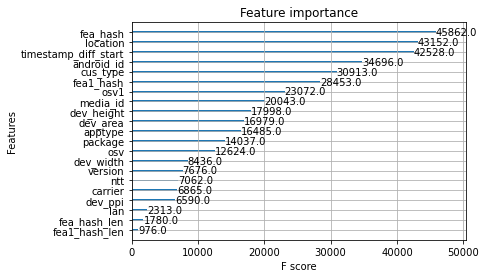

In [188]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plot_importance(xgb)

In [227]:
result=(prob[0]+prob[1]+prob[2]+prob[3]+prob[4]+prob[5]+prob[6])/7

In [235]:
res=[]
for i in range(len(result)):
    score=result[i]
    if score<0.5:
        res.append(0)
    else:
        res.append(1)

In [236]:
 prob

[array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 1, 0, ..., 1, 1, 1])]

In [237]:
result_ = pd.DataFrame(test['sid'])
result_['label'] = res
result_.to_csv('./baseline_xgboost_7z.csv', index=False)
result_

,sid,label
0,1440682,0
1,1606824,1
2,1774642,0
3,1742535,0
4,1689686,1
...,...,...
149995,1165373,1
149996,1444115,1
149997,1134378,1
149998,1700238,1
